In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from itertools import combinations, chain



from shmex.shm_data import pcp_df_of_non_shmoof_nickname, dataset_dict
from netam.multihit import (
    MultihitBurrito,
    train_test_datasets_of_pcp_df,
    HitClassModel,
    prepare_pcp_df,
)
from netam.molevol import reshape_for_codons
from epam import evaluation
import netam.framework as framework
import torch
import pandas as pd
from netam.common import BASES_AND_N_TO_INDEX, BASES
import pickle

## Exploration of multihit model extensions:
https://github.com/matsengrp/netam-experiments-1/issues/10 suggests that it may be necessary to have a more fine-grained multihit correction model that accounts for base composition of the parent codon. This notebook should be run after `multihit_model_exploration.ipynb` (it uses some outputs from that notebook). We facet OE plots by a variety of conditions relating to the composition of the parent codon, to see if we find underestimates of codon mutabilities in cases that Thayer's plots suggest.

The plots should be self-explanatory. `HC>1` means that a plot is only looking at mutations of hit class 2 and 3.

The takeaway so far is that there is a discrepancy between observed and expected counts in many cases where we'd expect it from Thayer's plots, but the discrepancy is often in opposite the expected direction.

In [2]:
# Some plotting functions

def make_hc_site_df(hit_class_burrito):
    adjustments = torch.cat([torch.tensor([0.0]), hit_class_burrito.model.values]).exp()
    data = hit_class_burrito.val_dataset
    df_rows = []
    for seq_idx, (observed_hcs, hc_probs_l, codon_mask, parent_seq) in enumerate(zip(data.observed_hcs, data.hit_class_probs, data.codon_mask, data.nt_parents)):
        parent_seq = reshape_for_codons(parent_seq)[codon_mask]
        observed_hcs = observed_hcs[codon_mask]
        hc_probs = hc_probs_l[codon_mask]
        for site, (hc, hc_probs, parent_codon) in enumerate(zip(observed_hcs, hc_probs, parent_seq)):
            parent_codon_string = "".join([BASES[i] for i in parent_codon])
            adjusted_probs = hc_probs * adjustments
            adjusted_probs = (adjusted_probs / adjusted_probs.sum()).detach().numpy()
            df_rows.append((
                seq_idx,
                site,
                hc,
                adjusted_probs[0],
                adjusted_probs[1],
                adjusted_probs[2],
                adjusted_probs[3],
                "A" in parent_codon_string,
                "G" in parent_codon_string,
                "C" in parent_codon_string,
                "T" in parent_codon_string,
                parent_codon_string))

    return pd.DataFrame(
        df_rows,
        columns=[
            "sequence",
            "site",
            "hit_class",
            "0_hc_prob",
            "1_hc_prob",
            "2_hc_prob",
            "3_hc_prob",
            "contains_A",
            "contains_G",
            "contains_C",
            "contains_T",
            "parent_codon",
        ]
    )



In [3]:
# Some plotting functions
def oe_plot_of_hc_site_df(hc_site_df):
    """ Facet by hit class"""
    fig, axs = plt.subplots(3, 1, figsize=(12, 20))

    for i in range(3):
        hit_class = i + 1
        plot_df = pd.DataFrame({
            "mutation": hc_site_df["hit_class"] == hit_class,
            "prob": hc_site_df[f"{hit_class}_hc_prob"],
        })
        
        result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs[i], None)
        axs[i].set_title(f"{hit_class} mutations per codon; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
    fig.tight_layout()
    return fig

def oe_plot_of_hc_nt_site_df(hc_site_df, nt):
    """ Facet by hit class and whether the parent codon contains nt"""
    fig, axs = plt.subplots(3, 2, figsize=(12, 20))

    for i in range(3):
        hit_class = i + 1
        for j, cond in enumerate([True, False]):
            new_df = hc_site_df[hc_site_df[f"contains_{nt}"] == cond]
            plot_df = pd.DataFrame({
                "mutation": new_df["hit_class"] == hit_class,
                "prob": new_df[f"{hit_class}_hc_prob"],
            })
            
            result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs[i][j], None)
            axs[i][j].set_title(f"{hit_class} mutations per codon {'with' if cond else 'without'} {nt}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
    fig.tight_layout()
    return fig

In [4]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    # "l2_regularization_coeff": 1e-6
}
epochs = 200
# Get rid of this eventually
site_count = 500

# # Old model
# nt_crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
# hc_crepe_path = "cnn_joi_lrg-shmoof_small-fixed-0-hc"
# branch_lengths_path = "cnn_joi_lrg-shmoof_small-fixed-0-hc-branch-lengths"

# new model actually used in epam
nt_crepe_path = '../train/fixed_models/cnn_ind_med-shmoof_small-full-0'
hc_crepe_path = "../train/cnn_ind_med-shmoof_small-full-0-hc"
branch_lengths_path = "cnn_ind_med-shmoof_small-full-0-hc-branch-lengths"

nt_crepe = framework.load_crepe(nt_crepe_path)
hc_crepe = framework.load_crepe(hc_crepe_path)

tang_df = pcp_df_of_non_shmoof_nickname("tangshm")
# subsampled_tang_df = tang_df.iloc[::int(len(tang_df)/4000)].copy().reset_index(drop=True)
subsampled_tang_df = tang_df.copy().reset_index(drop=True)
pcp_df = prepare_pcp_df(subsampled_tang_df, nt_crepe, site_count)

_, train_data = train_test_datasets_of_pcp_df(pcp_df, train_frac=0.0)
val_data = train_data

Loading /Users/wdumm/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz


In [5]:
burrito = MultihitBurrito(train_data, val_data, hc_crepe.model, **burrito_params)
# The model adjustments are produced with joint_train (they're not just based on the branch lengths for the uncorrected model),
# so you may want to re-fit branch lengths on your data:
print(burrito.model.values.exp())

new_branch_lengths = burrito.find_optimal_branch_lengths(train_data)

# with open(branch_lengths_path, 'rb') as fh:
#     new_branch_lengths = pickle.load(fh)
train_data.branch_lengths = new_branch_lengths
# Val data is the same object, so no need to fit those branch lengths.
# new_val_branch_lengths = burrito.find_optimal_branch_lengths(val_data)
# val_data.branch_lengths = new_val_branch_lengths

tensor([0.8852, 1.4248, 3.2502], grad_fn=<ExpBackward0>)


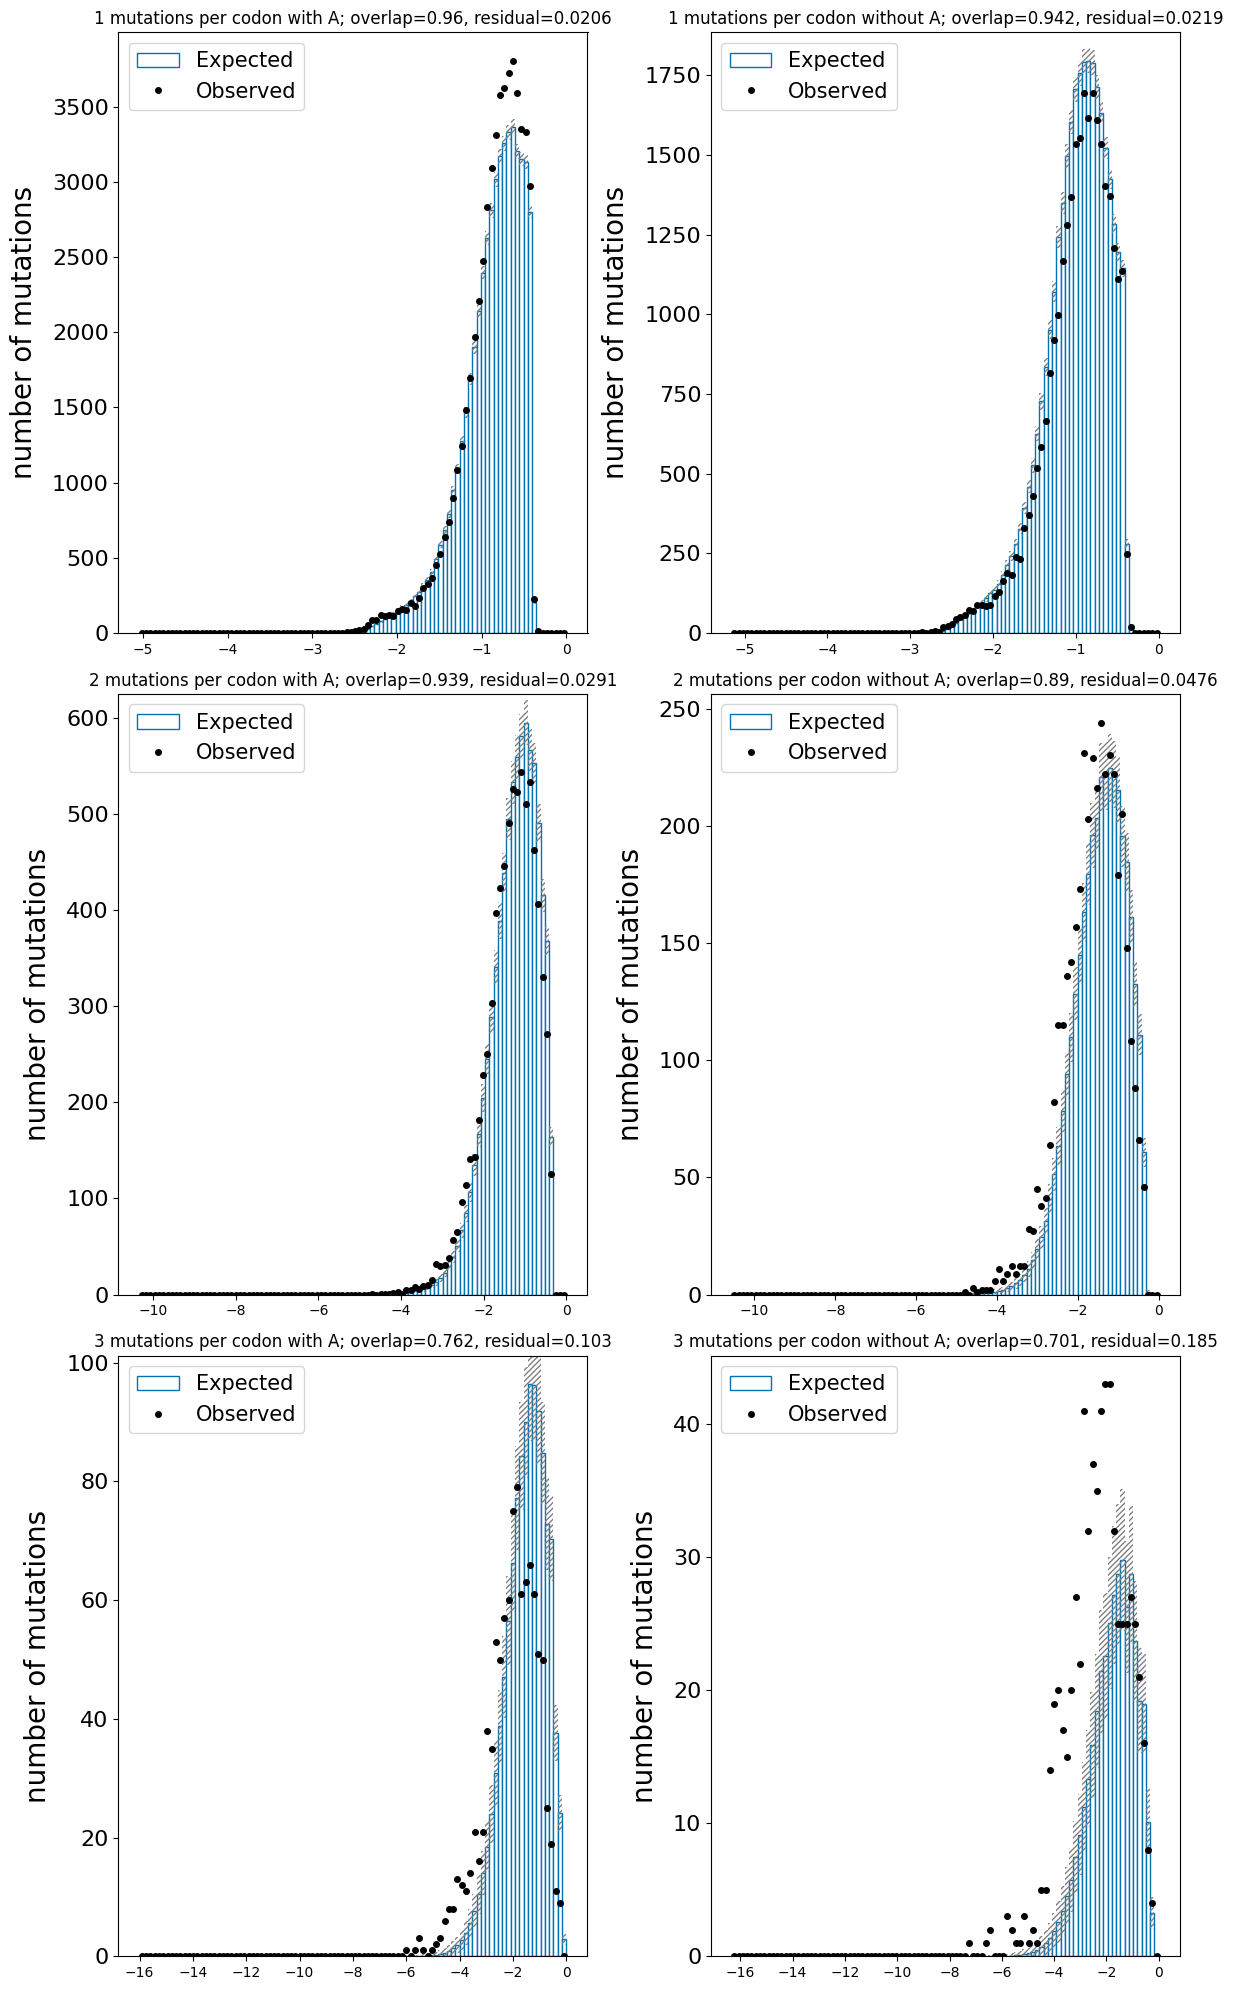

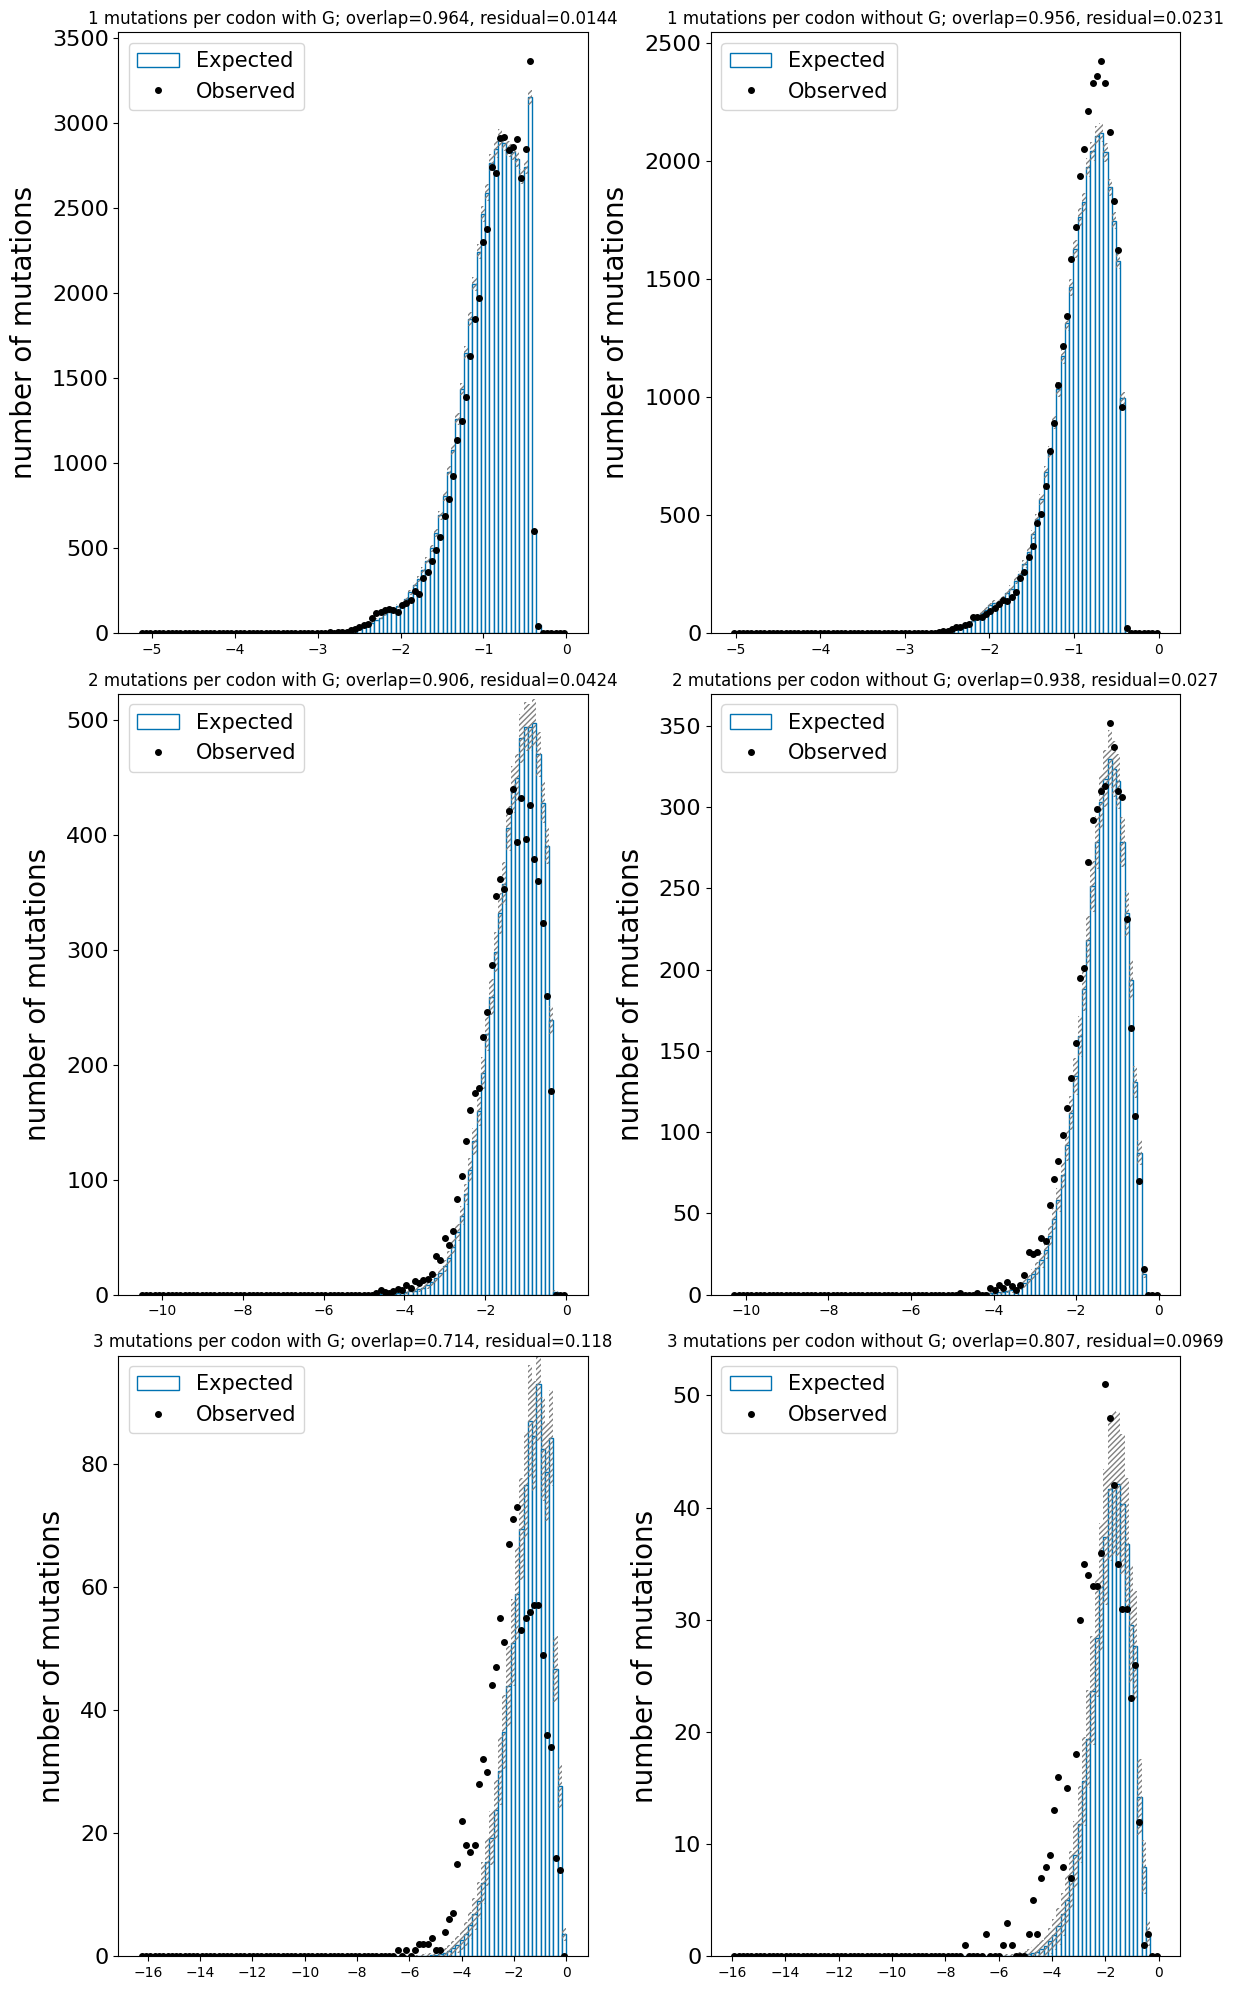

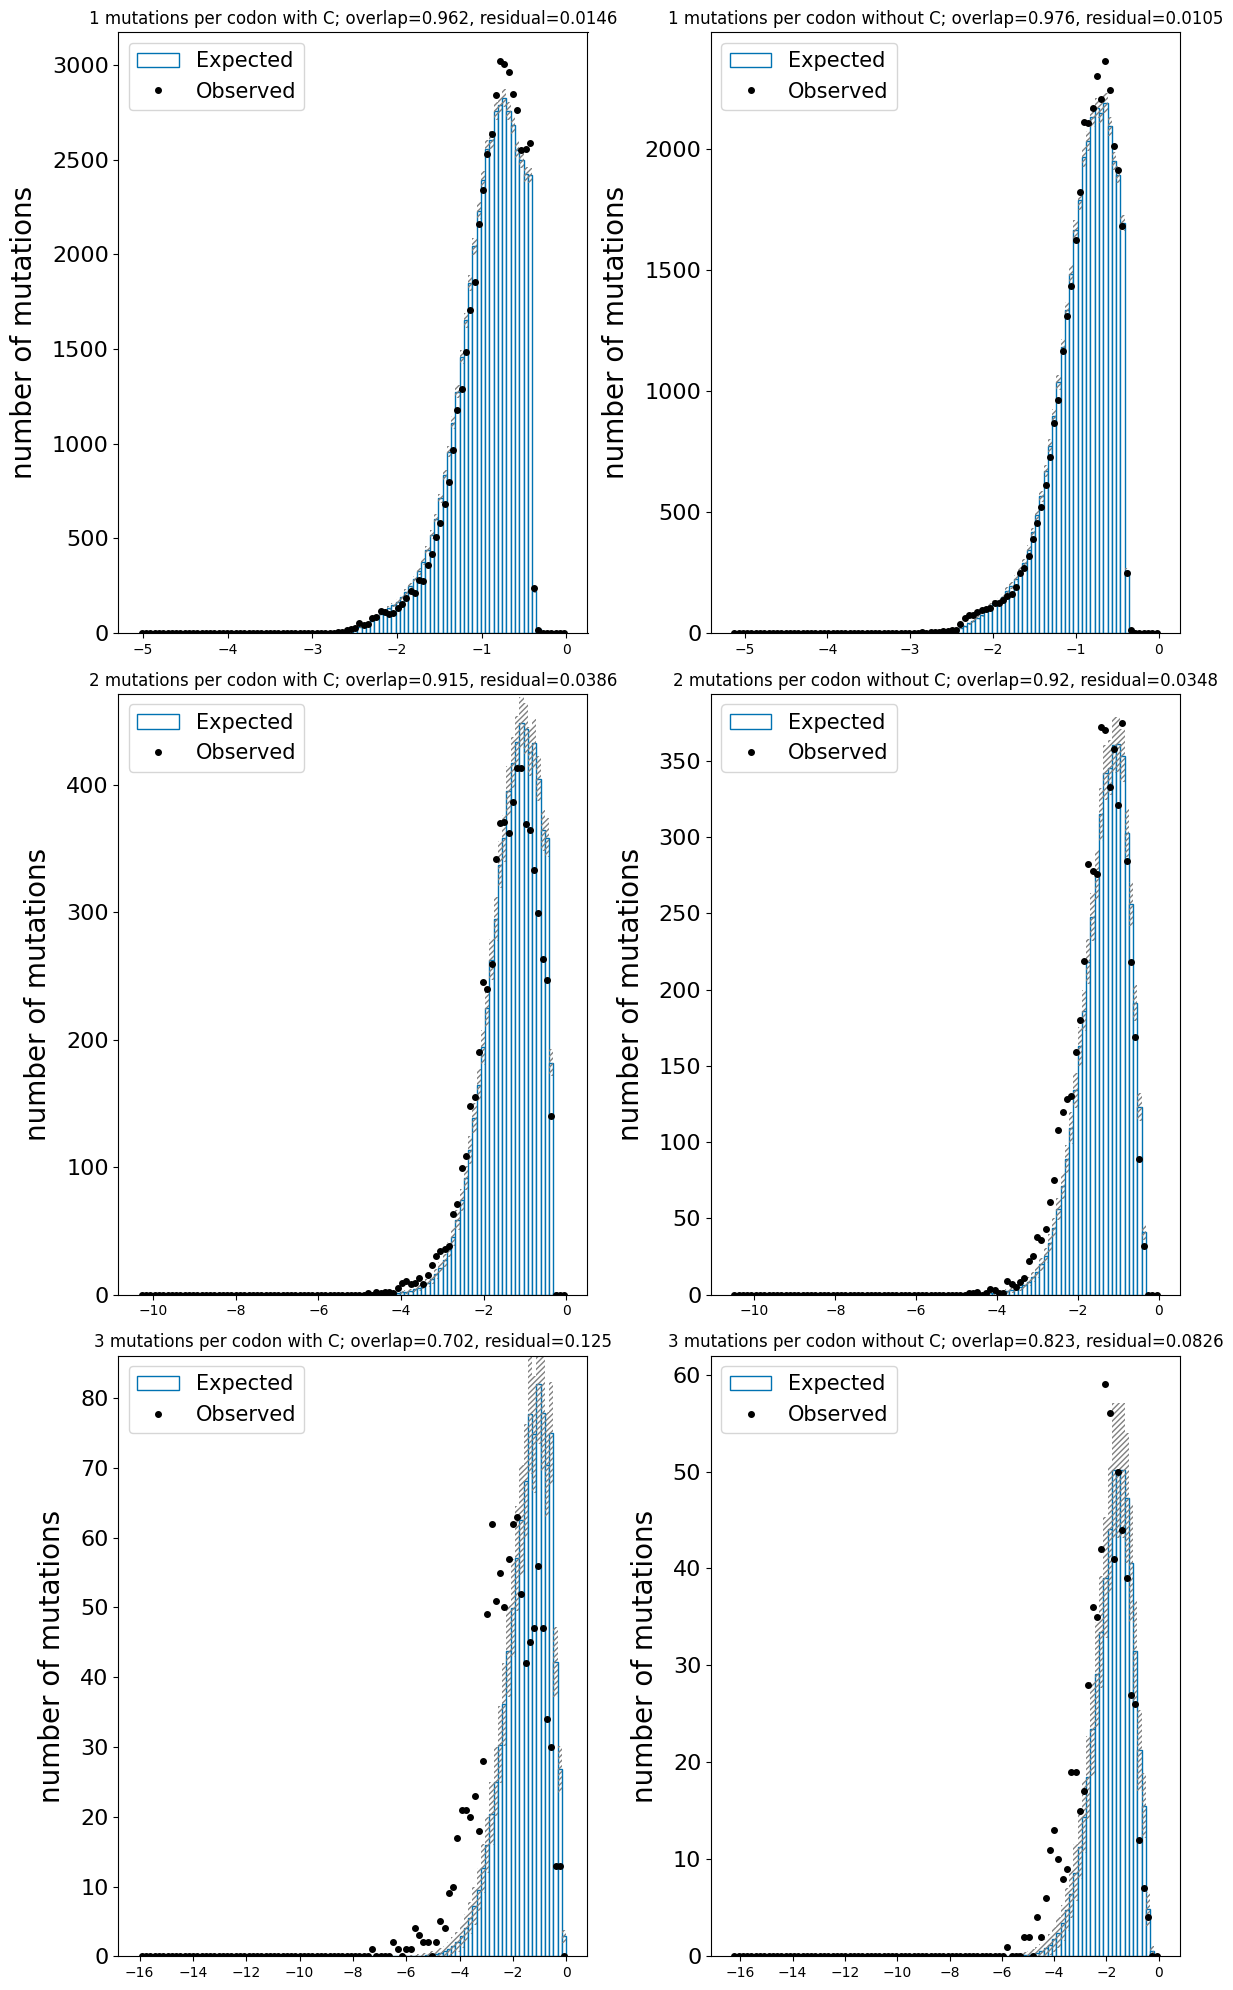

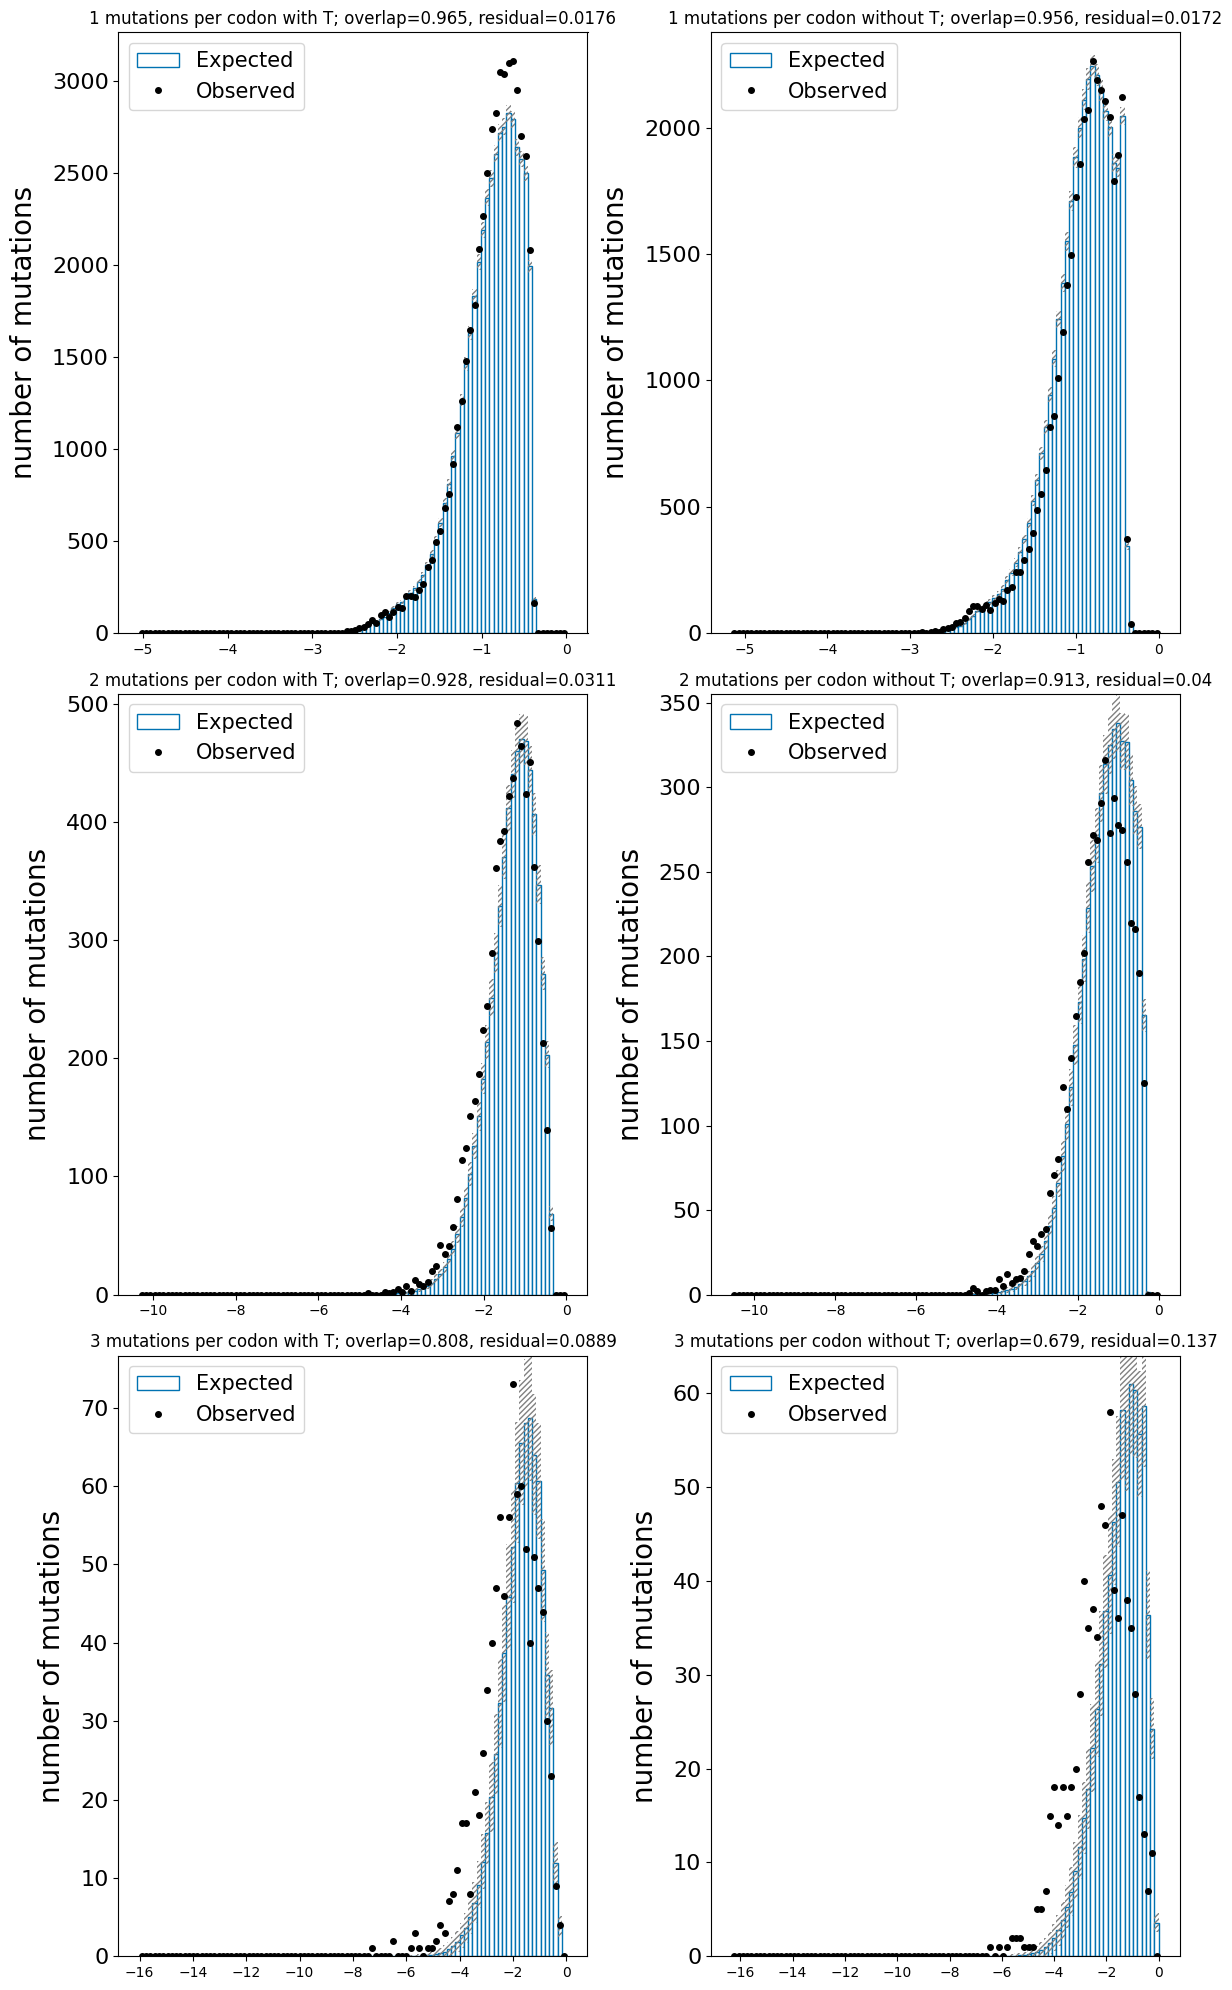

In [6]:
hc_site_df = make_hc_site_df(burrito)
figs = [oe_plot_of_hc_nt_site_df(hc_site_df, nt) for nt in "AGCT"]

In [7]:

with PdfPages("one_base_hc_stratified_oe_plots.pdf") as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close(fig)


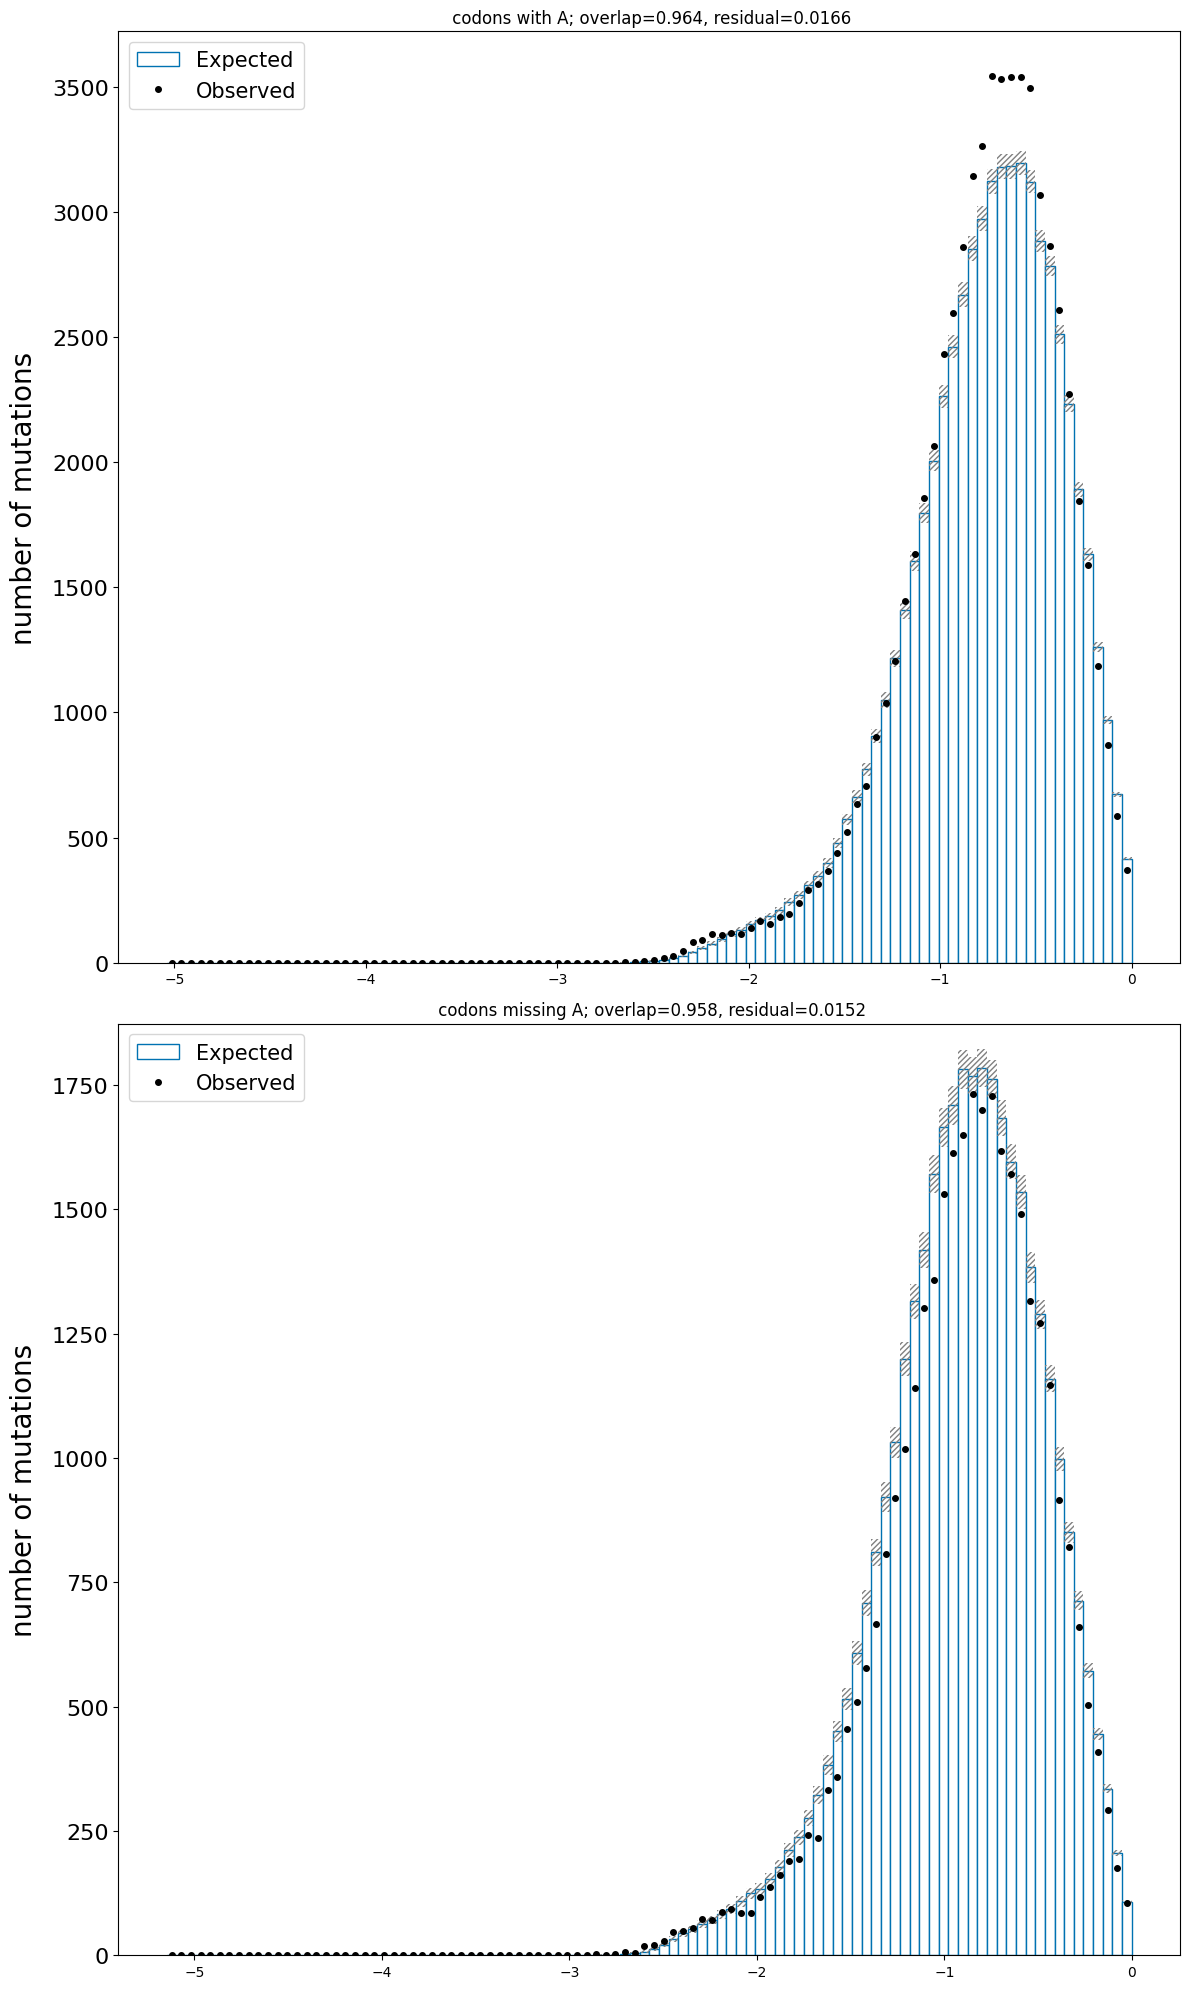

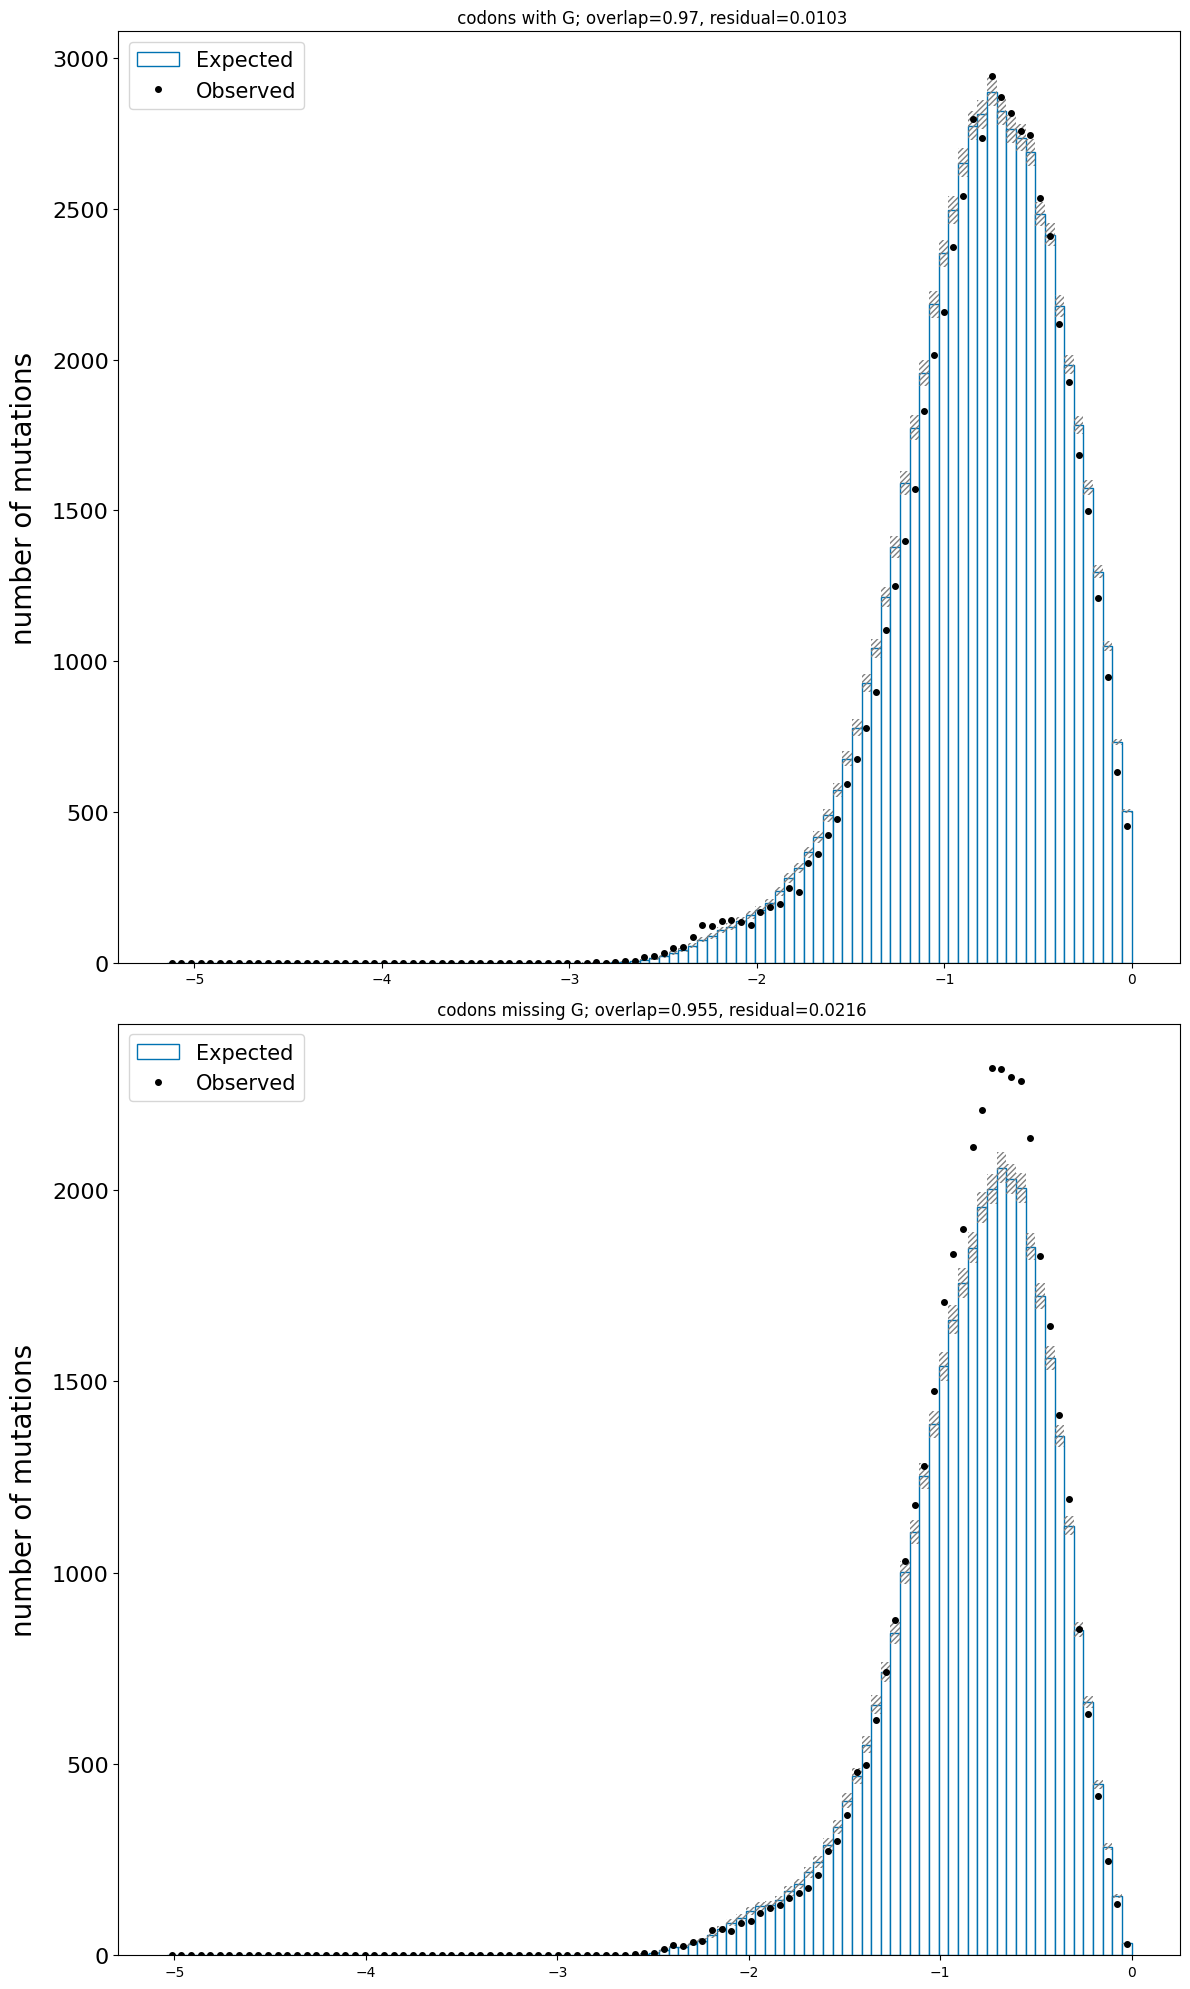

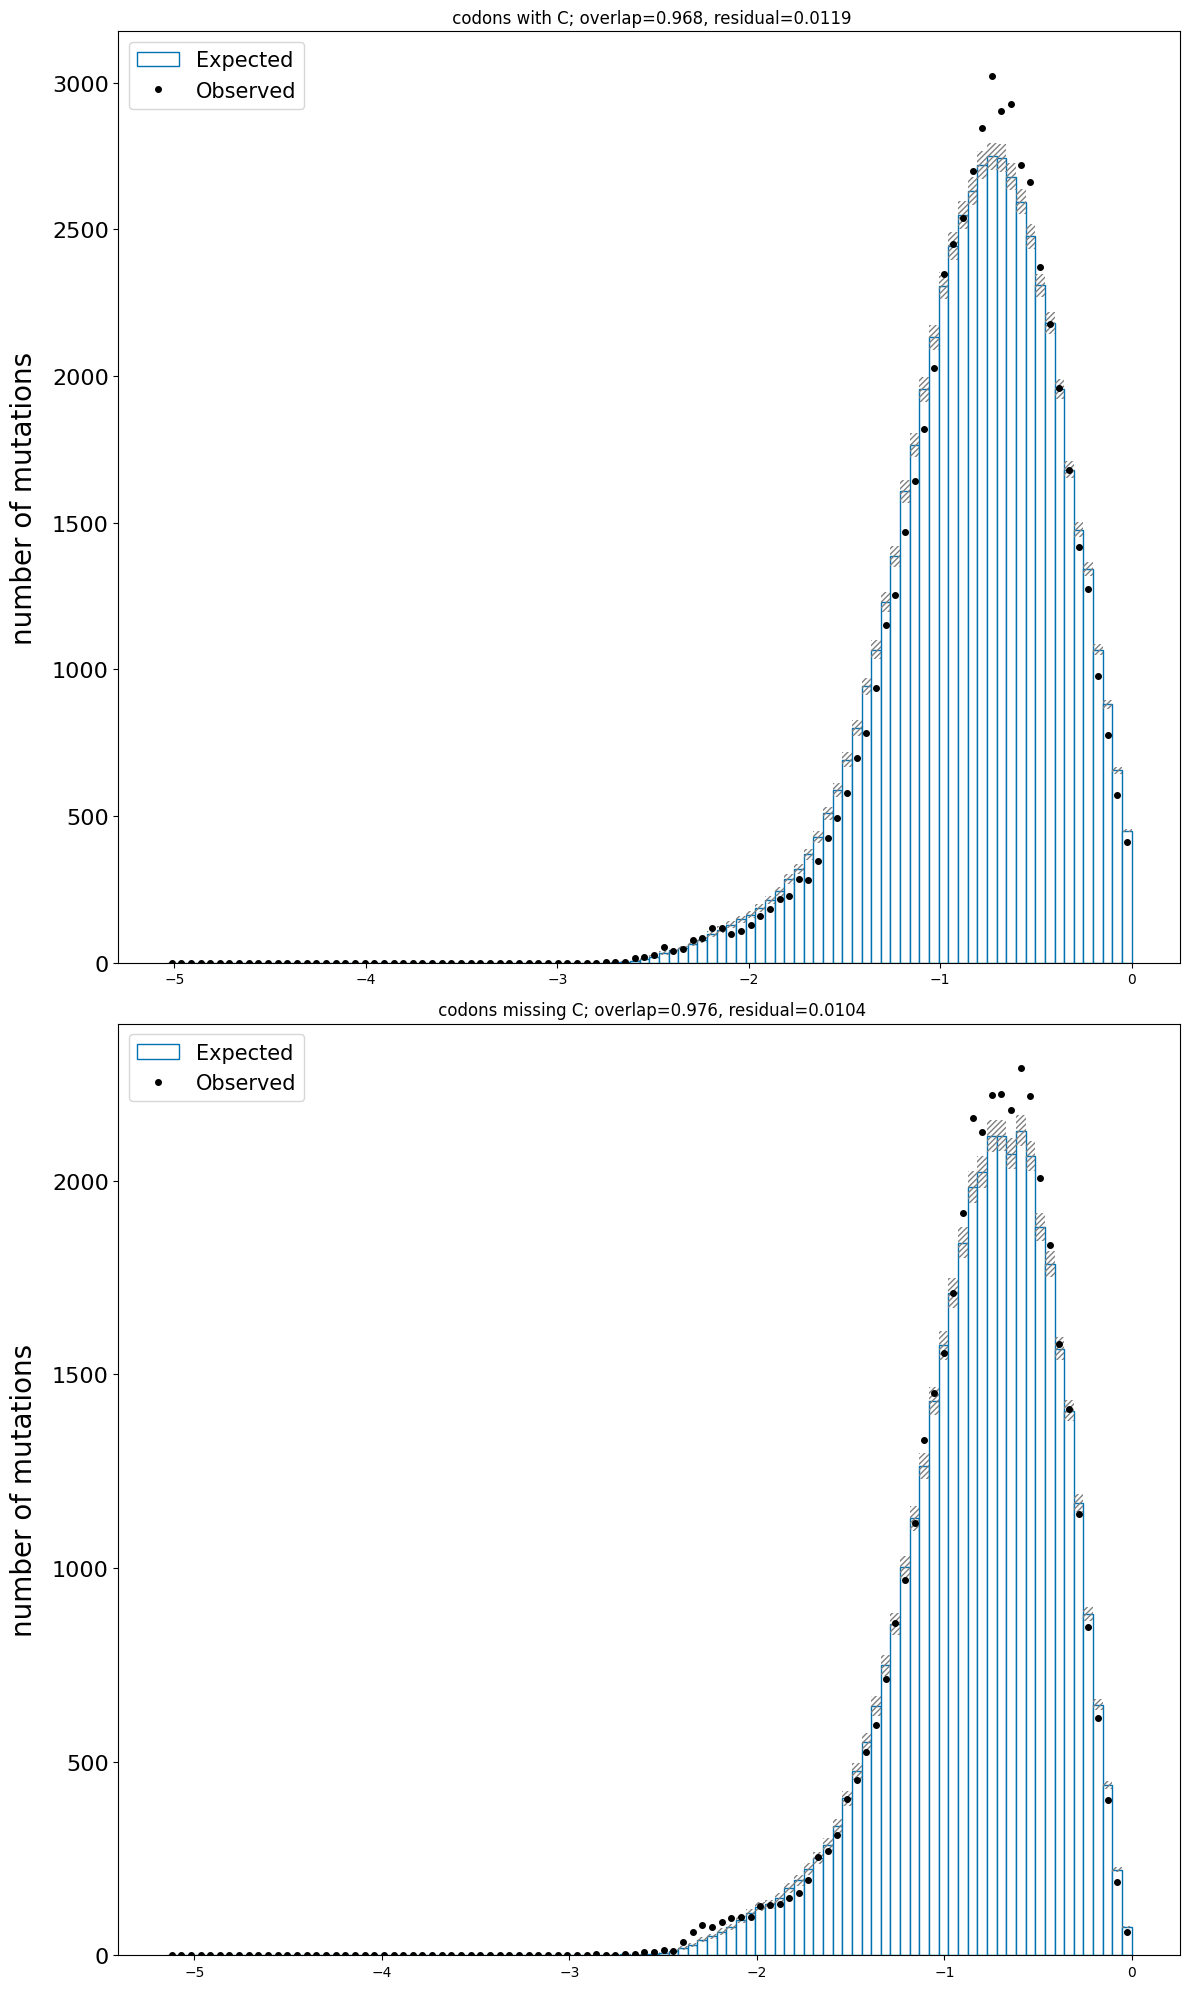

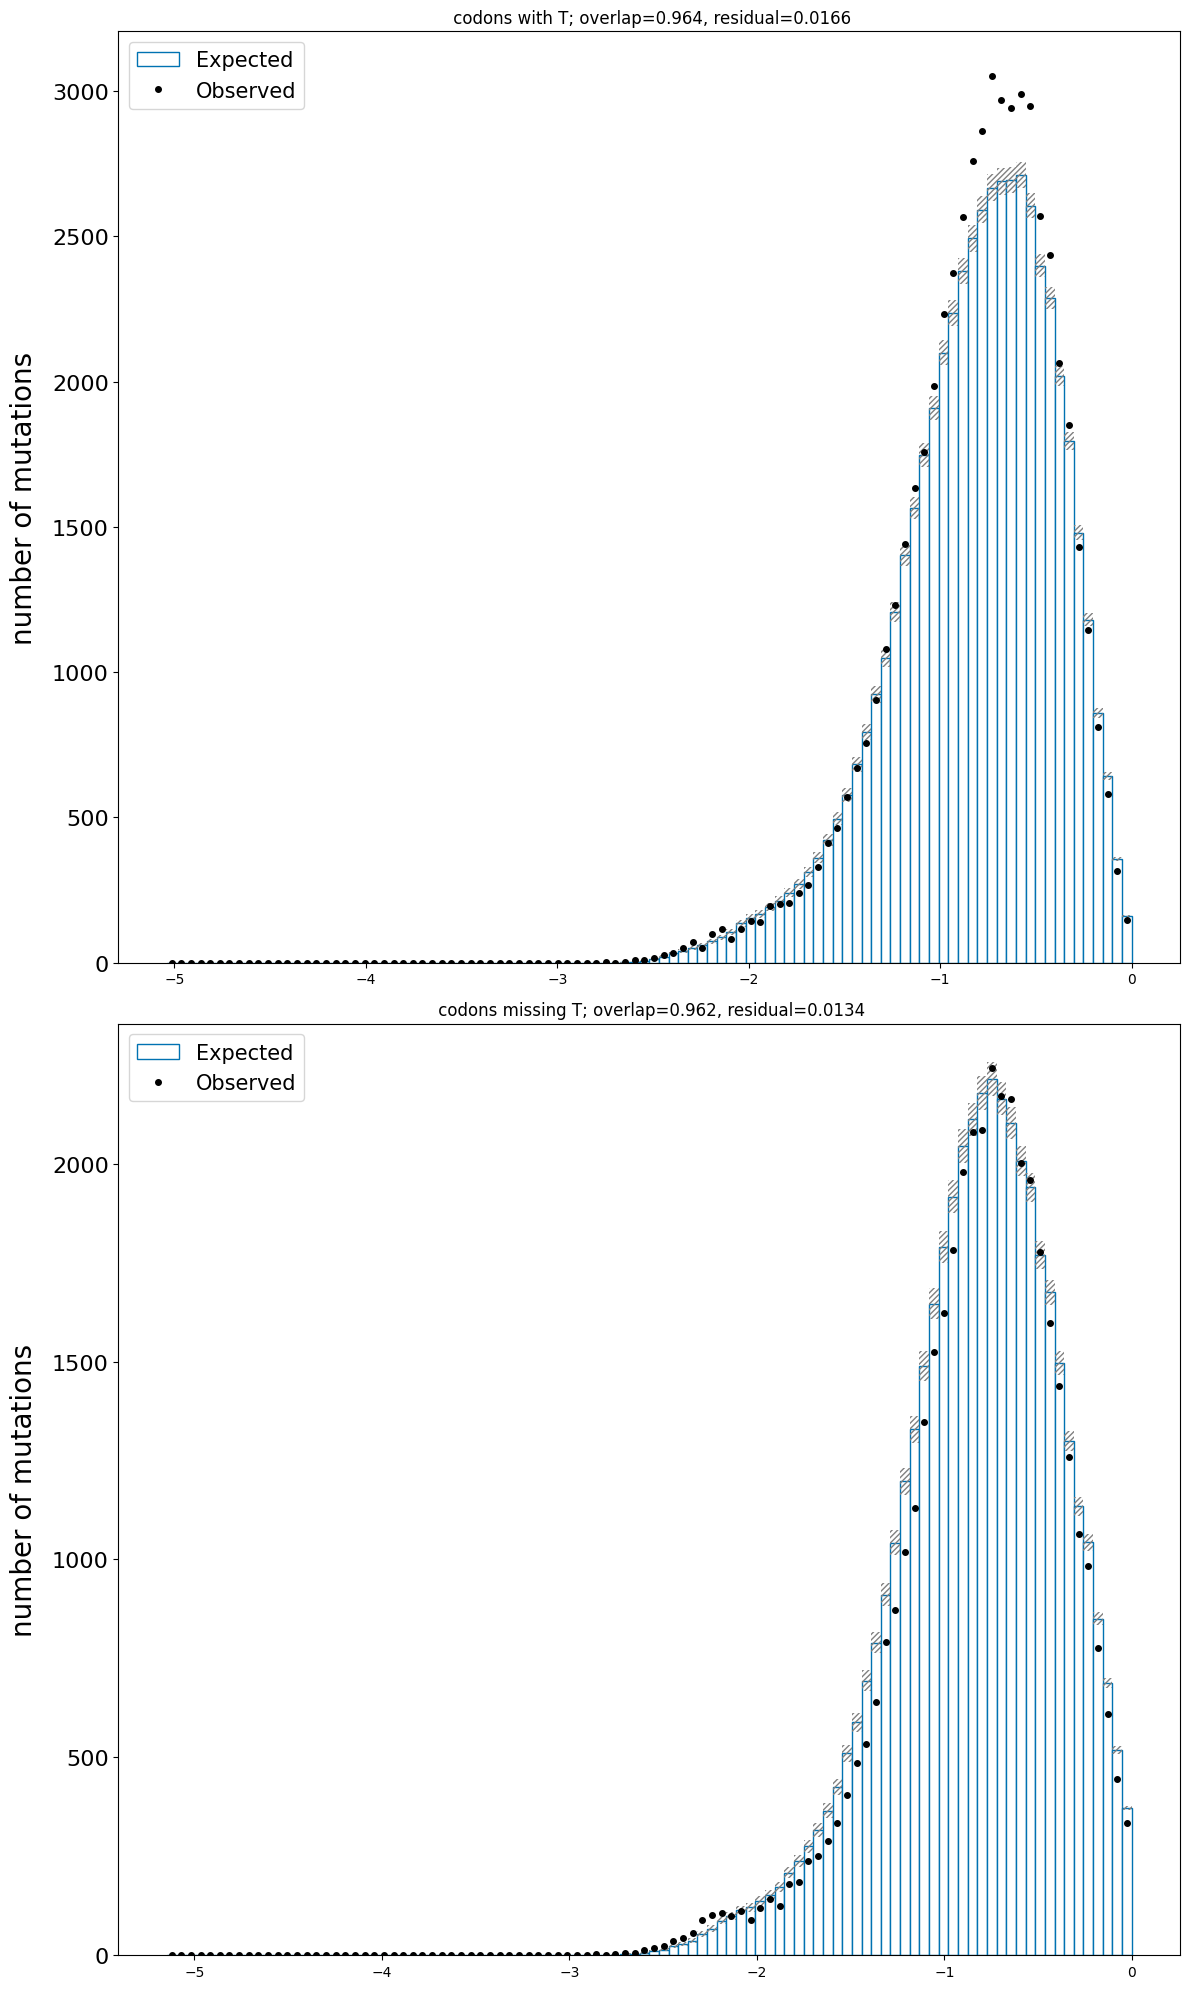

In [8]:

def oe_plot_of_hc_2p_1nt_site_df(hc_site_df, nt, hc_1p=False):
    """Stratifies by whether parent codon contains both nts, and only looks at hit class 2+ codons if hc_1p is True.
    """
    fig, axs = plt.subplots(2, 1, figsize=(12, 20))

    true_df = hc_site_df[hc_site_df[f"contains_{nt}"]]
    false_df = hc_site_df[~hc_site_df[f"contains_{nt}"]]
    for cont_str, df, ax in zip([f"with {nt}", f"missing {nt}"], [true_df, false_df], axs):
        if hc_1p:
            plot_df = pd.DataFrame({
                "mutation": df["hit_class"] > 1,
                "prob": df[f"2_hc_prob"] + df[f"3_hc_prob"],
            })
        else:
            plot_df = pd.DataFrame({
                "mutation": df["hit_class"] > 0,
                "prob": 1 - df["0_hc_prob"],
            })

        
        result_dict = evaluation.plot_observed_vs_expected(plot_df, None, ax, None)
        ax.set_title(f"{'HC>1' if hc_1p else ''} codons {cont_str}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
    fig.tight_layout()
    return fig

figs = [oe_plot_of_hc_2p_1nt_site_df(hc_site_df, nt, hc_1p=False) for nt in "AGCT"]
# Save figs to a single multi-page pdf, one plot per page
# Import PdfPages

In [9]:

with PdfPages("one_base_faceted_oe_plots.pdf") as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close(fig)


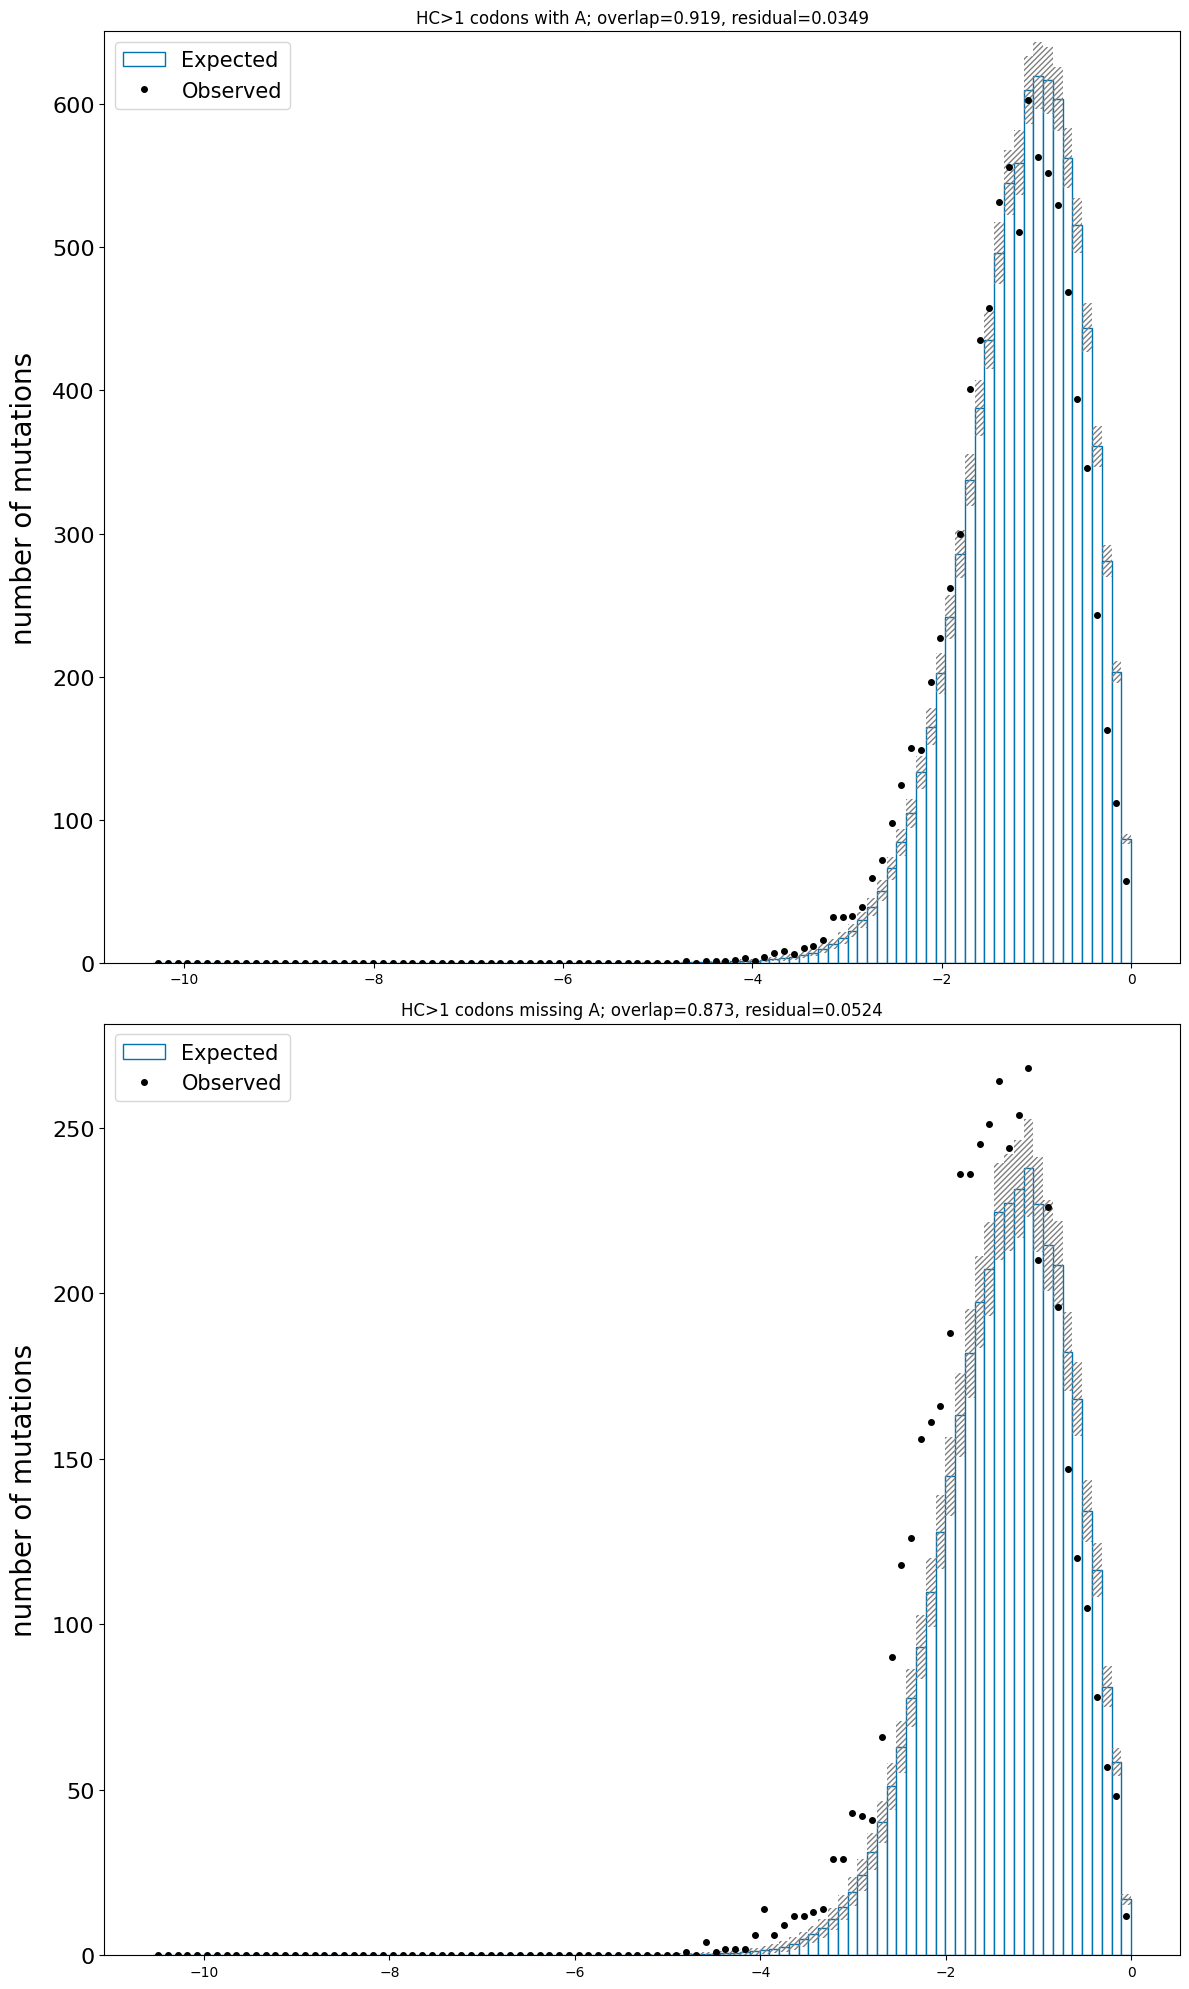

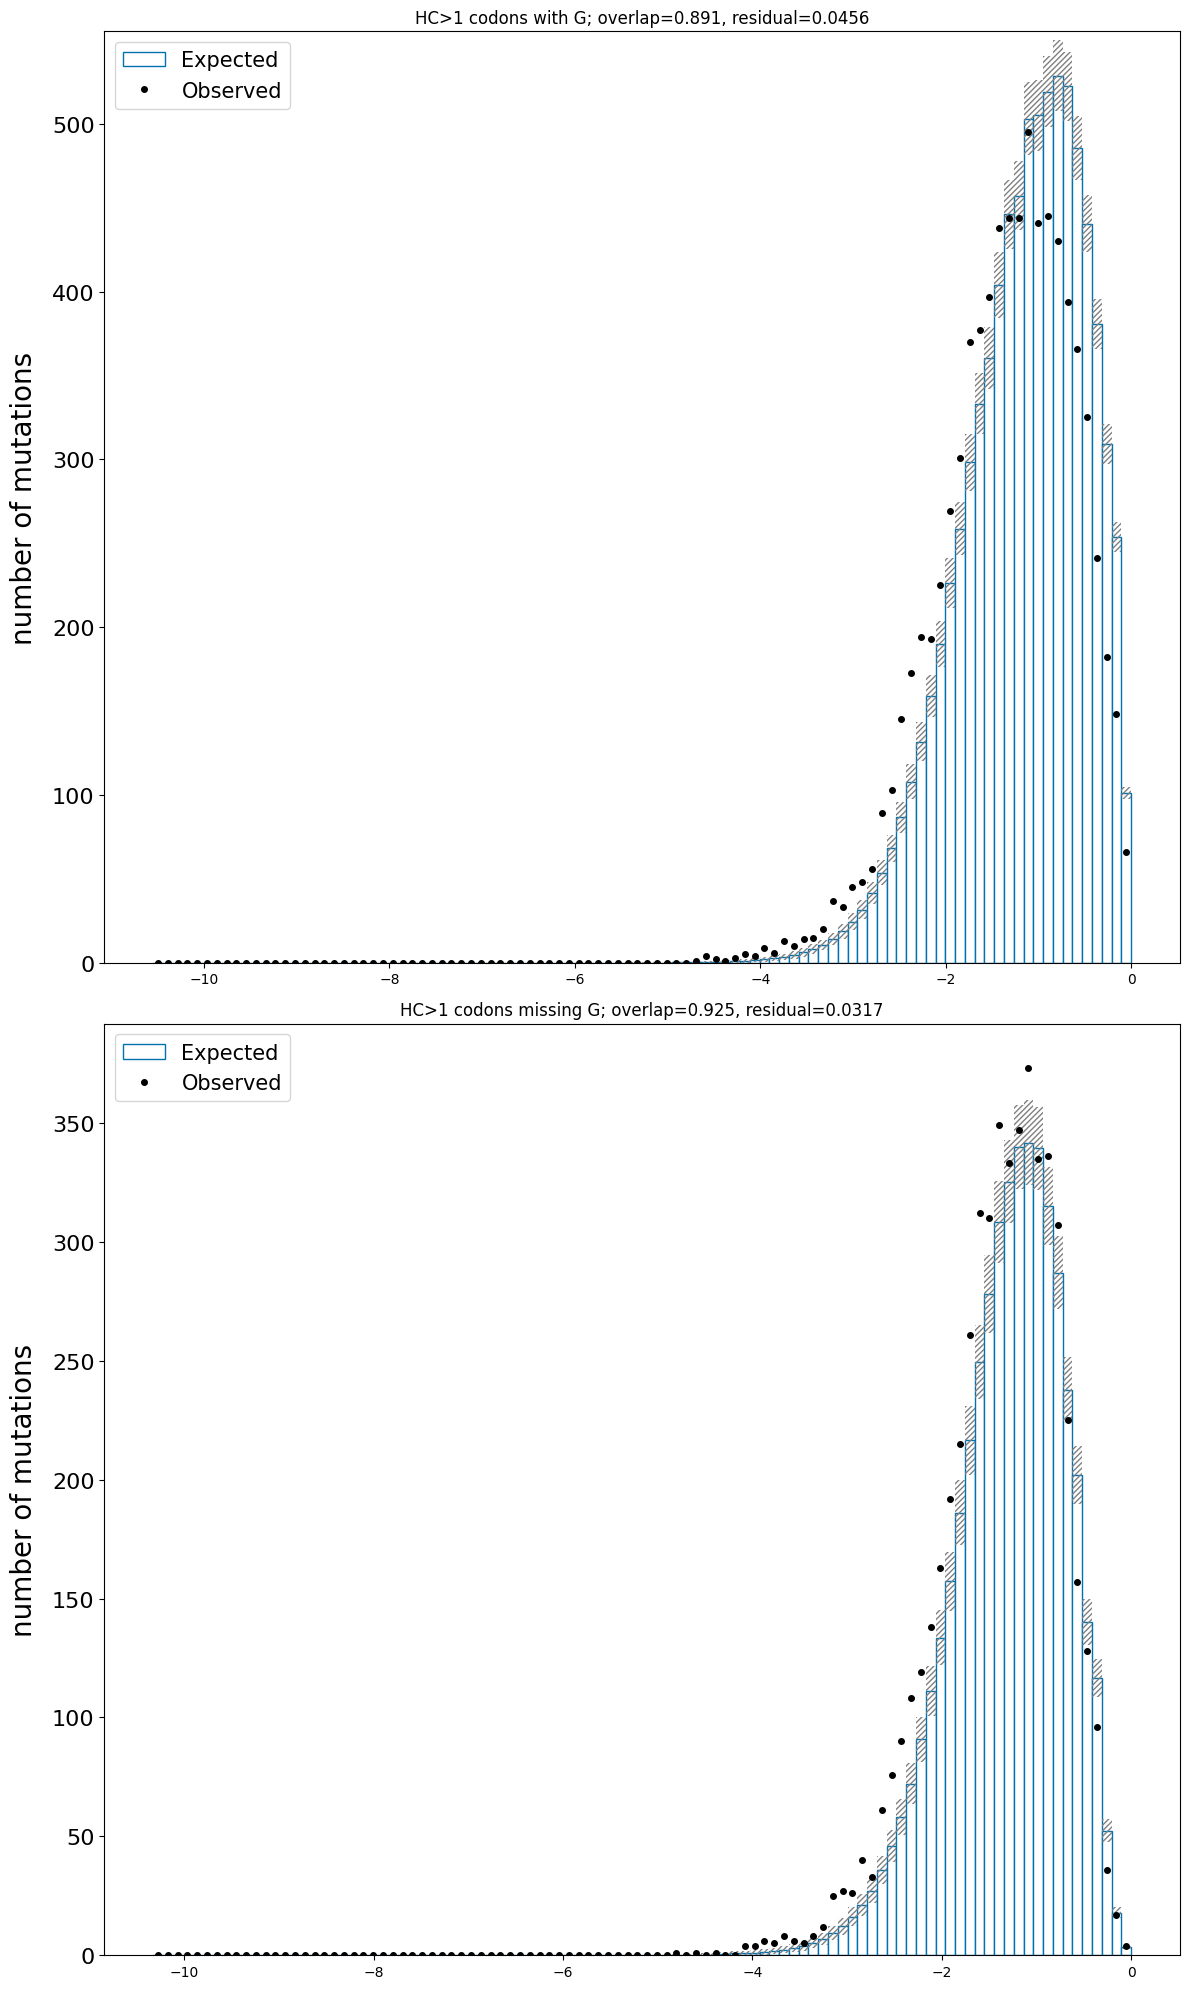

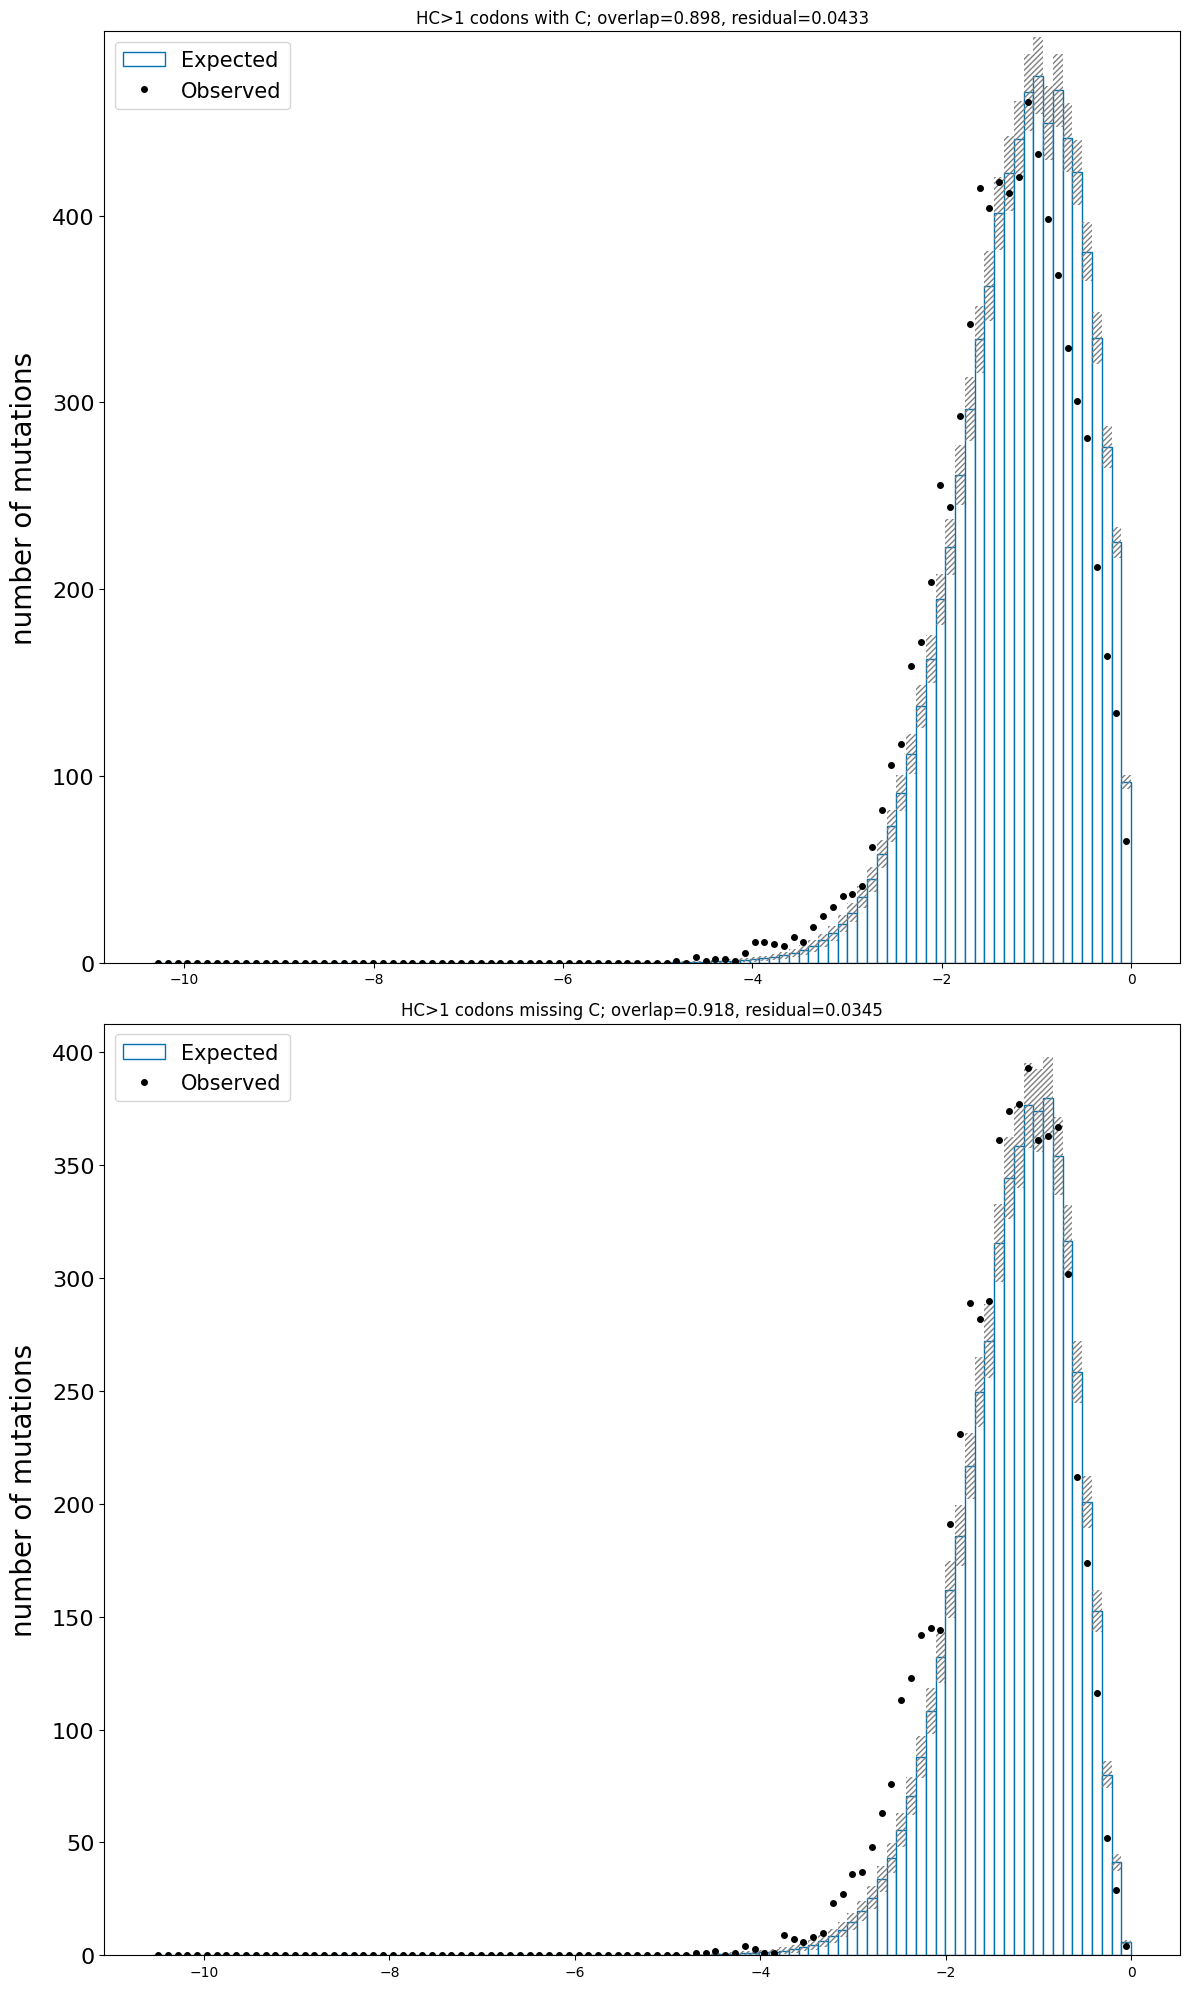

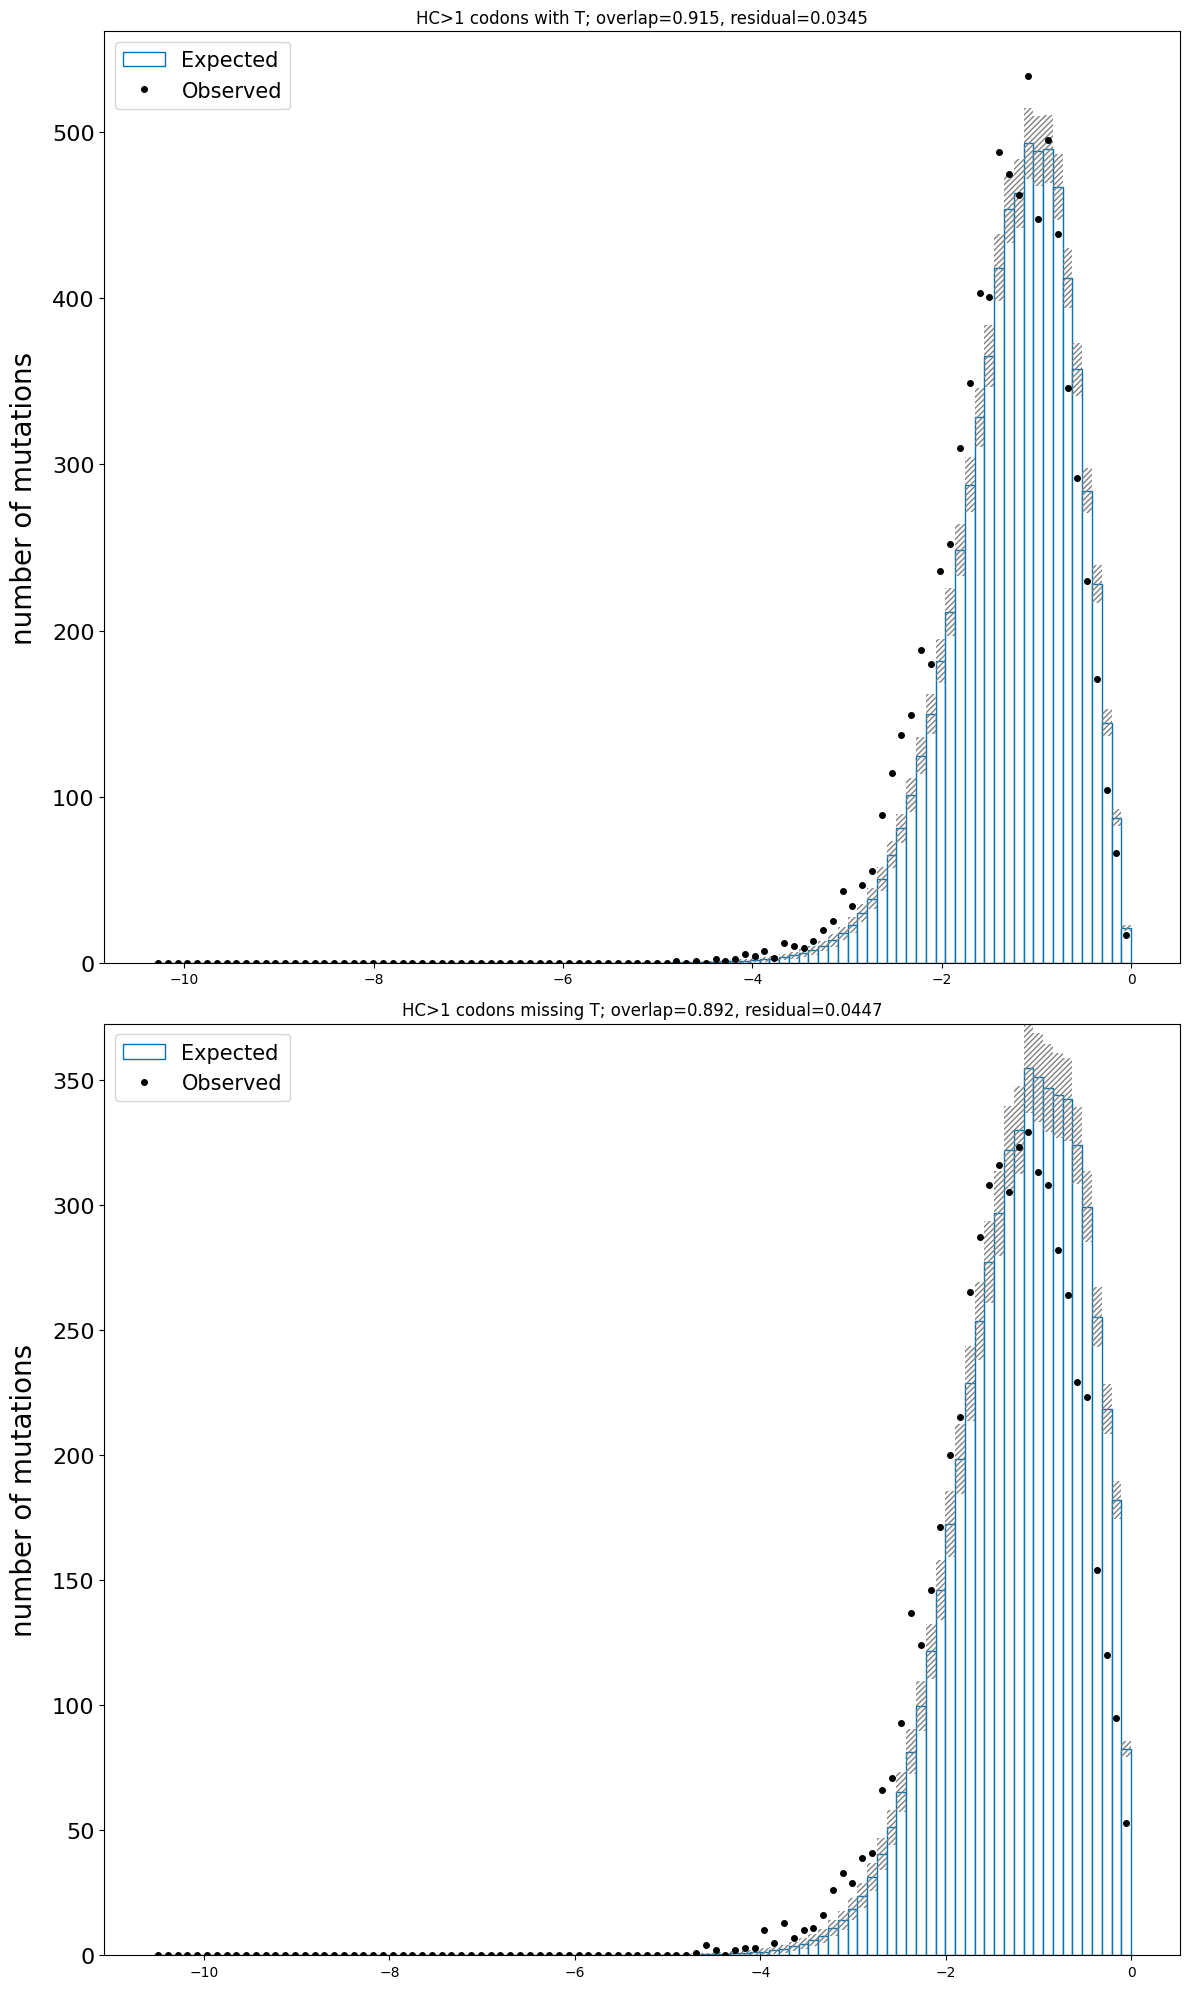

In [10]:

figs = [oe_plot_of_hc_2p_1nt_site_df(hc_site_df, nt, hc_1p=True) for nt in "AGCT"]

In [11]:

with PdfPages("one_base_faceted_oe_plots_hc_1p.pdf") as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close(fig)


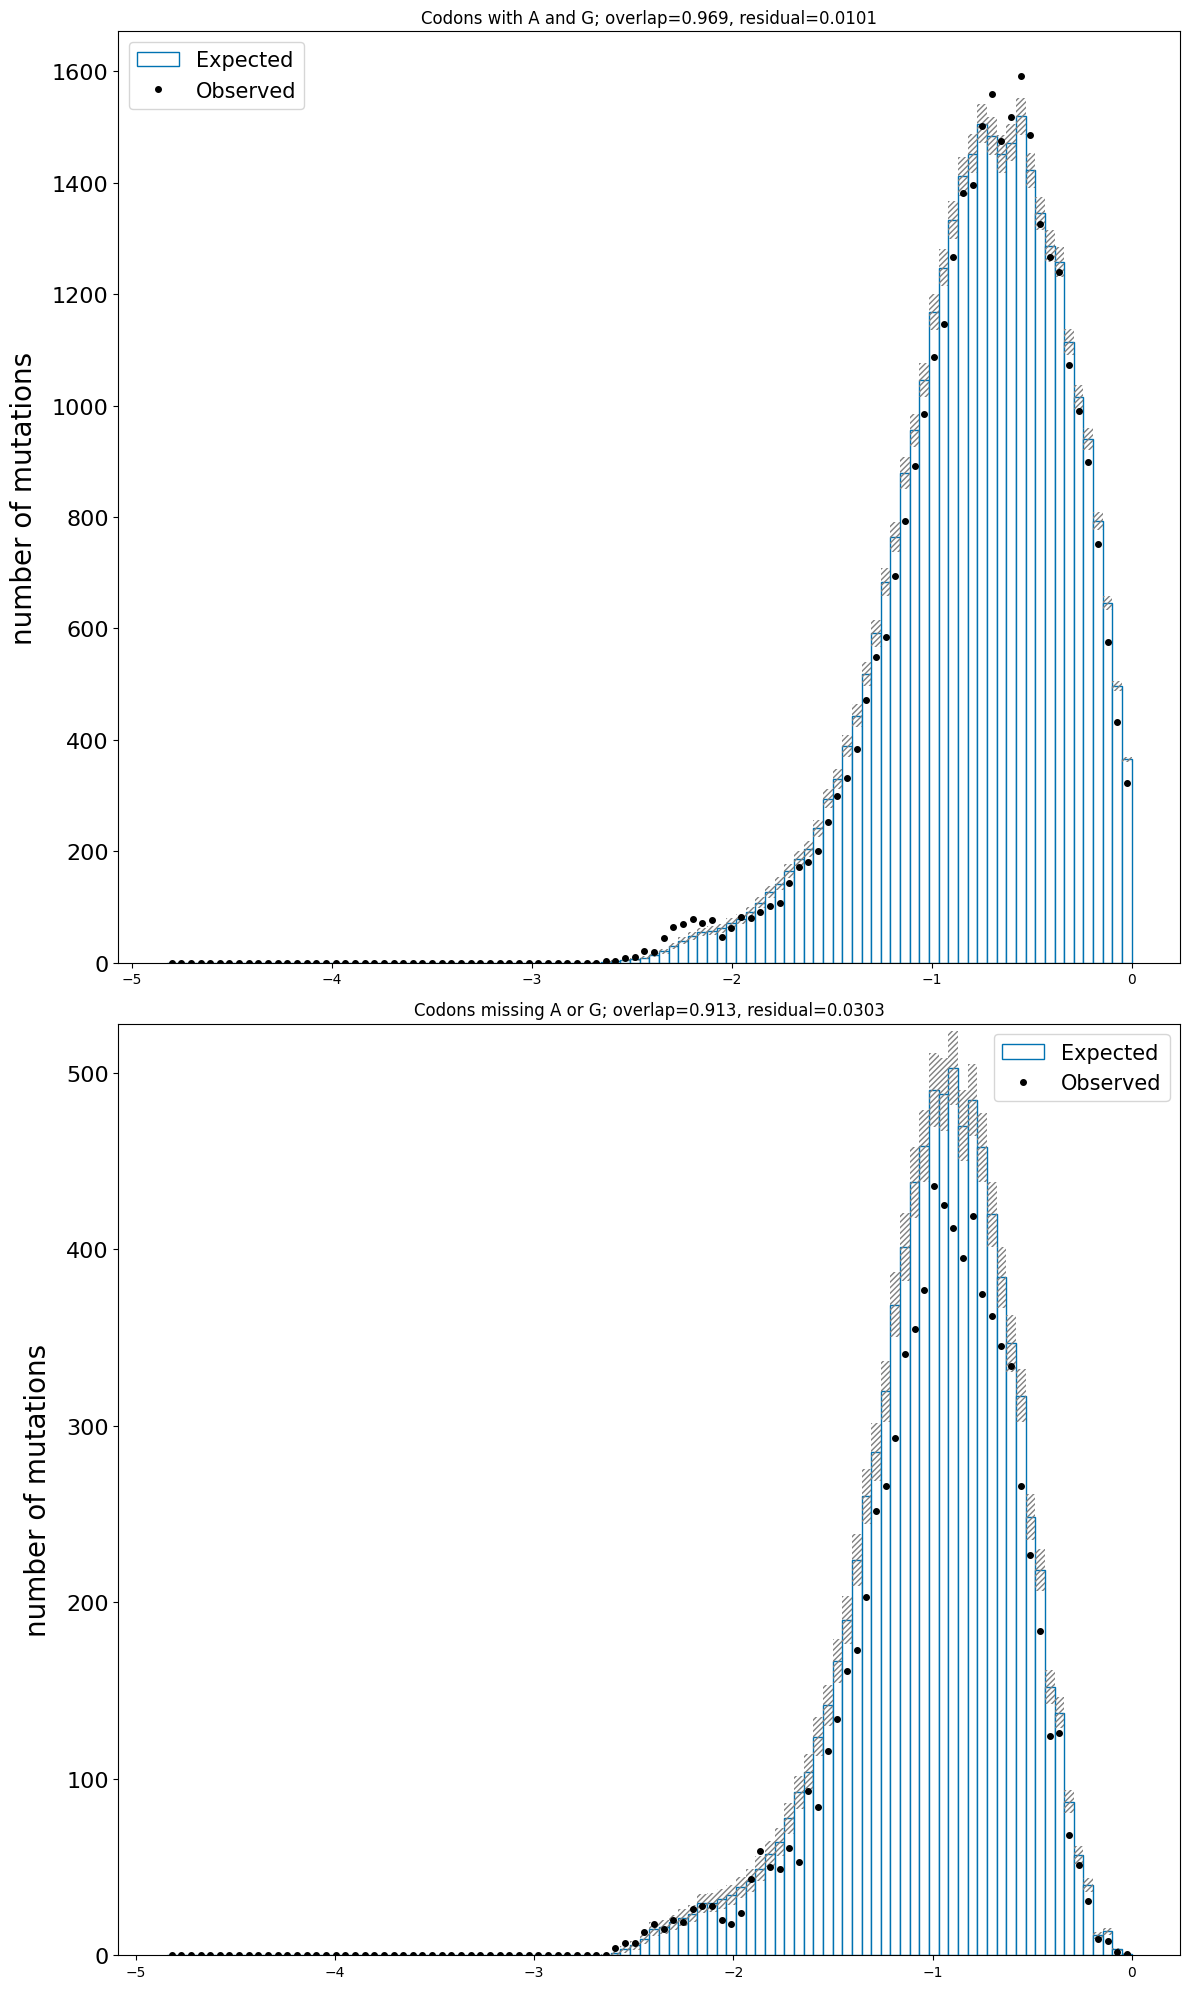

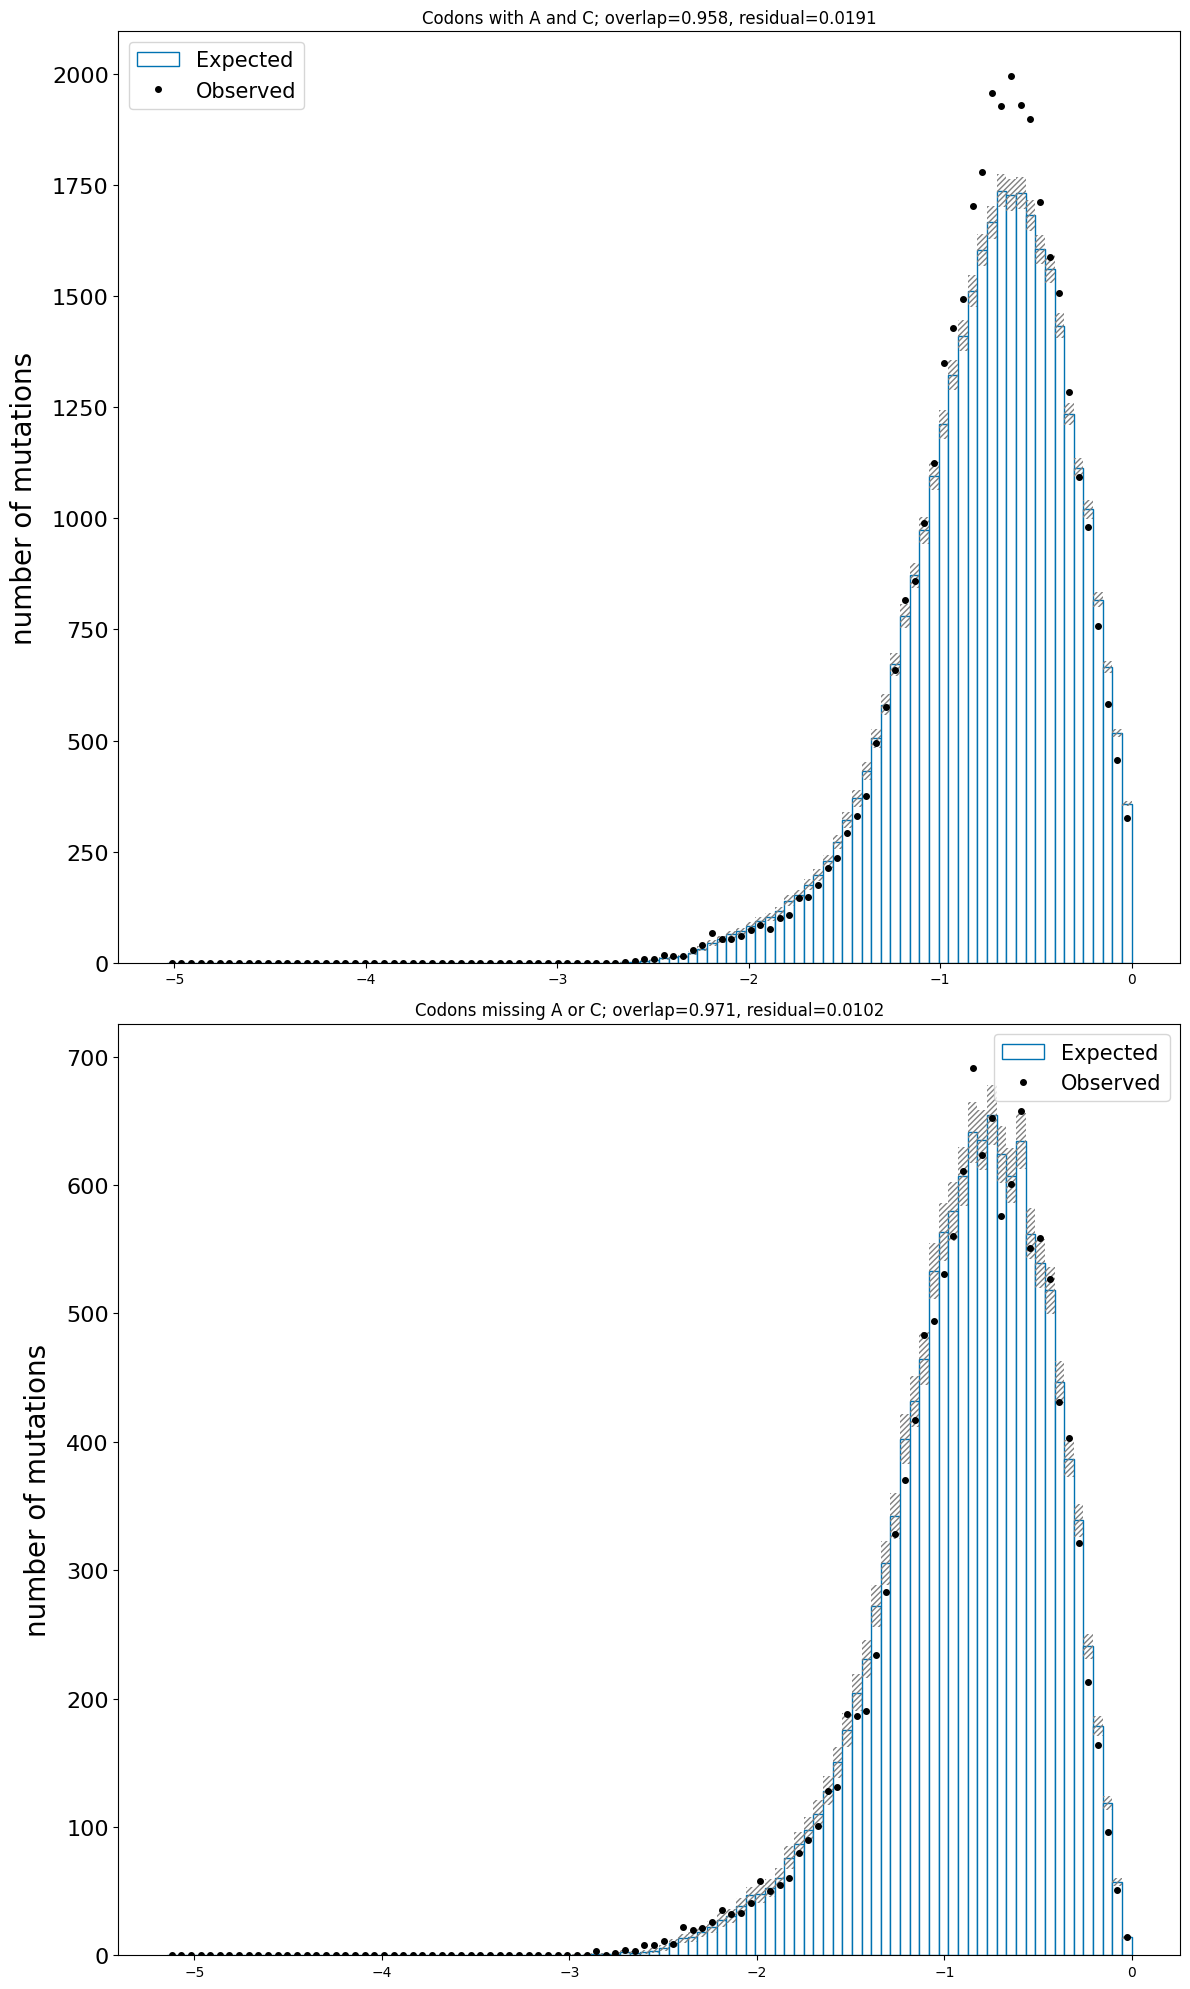

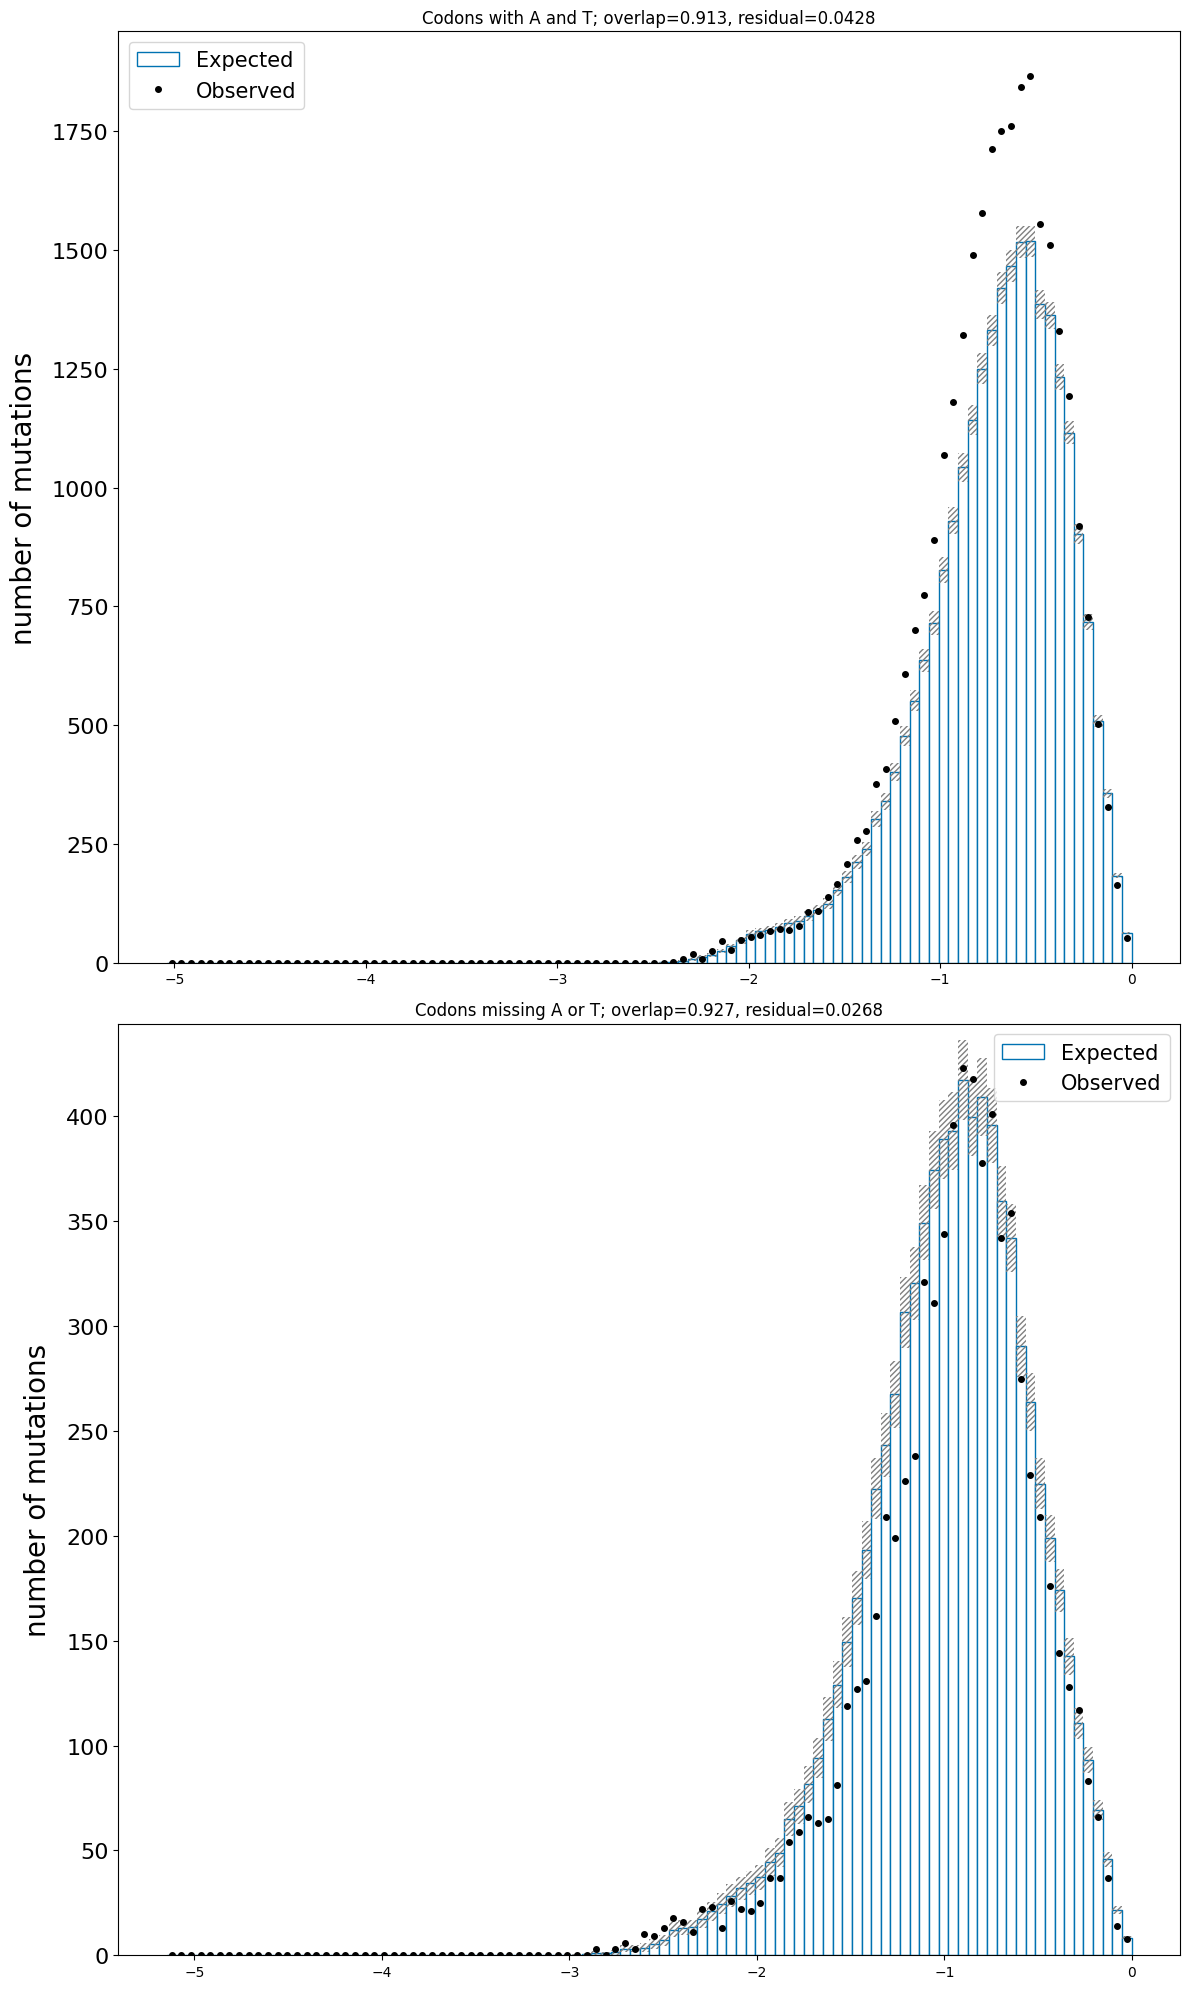

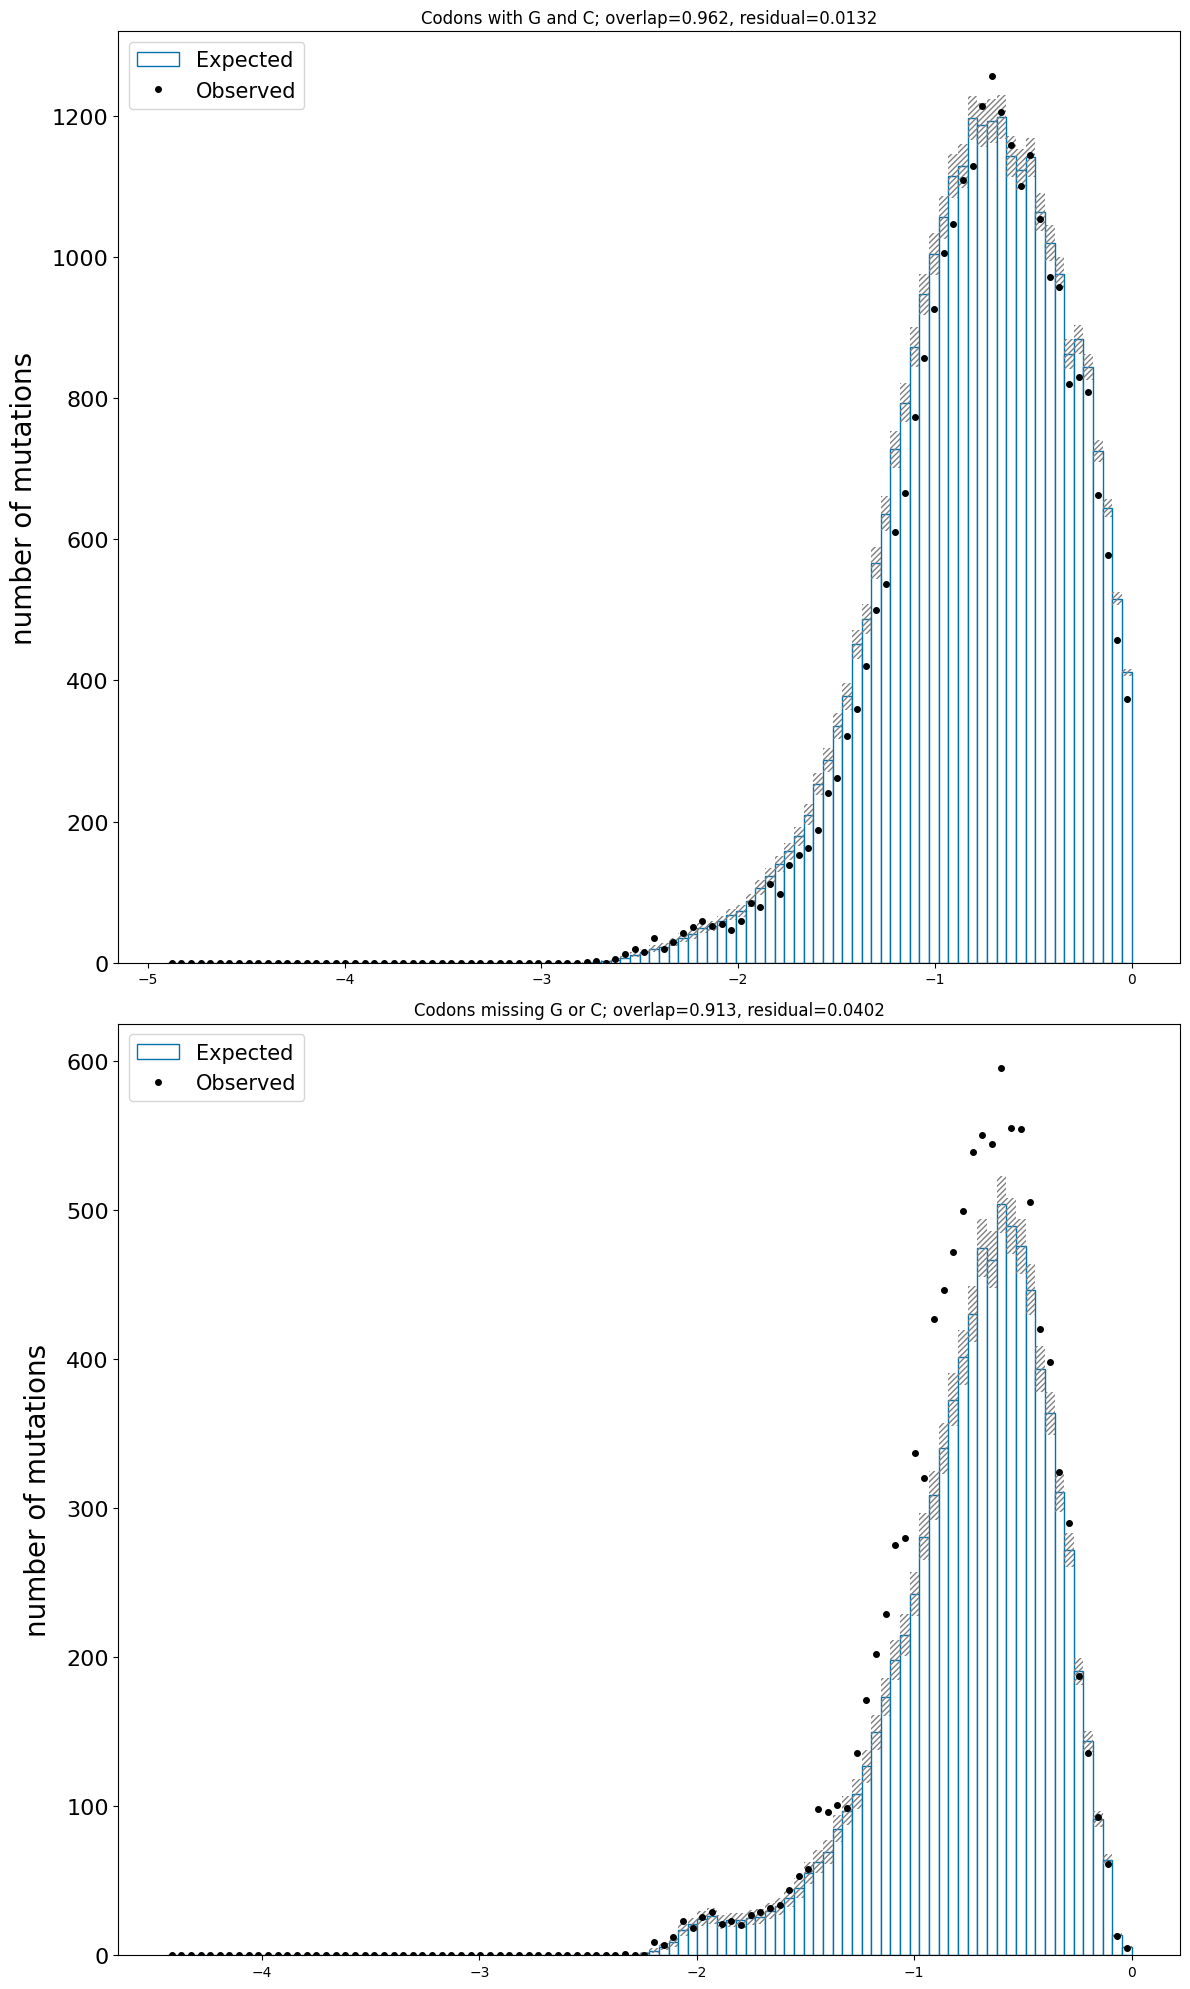

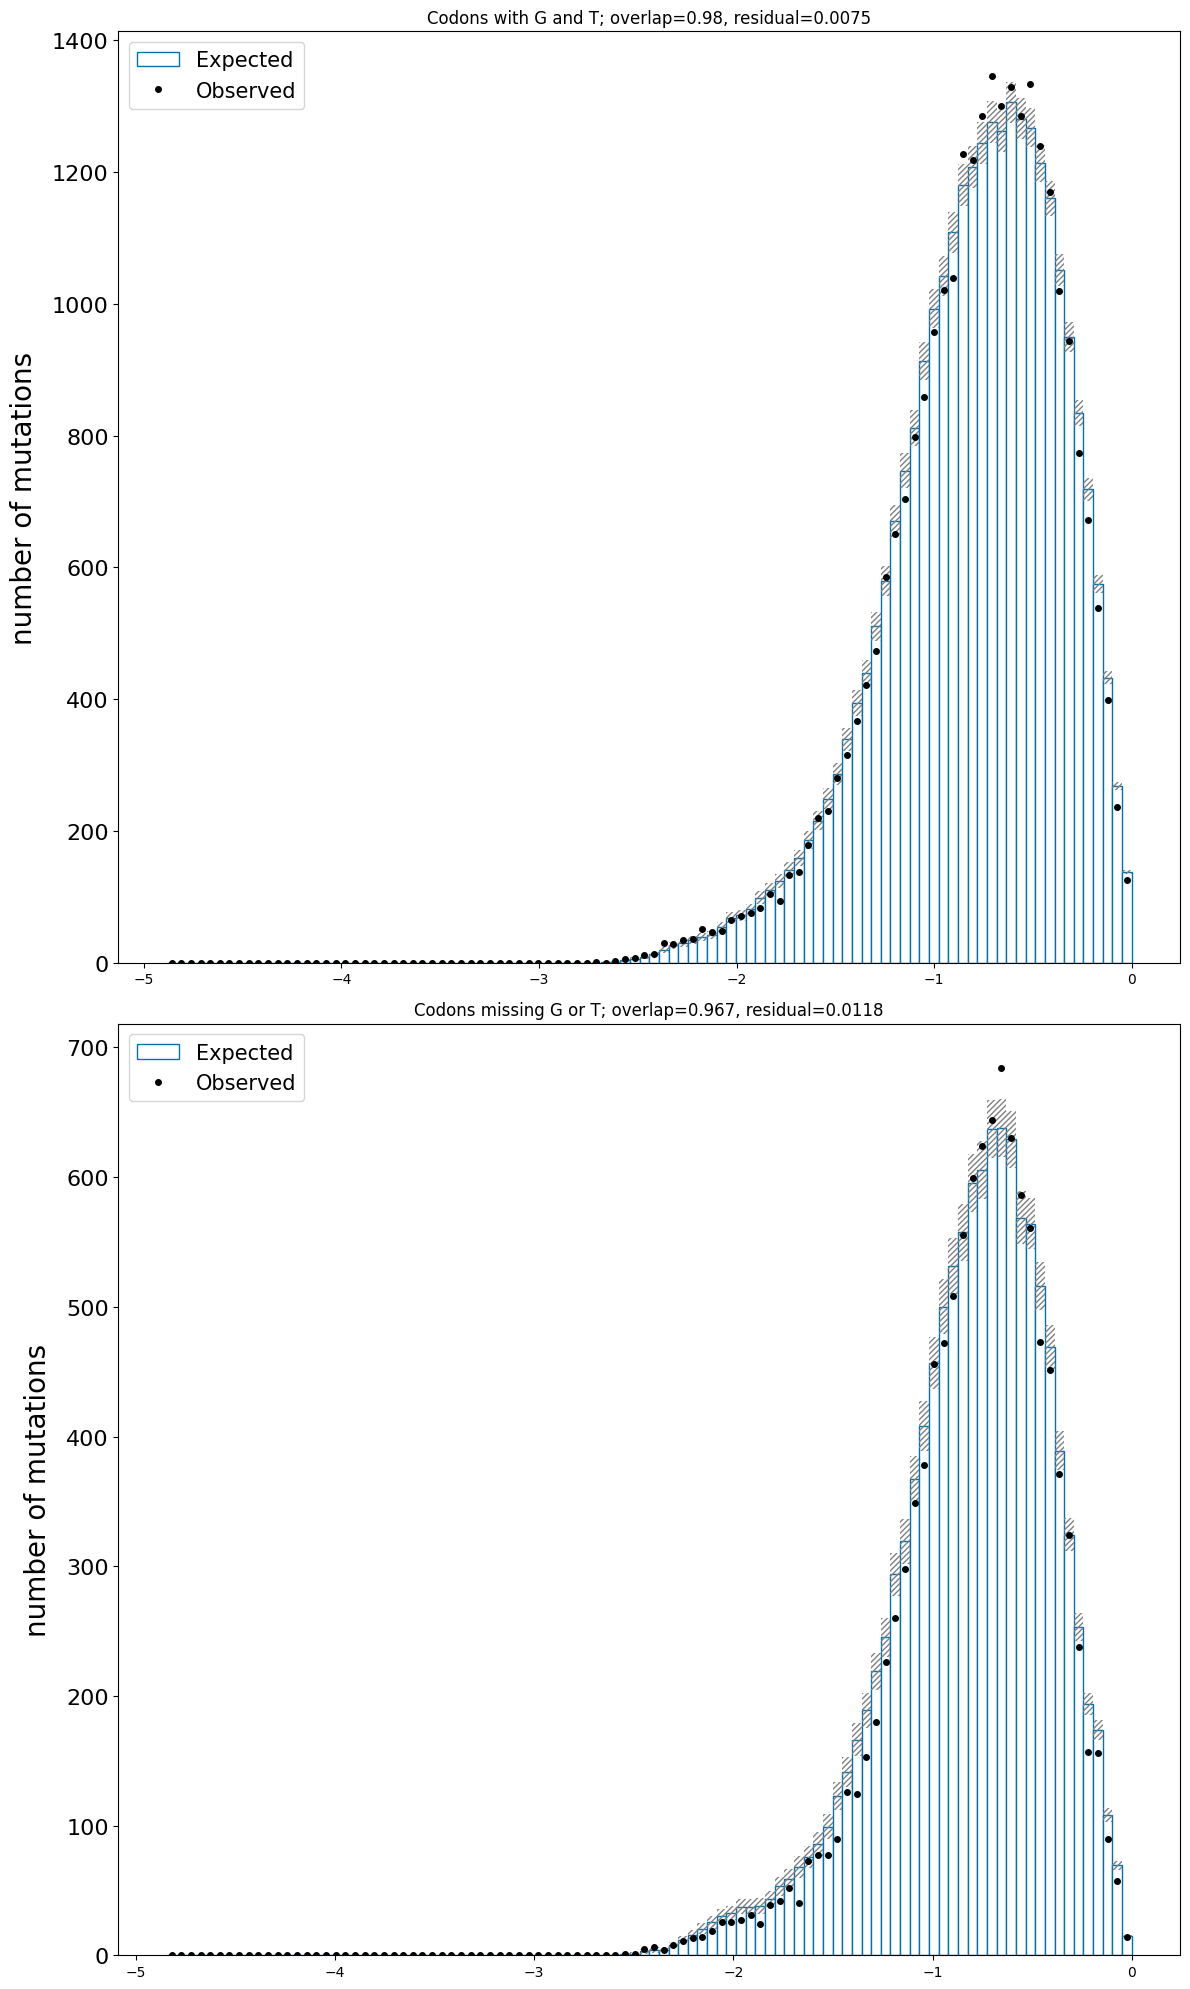

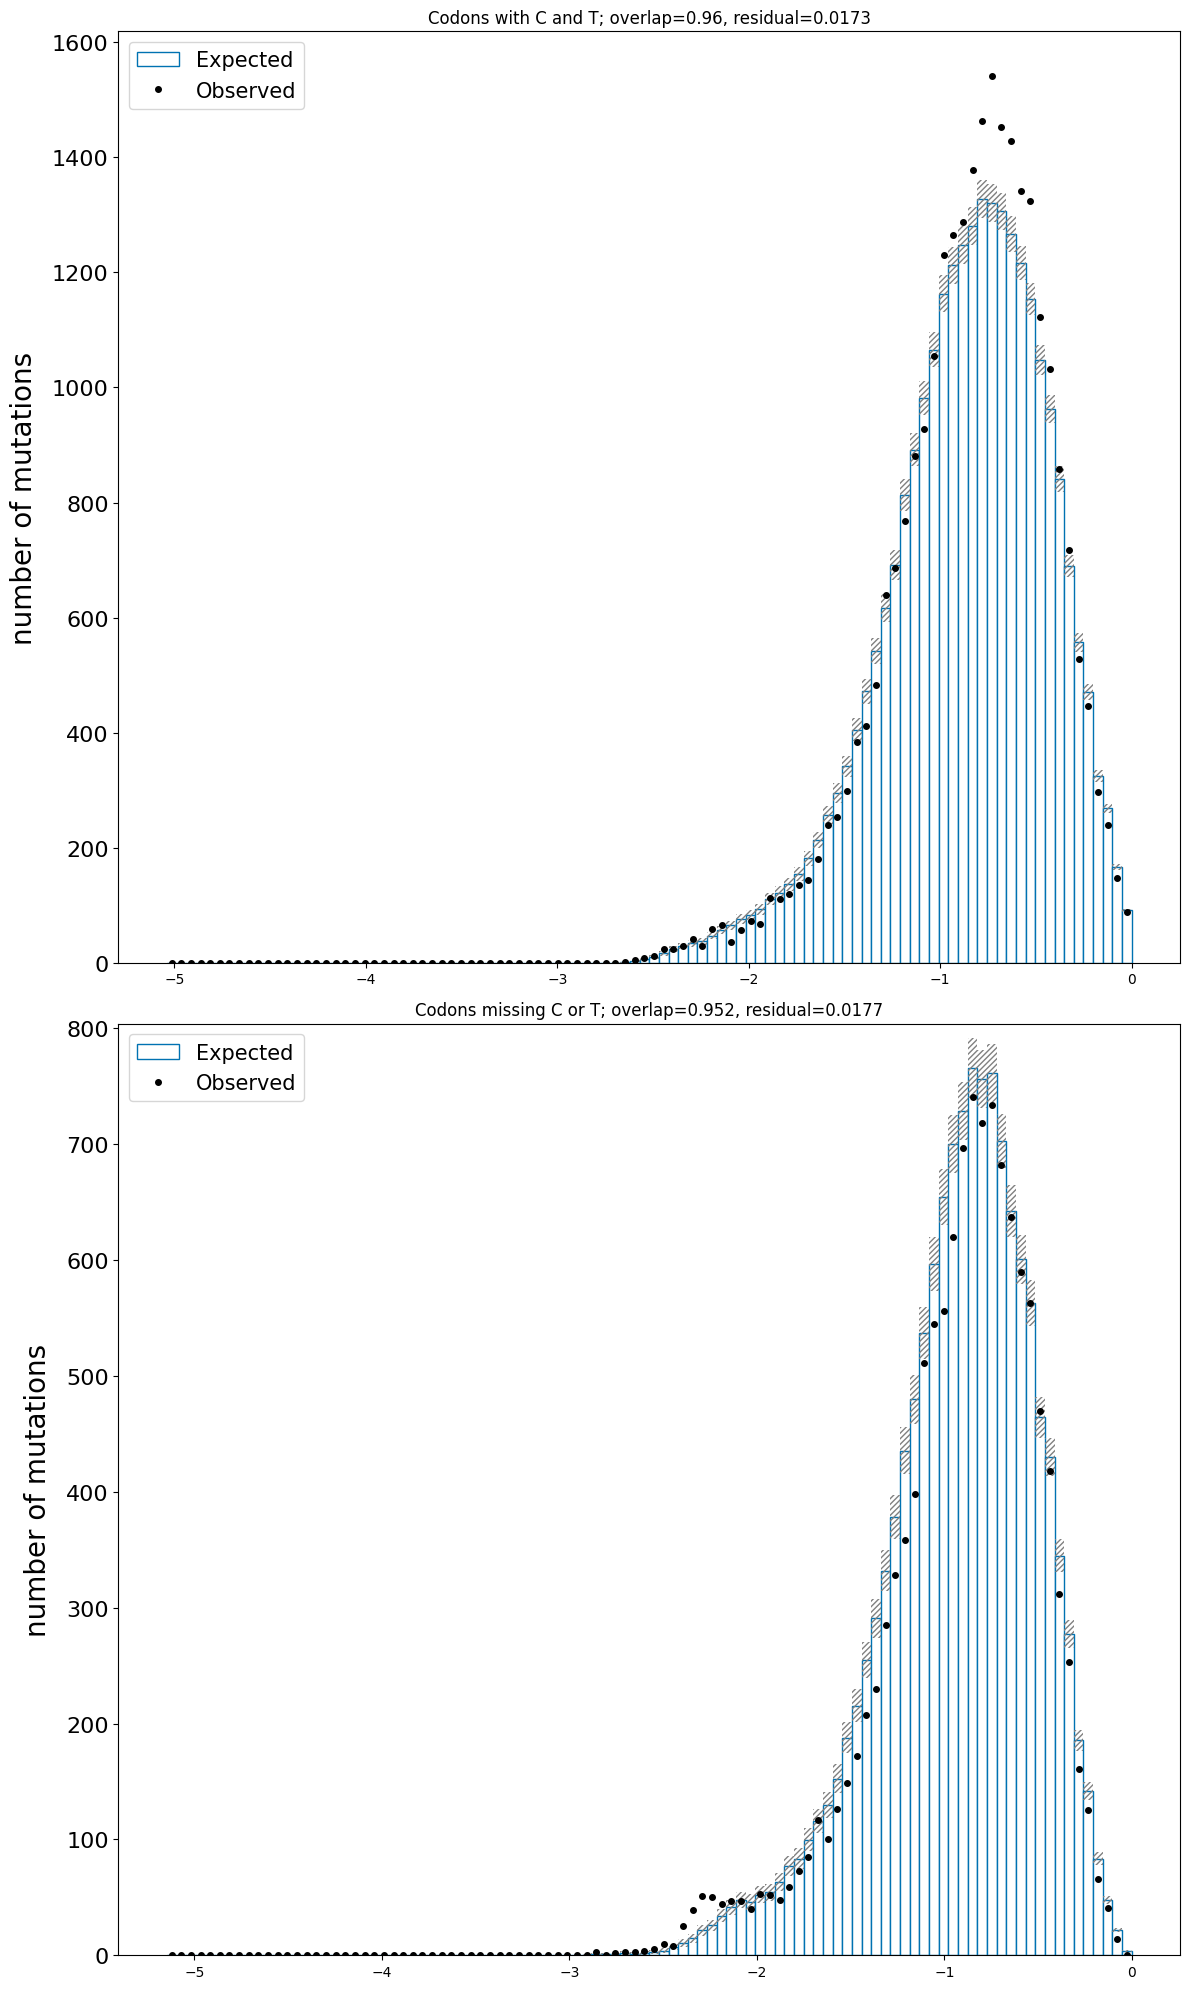

In [12]:
def oe_plot_of_hc_nt_site_df(hc_site_df, nts):
    """nts must contain two nucleotides. Stratifies by whether the parent codon contains both nts or is missing at least one of them"""
    fig, axs = plt.subplots(2, 1, figsize=(12, 20))

    true_df = hc_site_df[hc_site_df[f"contains_{nts[0]}"] & hc_site_df[f"contains_{nts[1]}"]]
    false_df = hc_site_df[~hc_site_df[f"contains_{nts[0]}"] & ~hc_site_df[f"contains_{nts[1]}"]]
    for cont_str, df, ax in zip([f"with {' and '.join(nts)}", f"missing {' or '.join(nts)}"], [true_df, false_df], axs):
        plot_df = pd.DataFrame({
            "mutation": df["hit_class"] > 0,
            "prob": 1 - df[f"0_hc_prob"],
        })
        
        result_dict = evaluation.plot_observed_vs_expected(plot_df, None, ax, None)
        ax.set_title(f"Codons {cont_str}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
    fig.tight_layout()
    return fig

figs = [oe_plot_of_hc_nt_site_df(hc_site_df, nts) for nts in combinations("AGCT", 2)]
# Save figs to a single multi-page pdf, one plot per page

In [13]:

with PdfPages("two_base_oe_plots.pdf") as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close(fig)

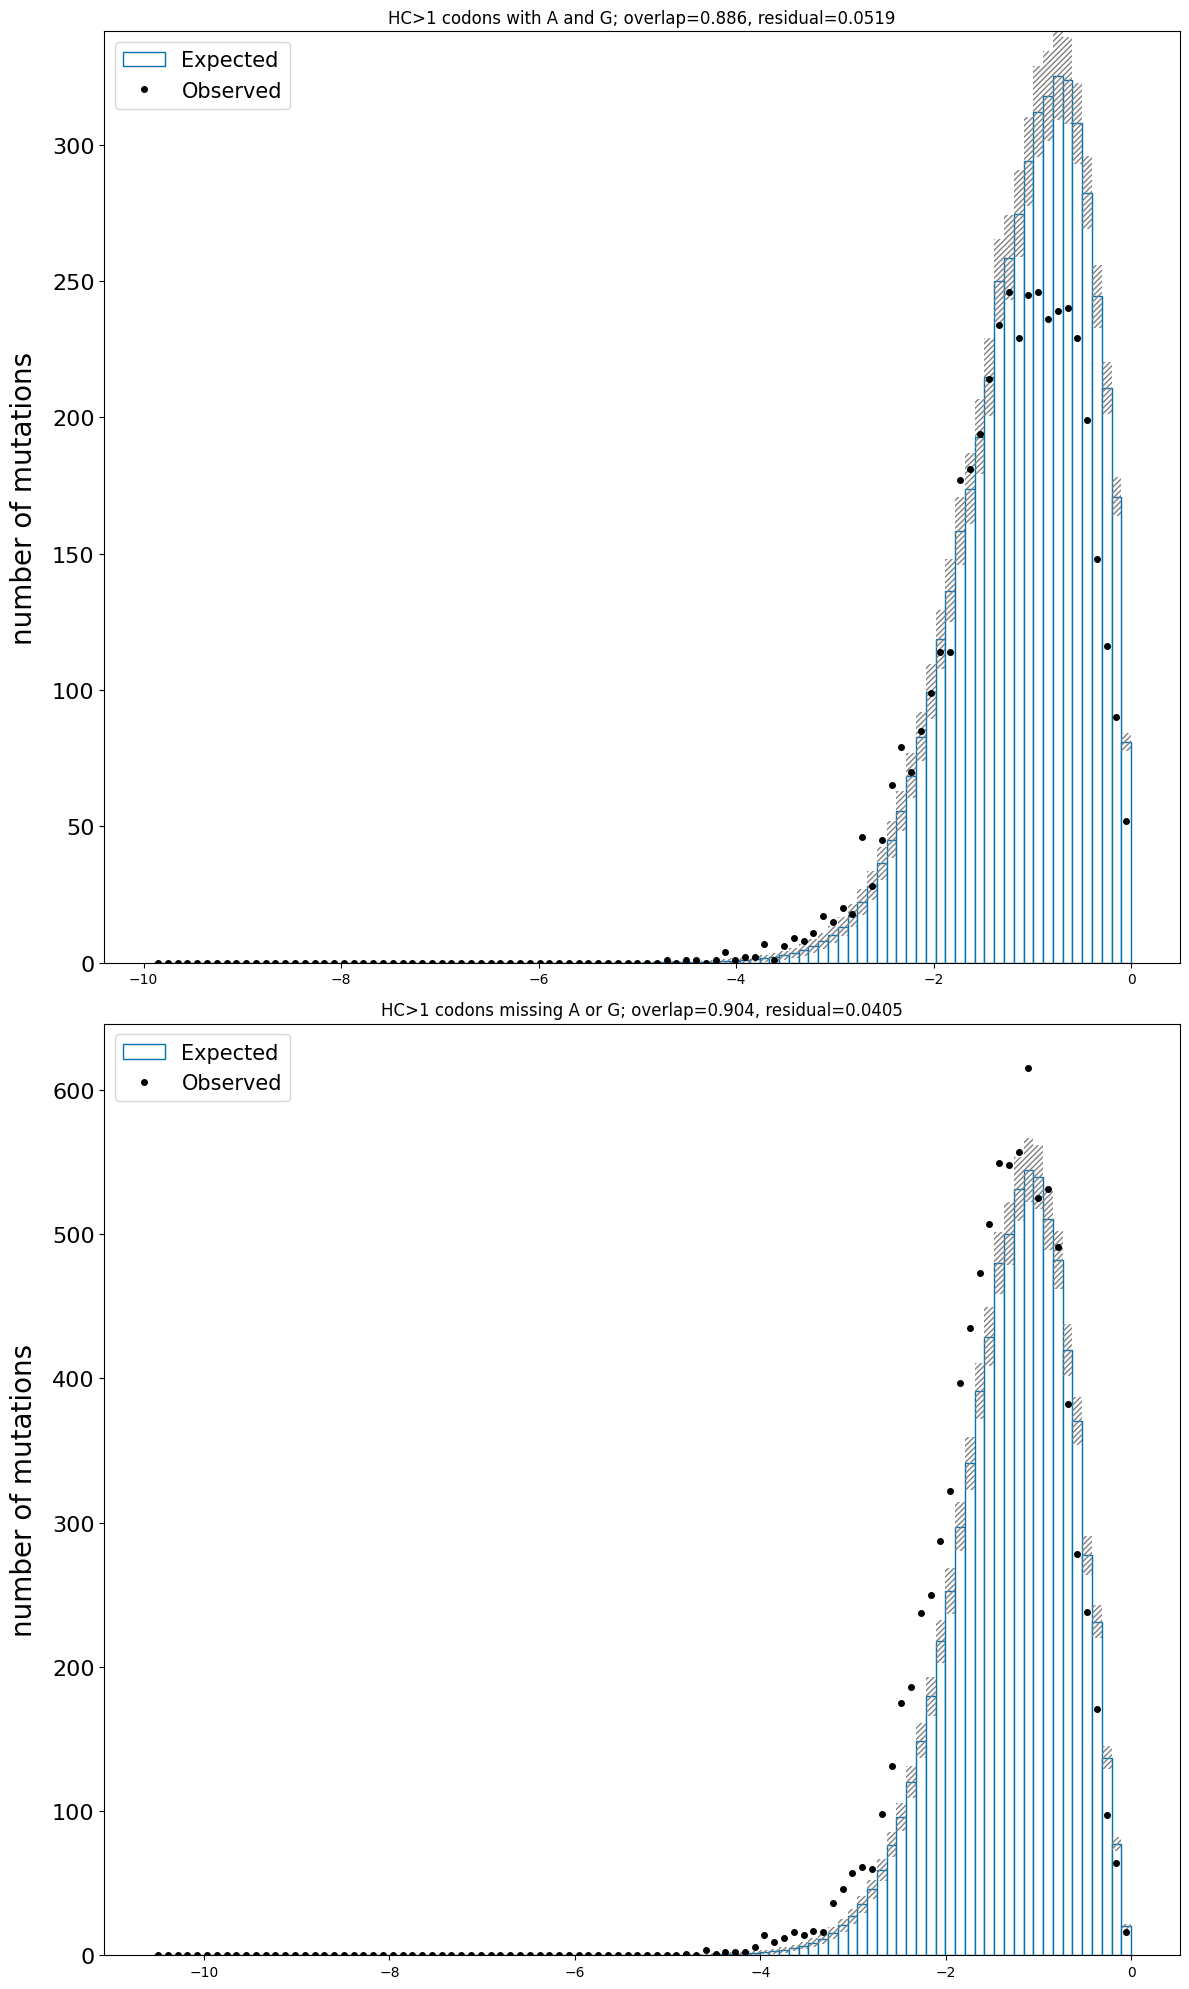

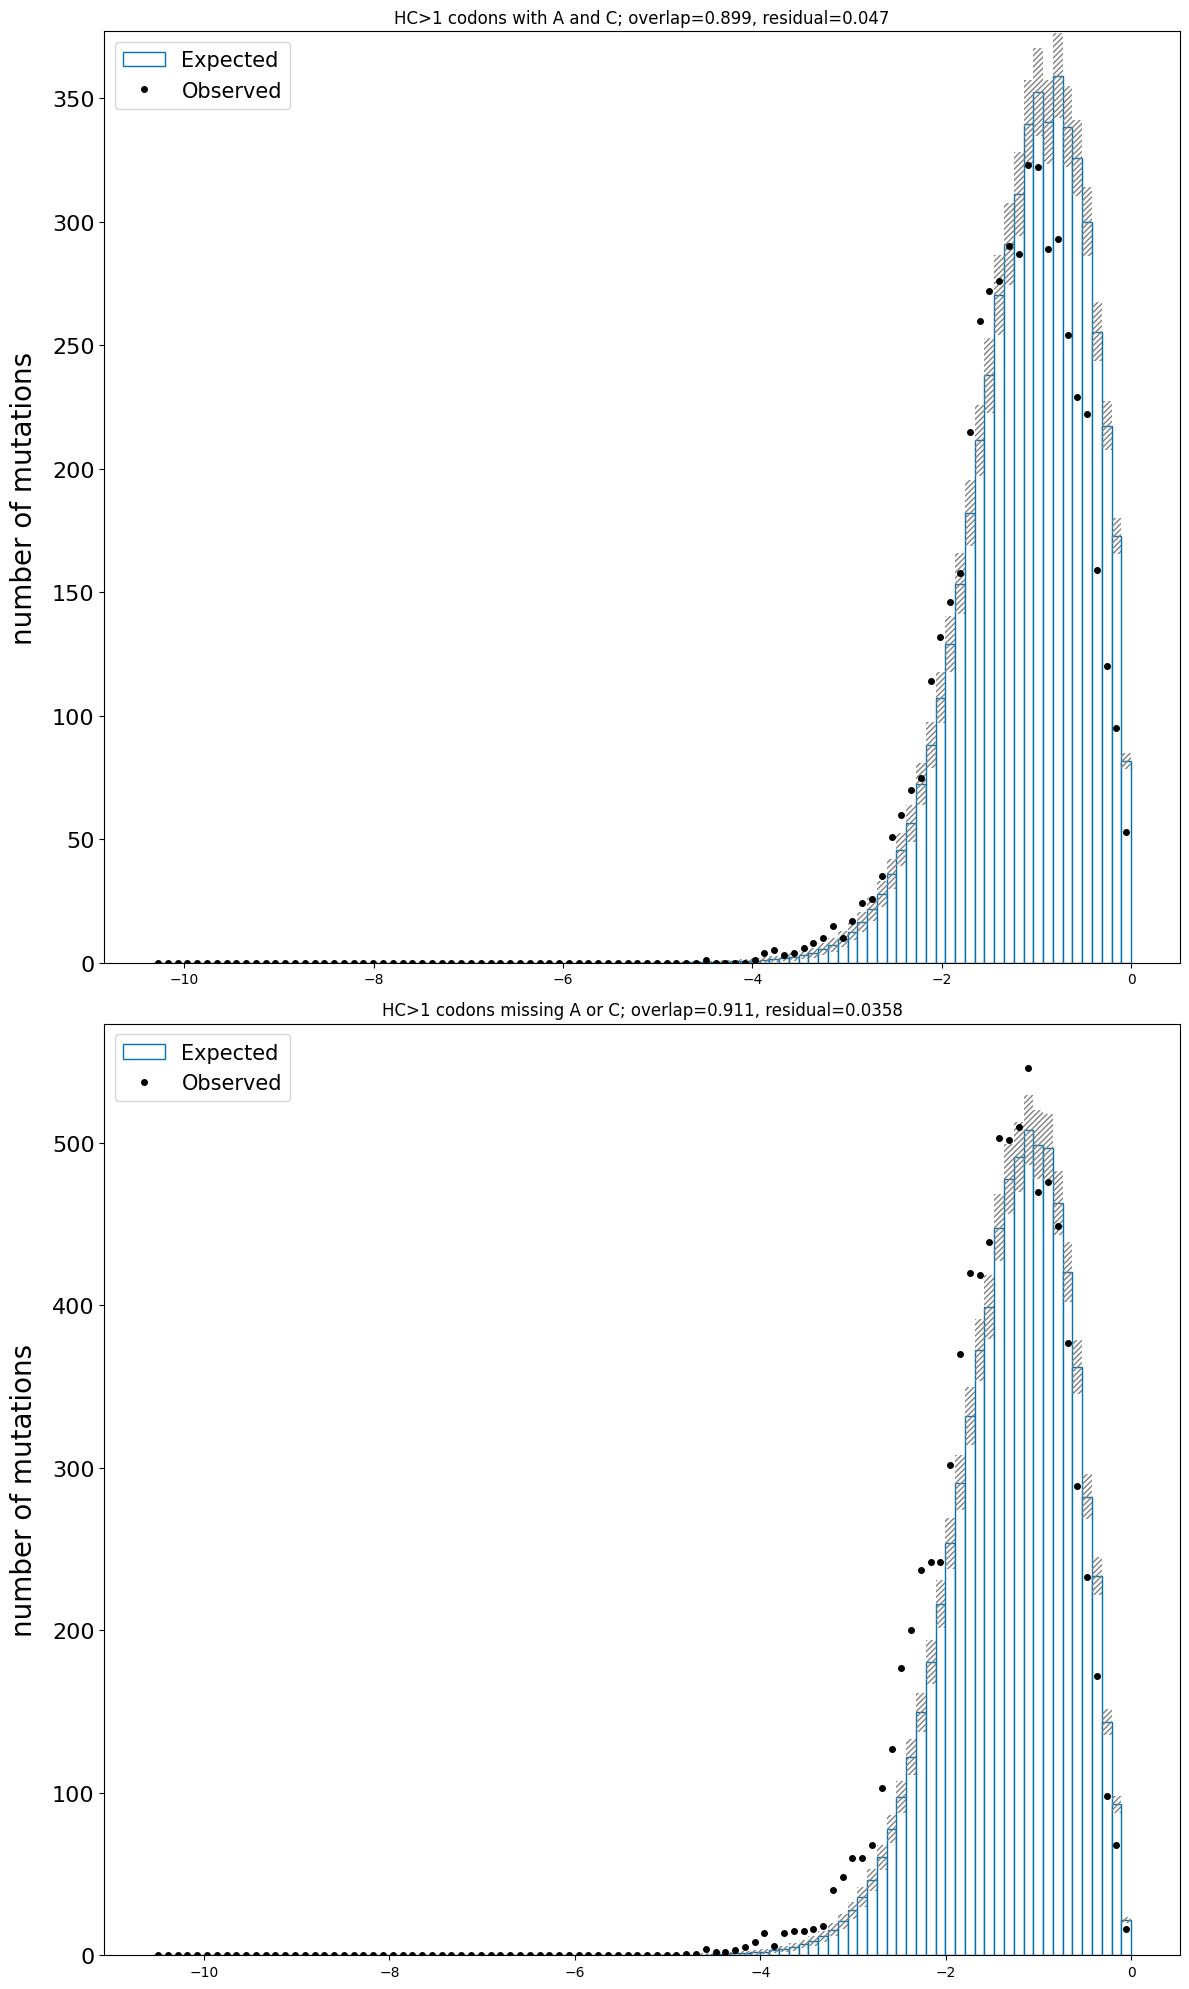

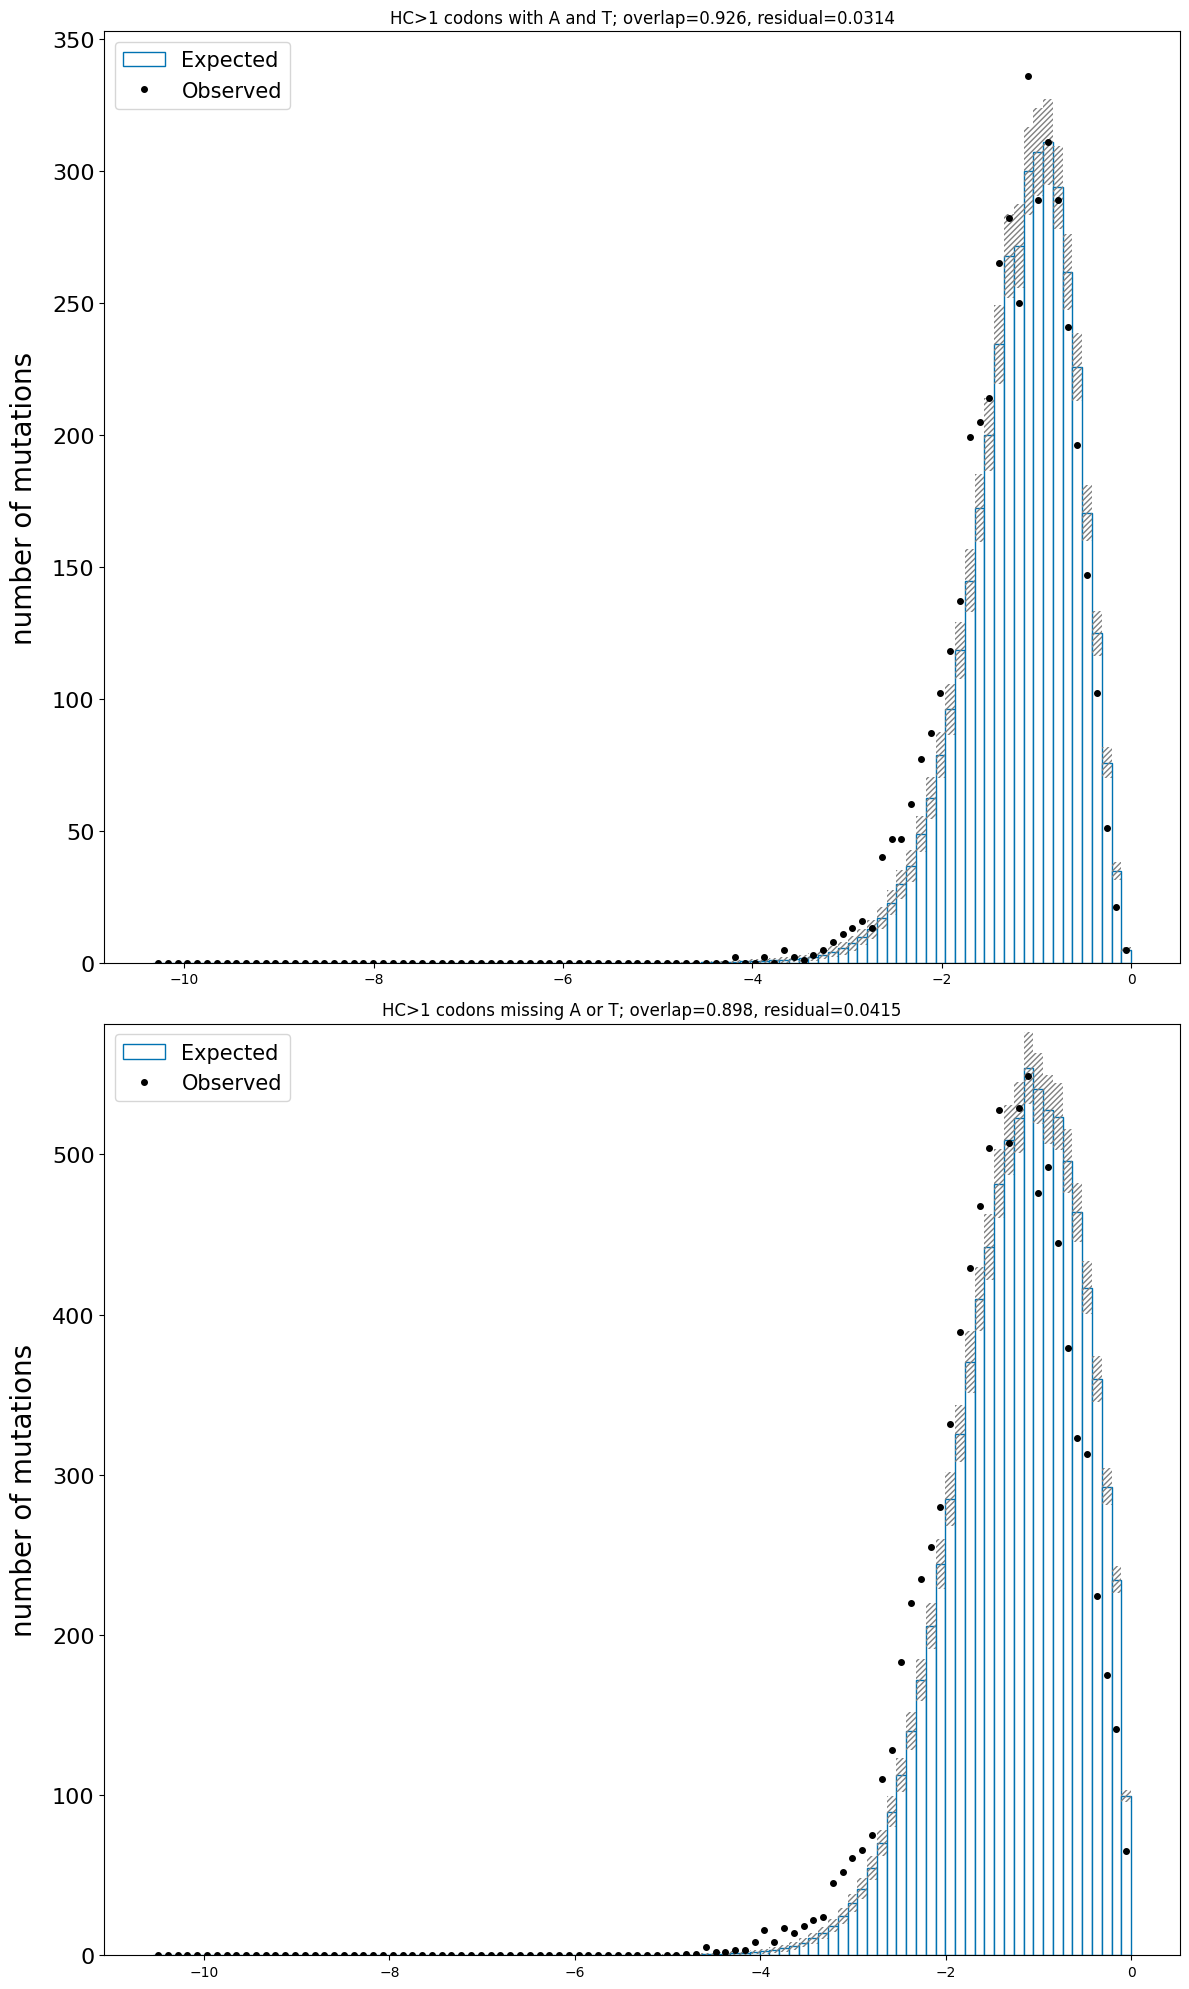

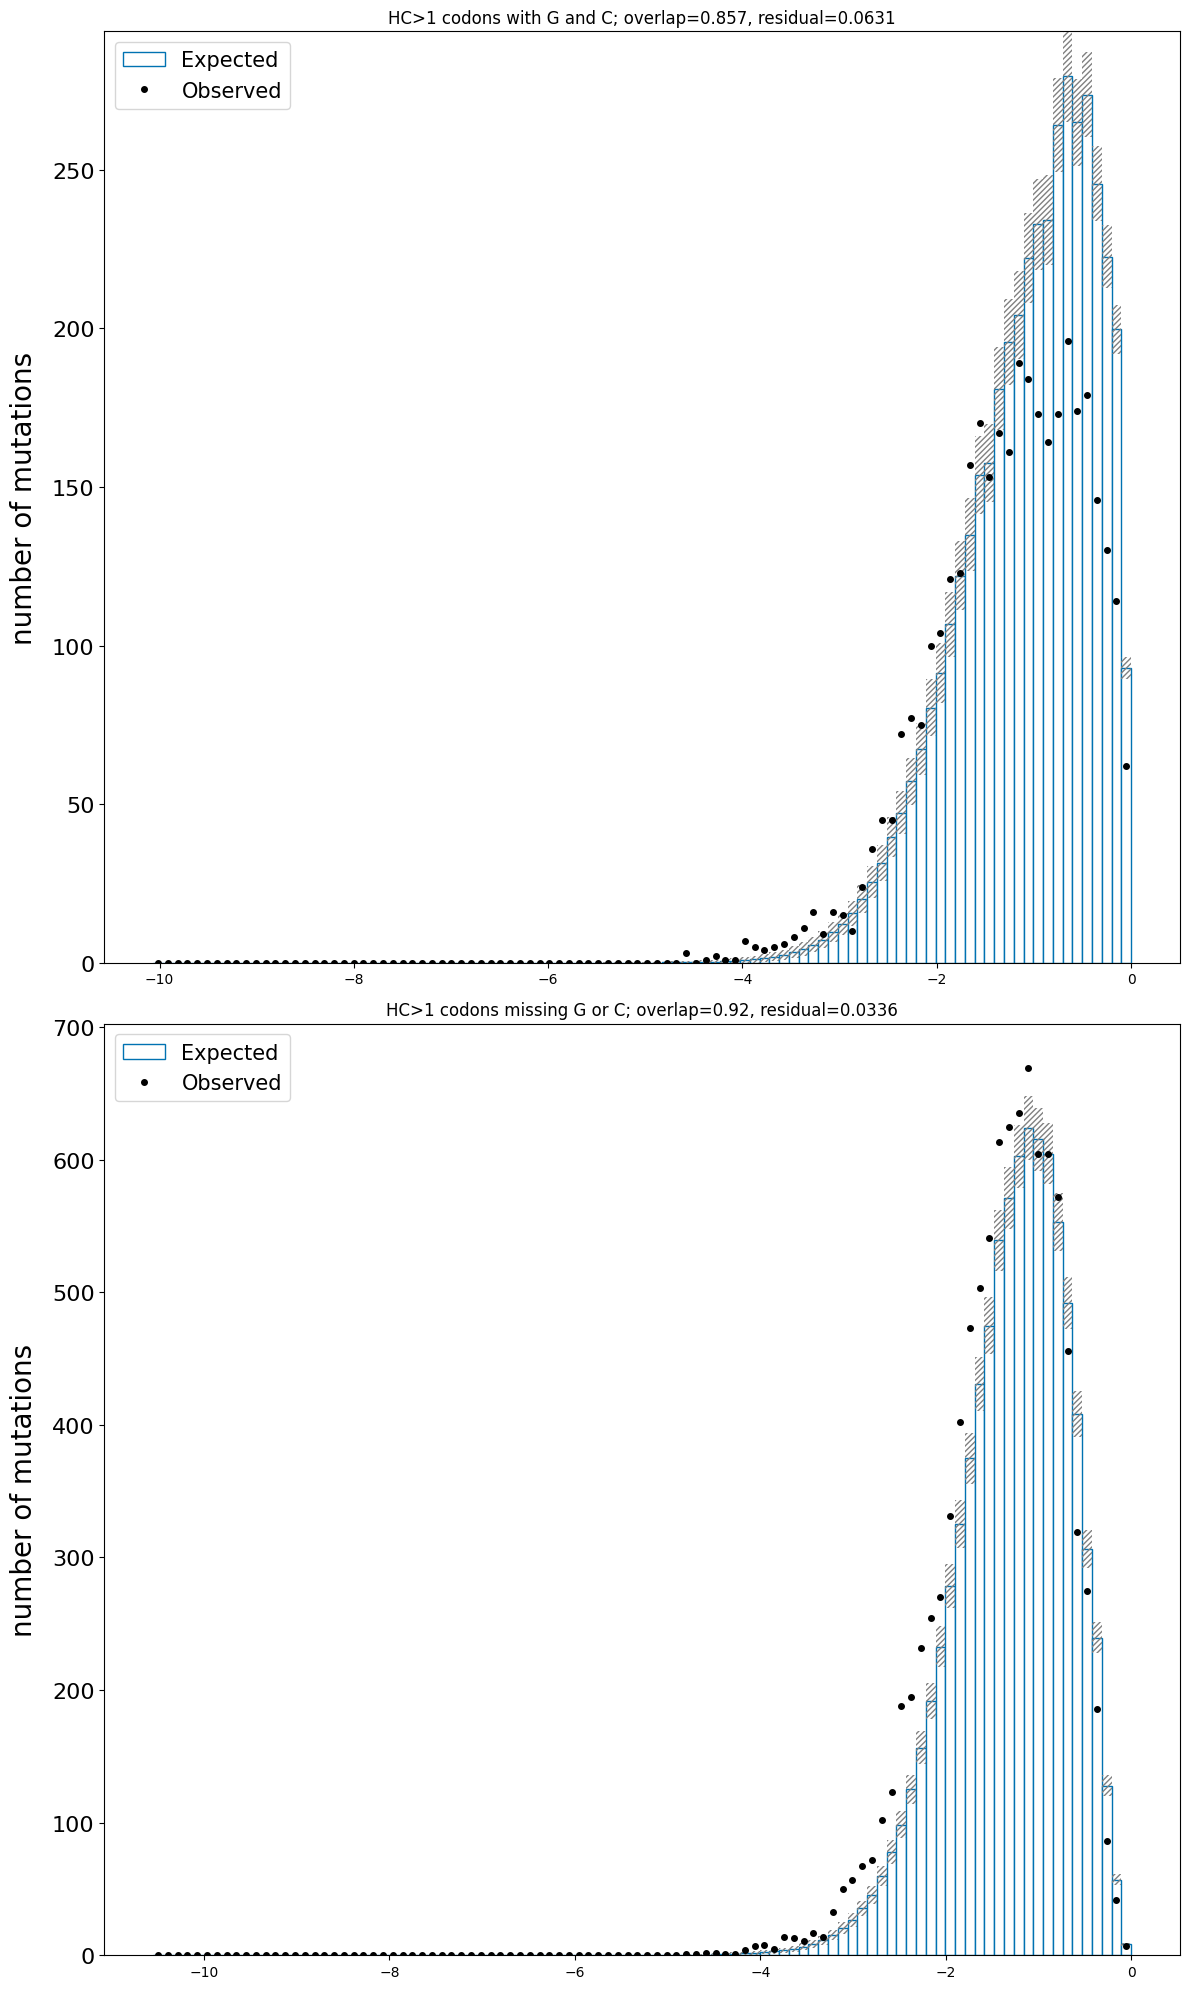

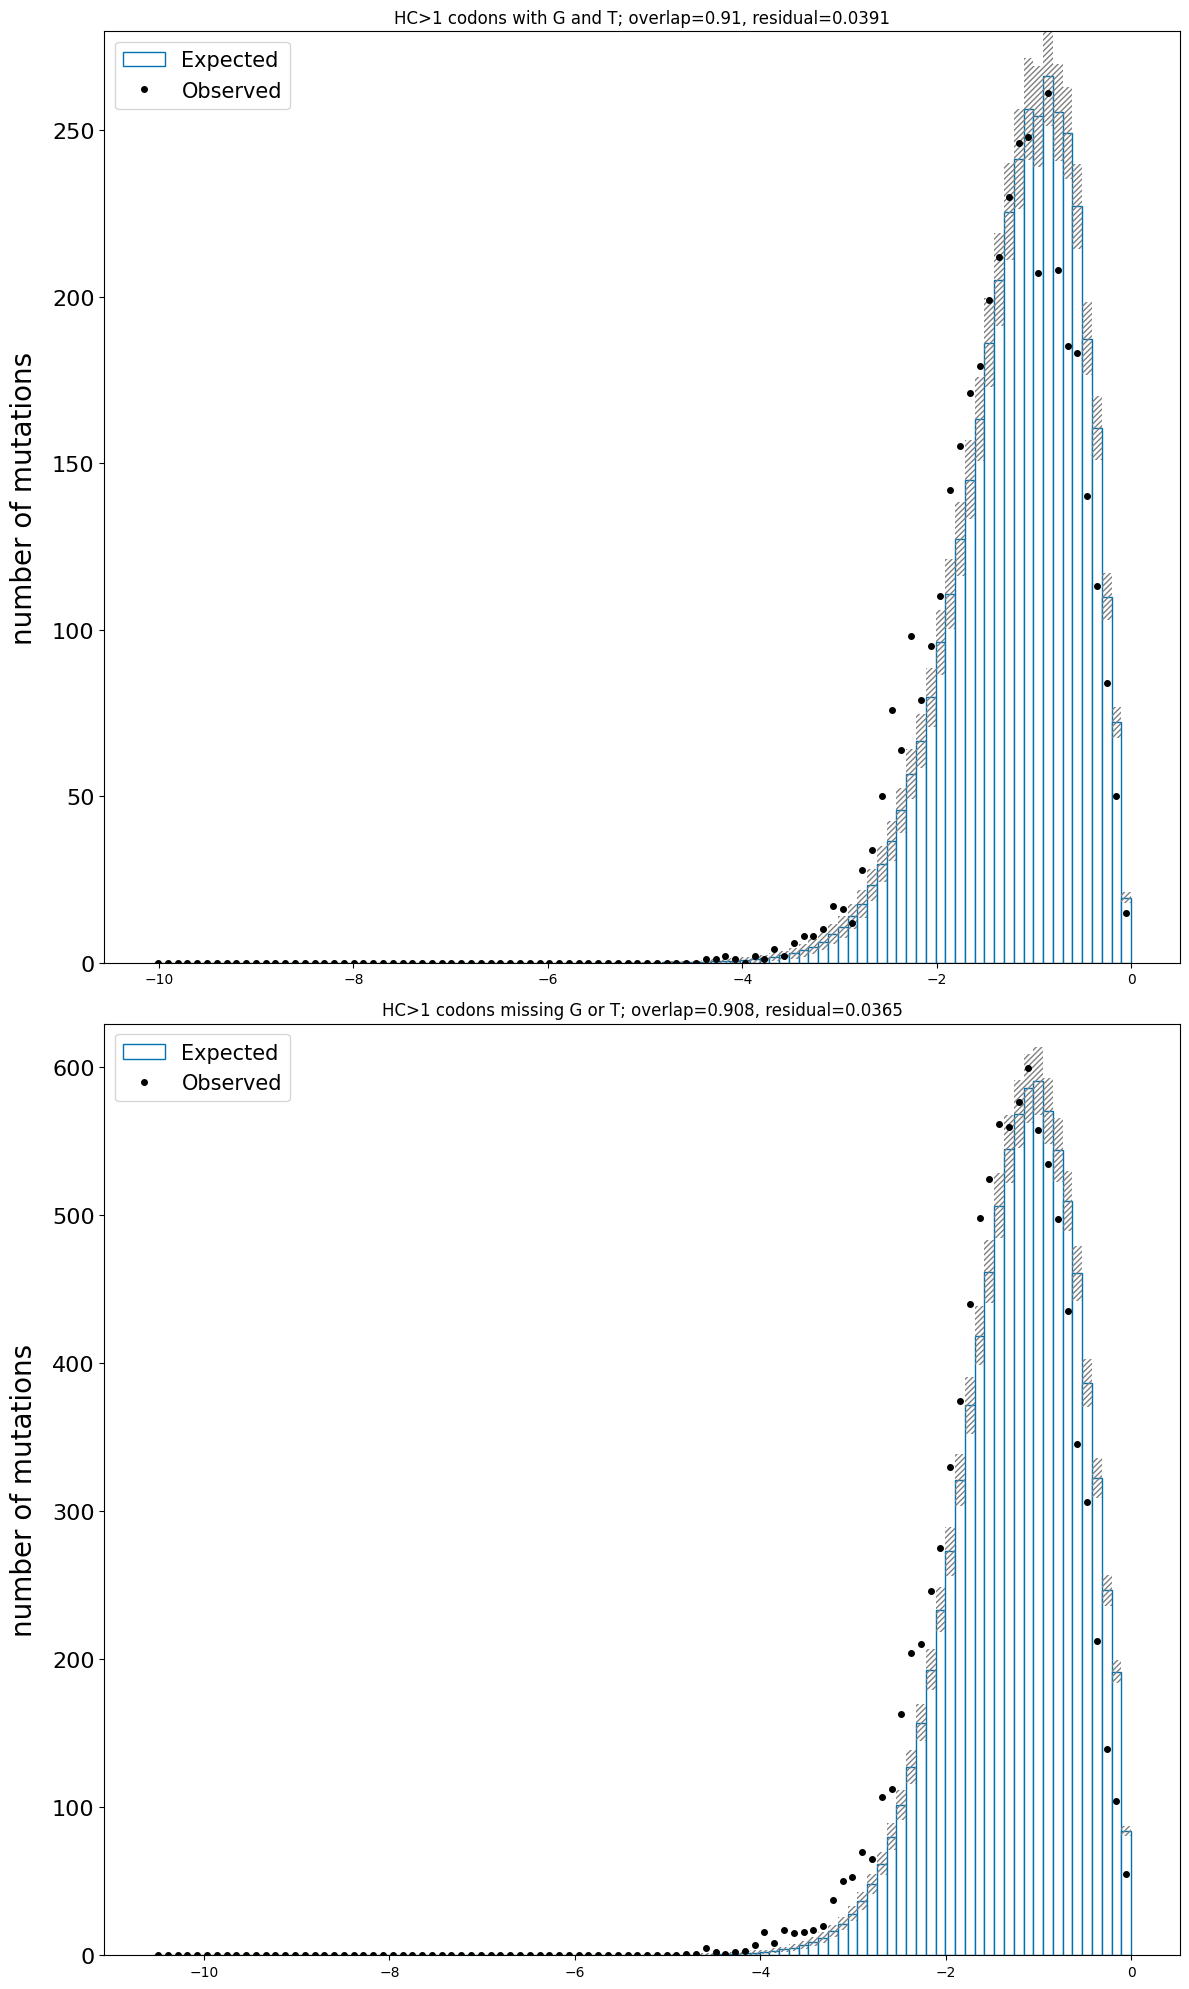

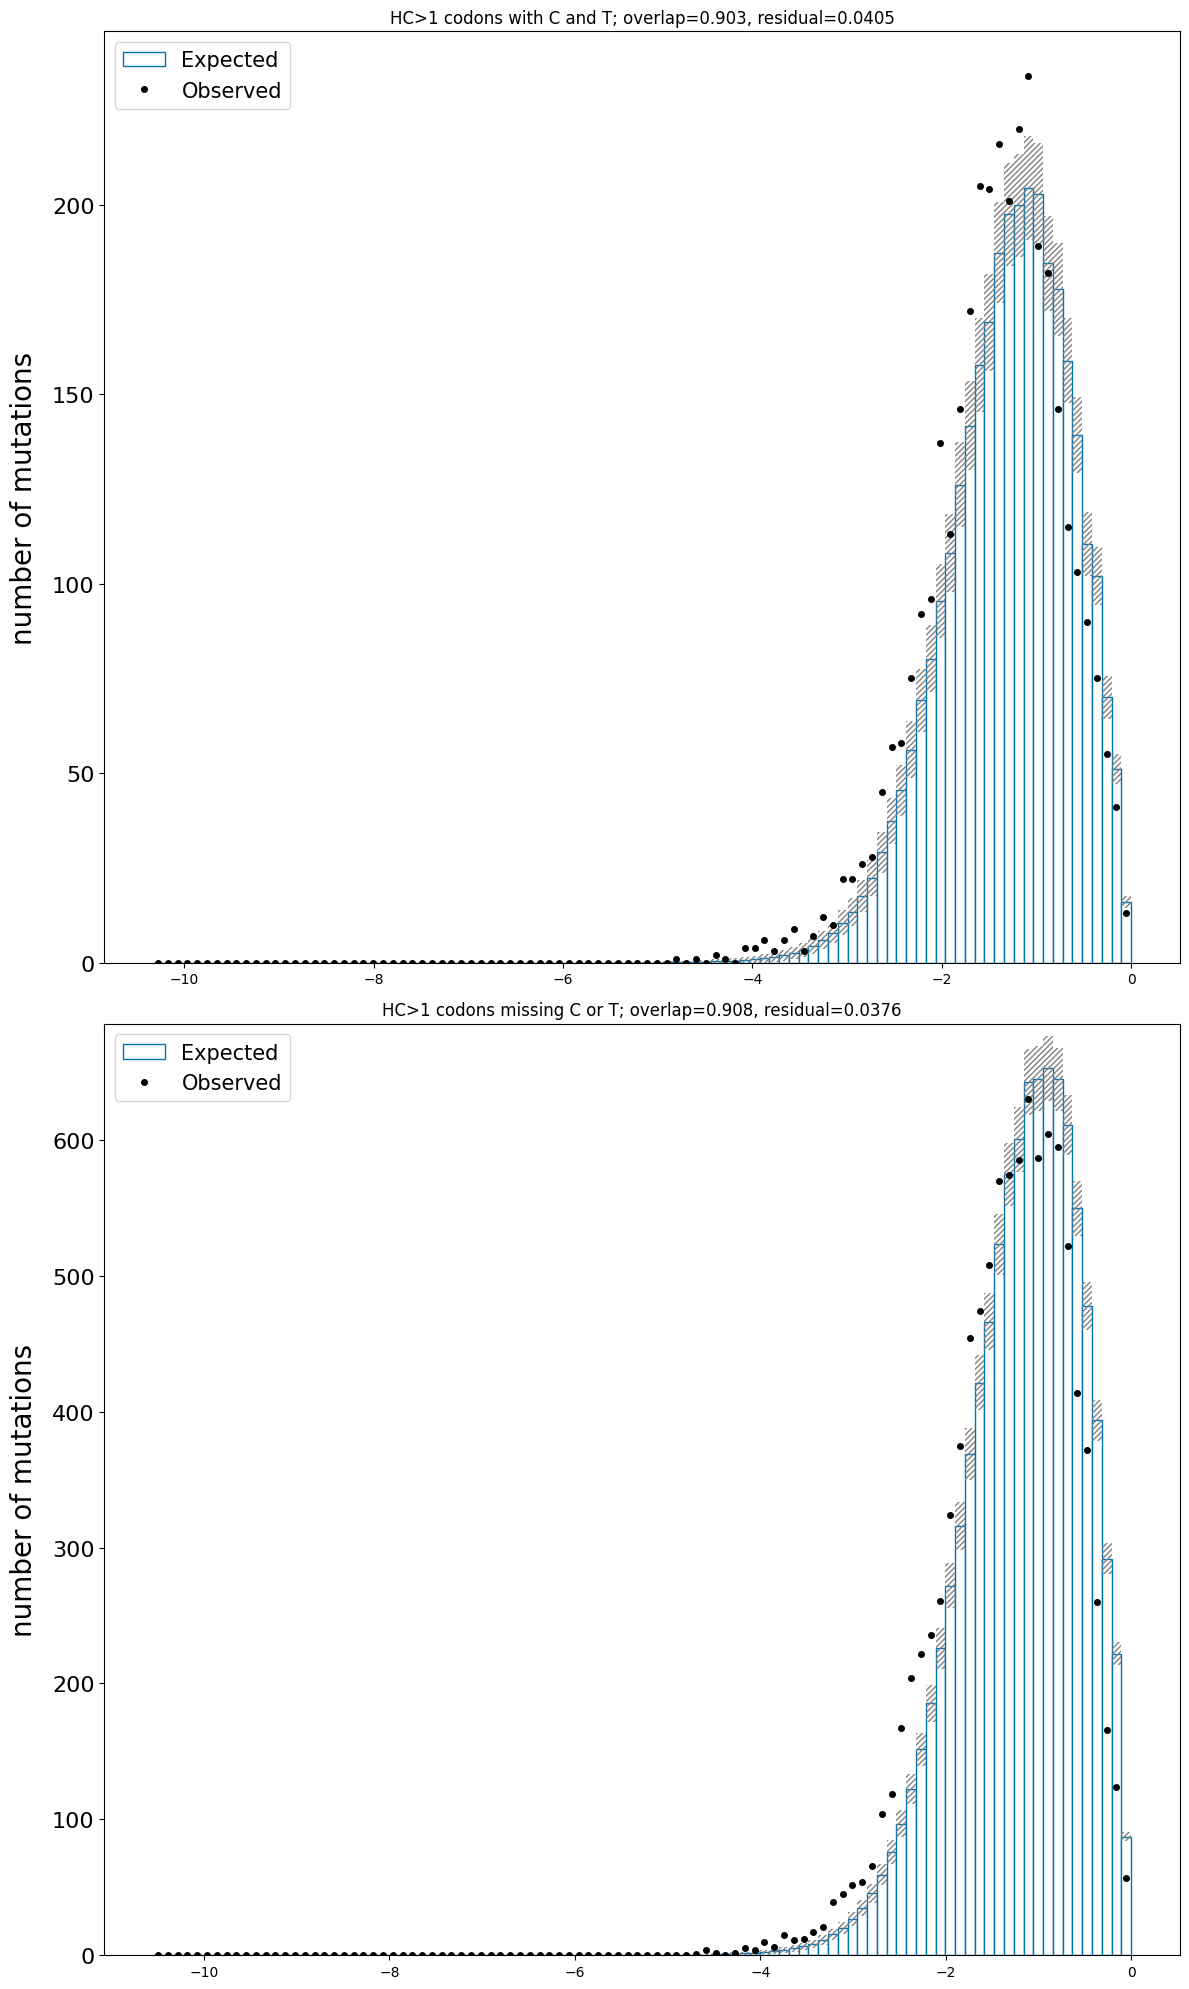

In [14]:

def oe_plot_of_hc_2p_nt_site_df(hc_site_df, nts):
    """Stratifies by whether parent codon contains both nts, and only looks at hit class 2+ codons.
    nts must contain two nucleotides"""
    fig, axs = plt.subplots(2, 1, figsize=(12, 20))

    true_df = hc_site_df[hc_site_df[f"contains_{nts[0]}"] & hc_site_df[f"contains_{nts[1]}"]]
    false_df = hc_site_df[~(hc_site_df[f"contains_{nts[0]}"] & hc_site_df[f"contains_{nts[1]}"])]
    for cont_str, df, ax in zip([f"with {' and '.join(nts)}", f"missing {' or '.join(nts)}"], [true_df, false_df], axs):
        plot_df = pd.DataFrame({
            "mutation": df["hit_class"] > 1,
            "prob": df[f"2_hc_prob"] + df[f"3_hc_prob"],
        })
        
        result_dict = evaluation.plot_observed_vs_expected(plot_df, None, ax, None)
        ax.set_title(f"HC>1 codons {cont_str}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
    fig.tight_layout()
    return fig

figs = [oe_plot_of_hc_2p_nt_site_df(hc_site_df, nts) for nts in combinations("AGCT", 2)]
# Save figs to a single multi-page pdf, one plot per page
# Import PdfPages

In [15]:
with PdfPages("two_base_oe_plots_hc_2p.pdf") as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close(fig)

Now let's look only at the combinations that show the most difference in Thayer's plots: G and C one site apart, and maybe GA, and TA, and GT.

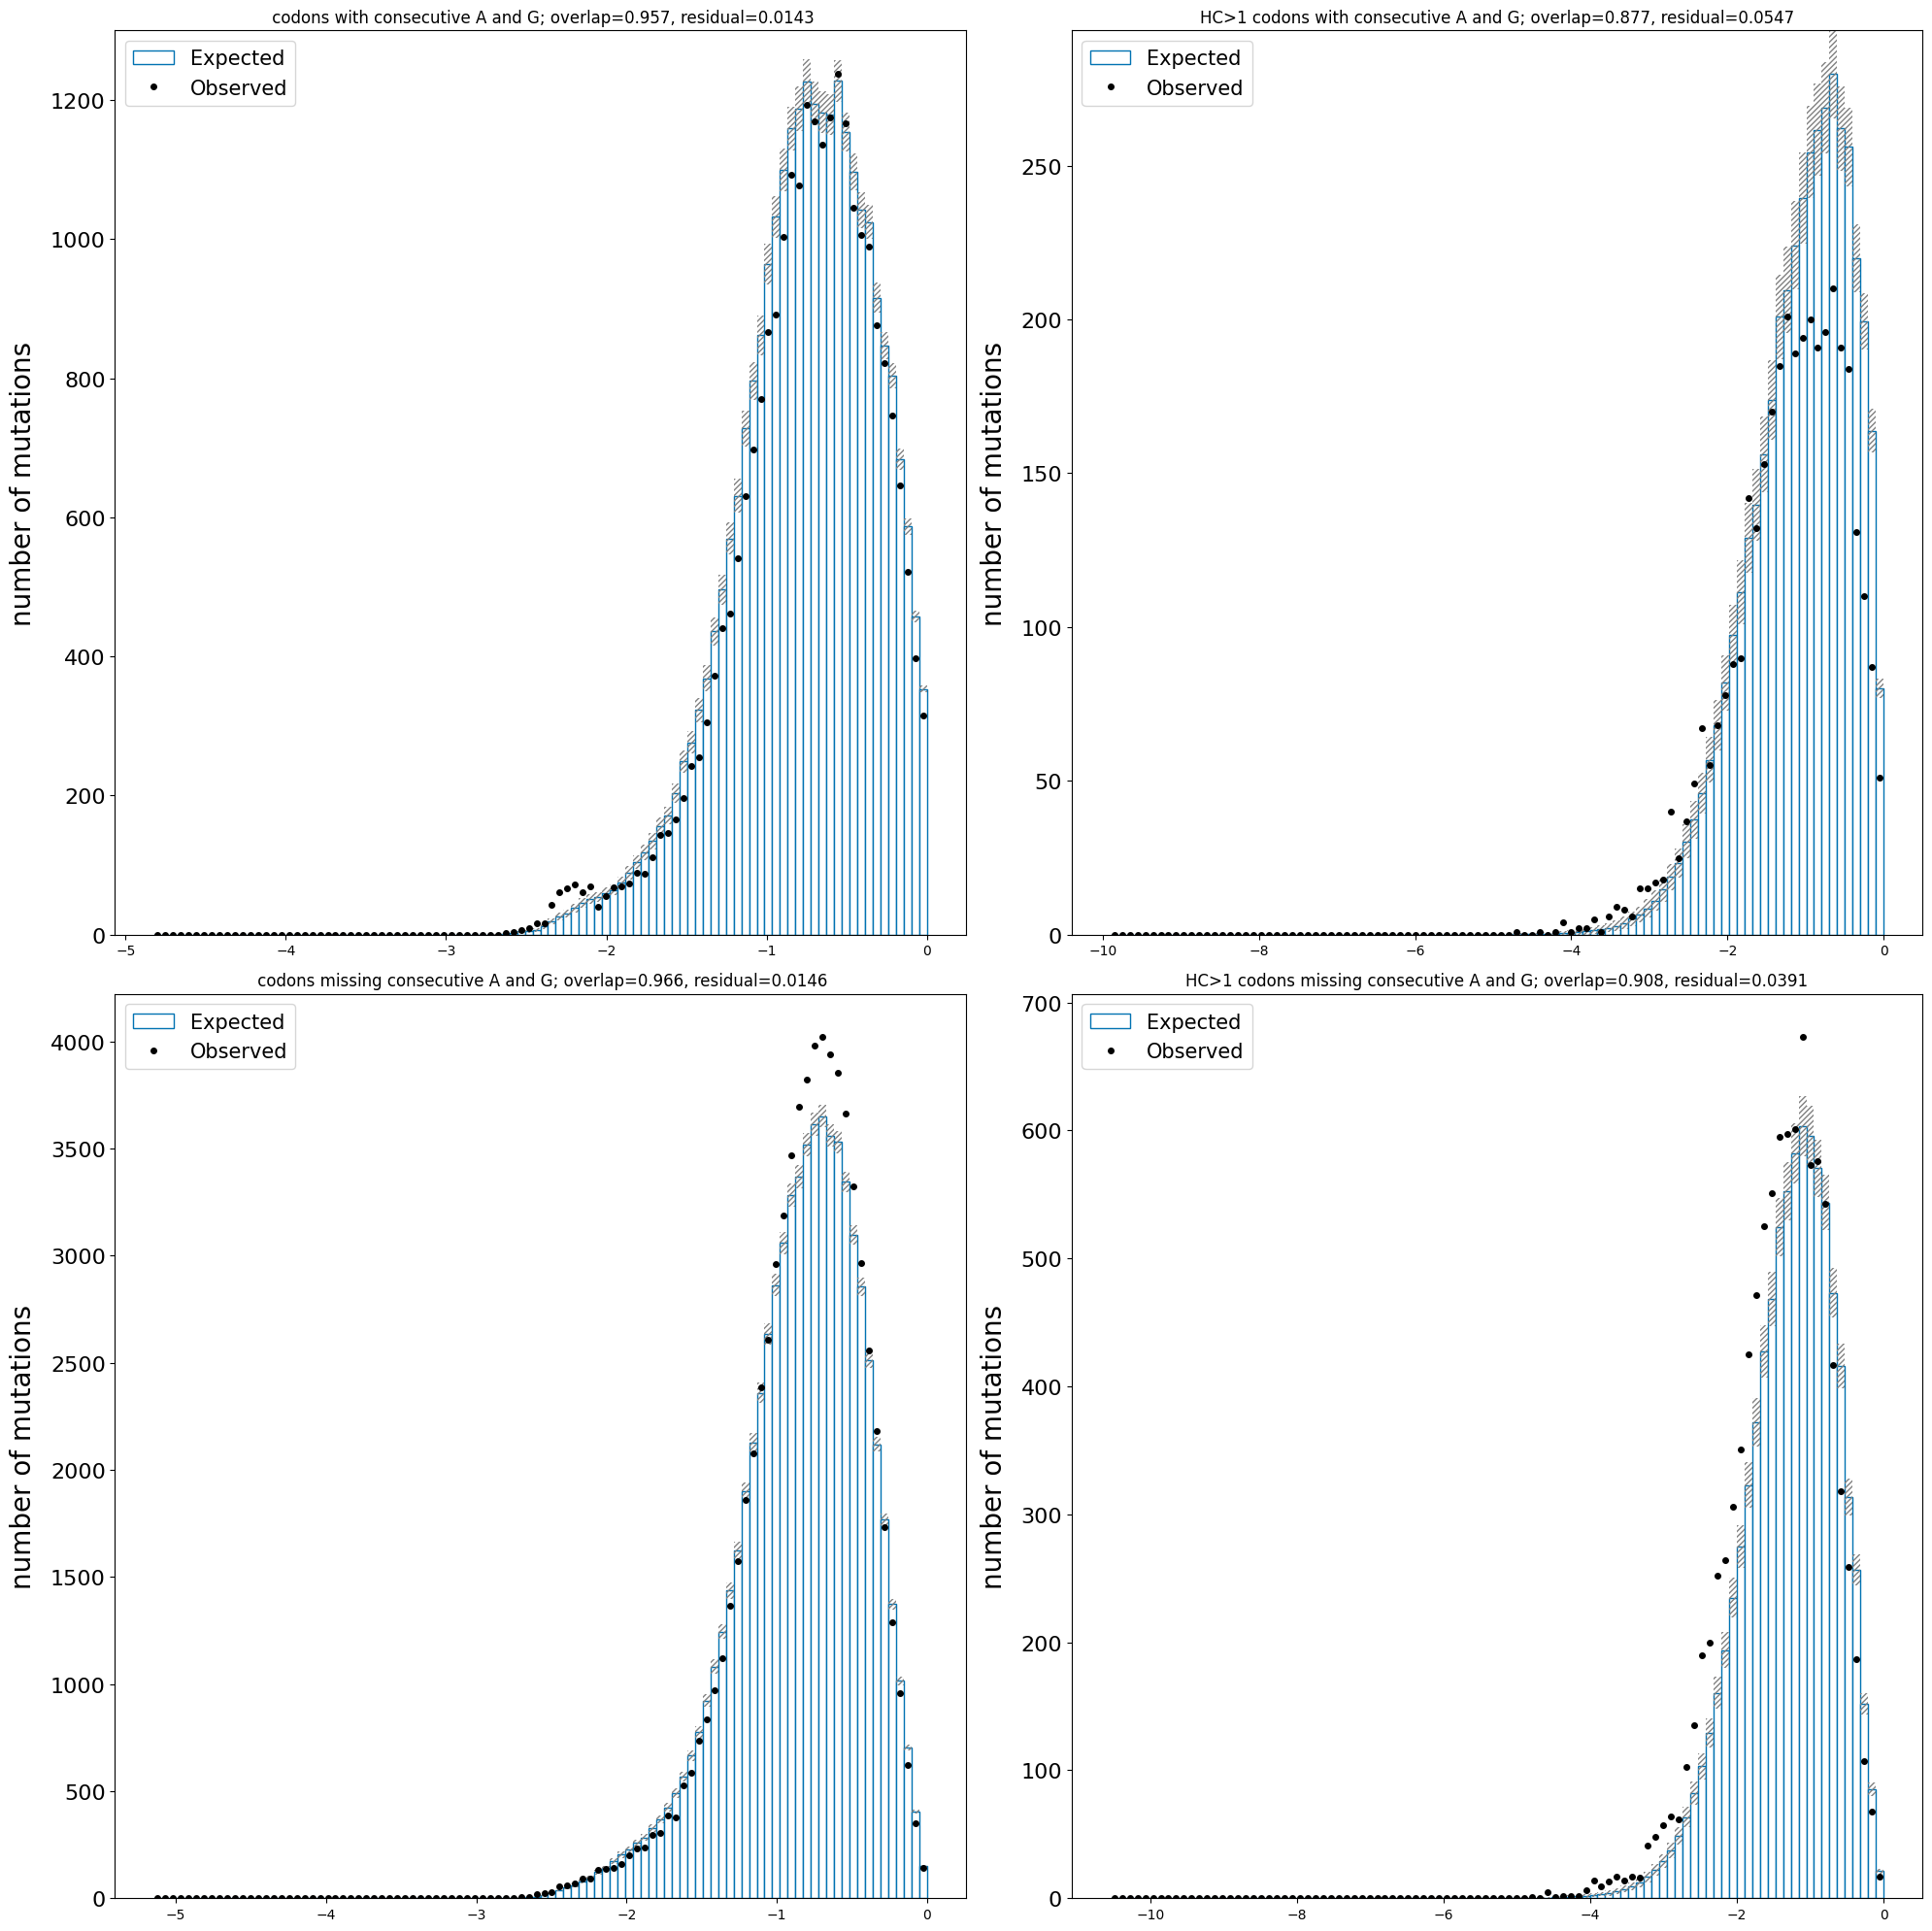

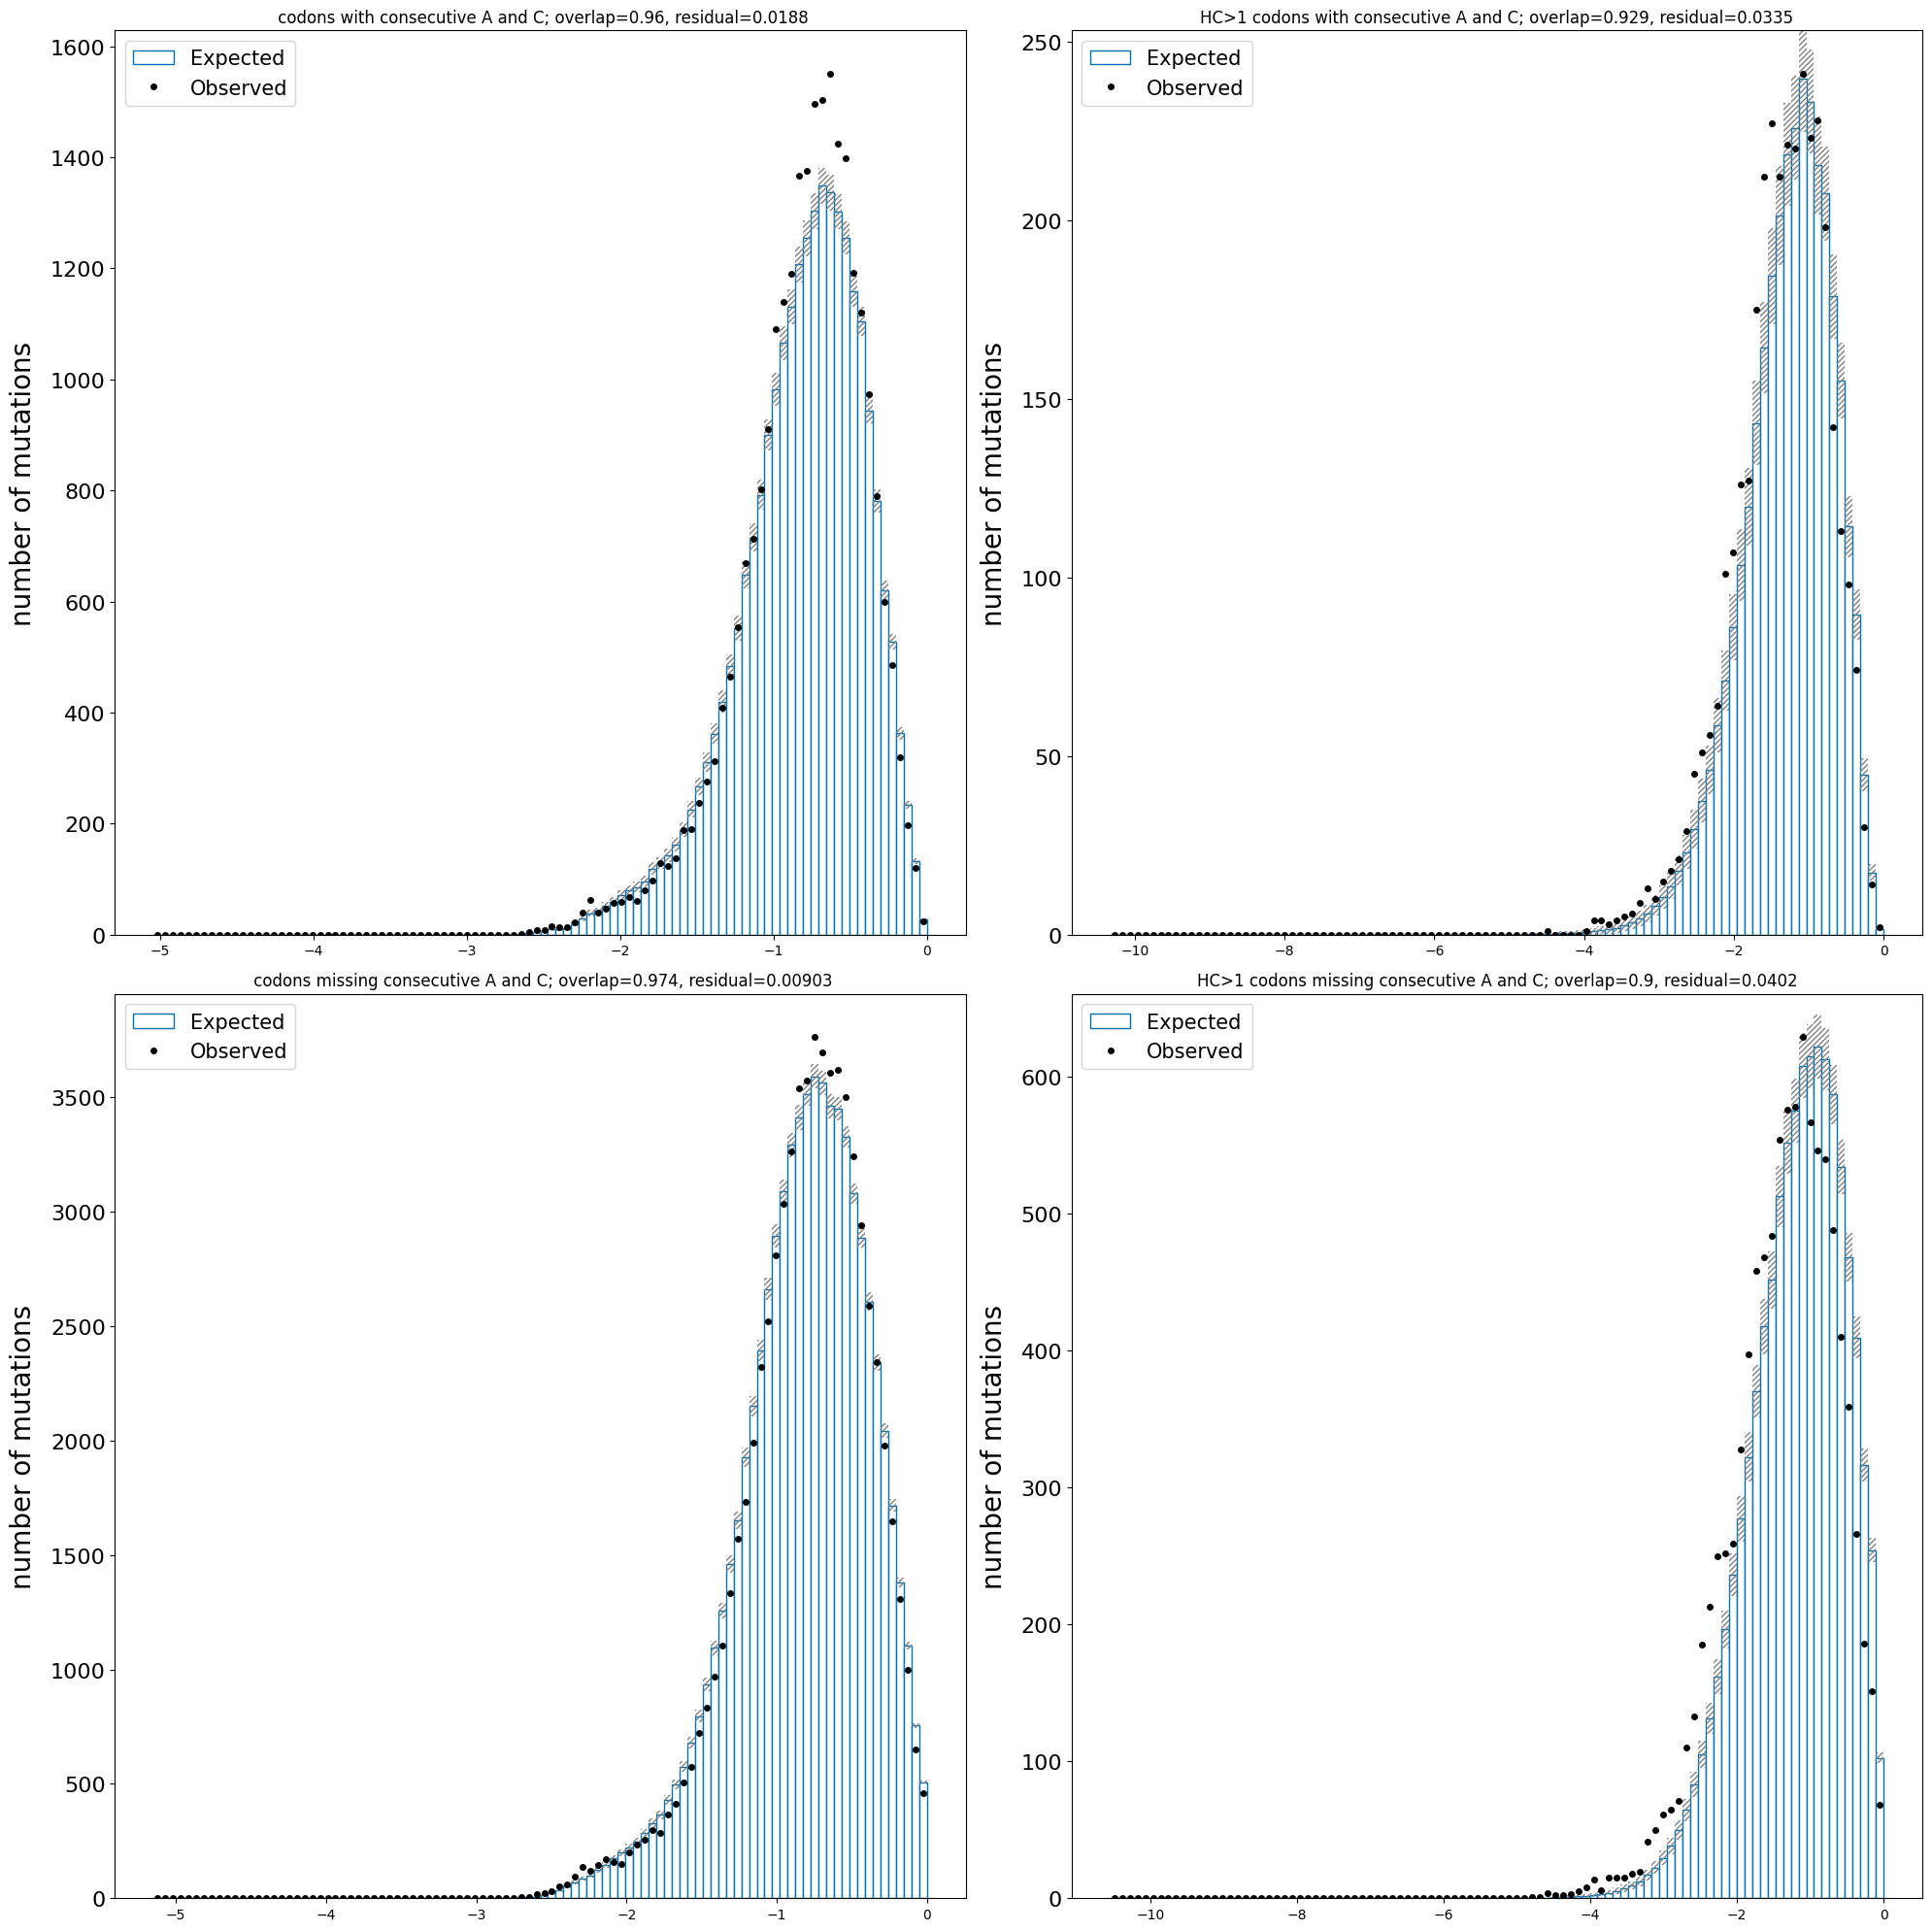

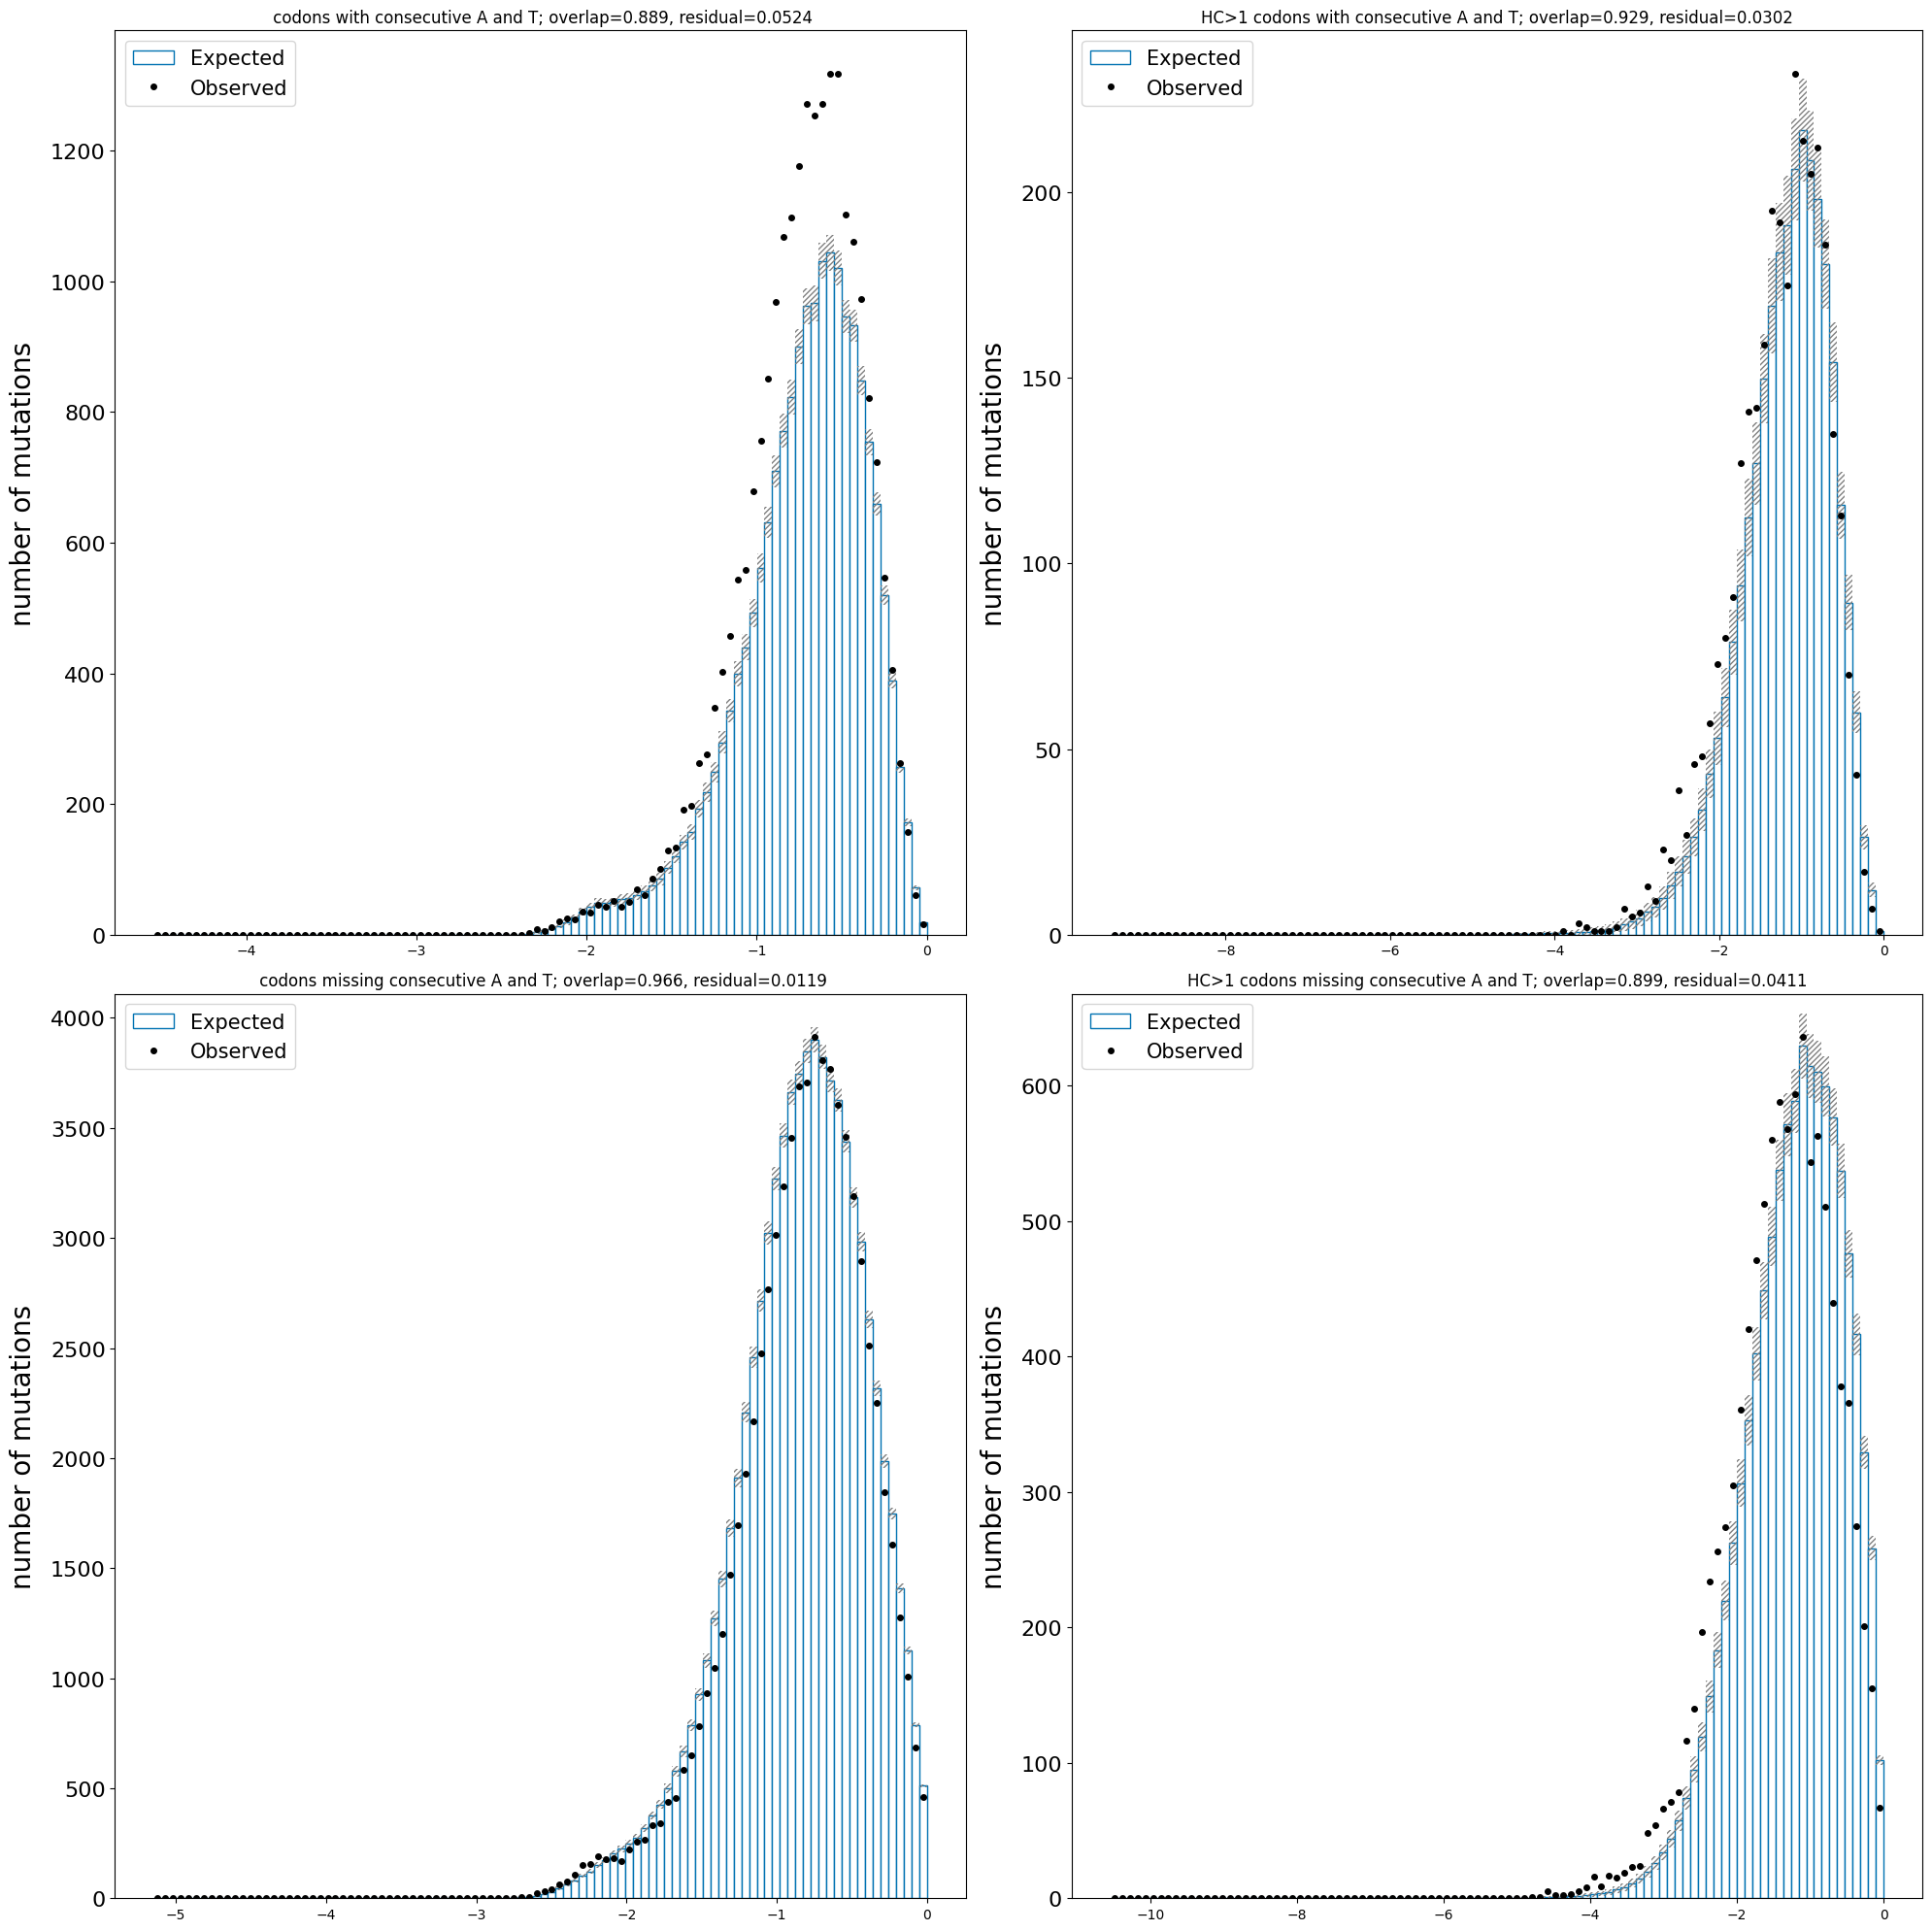

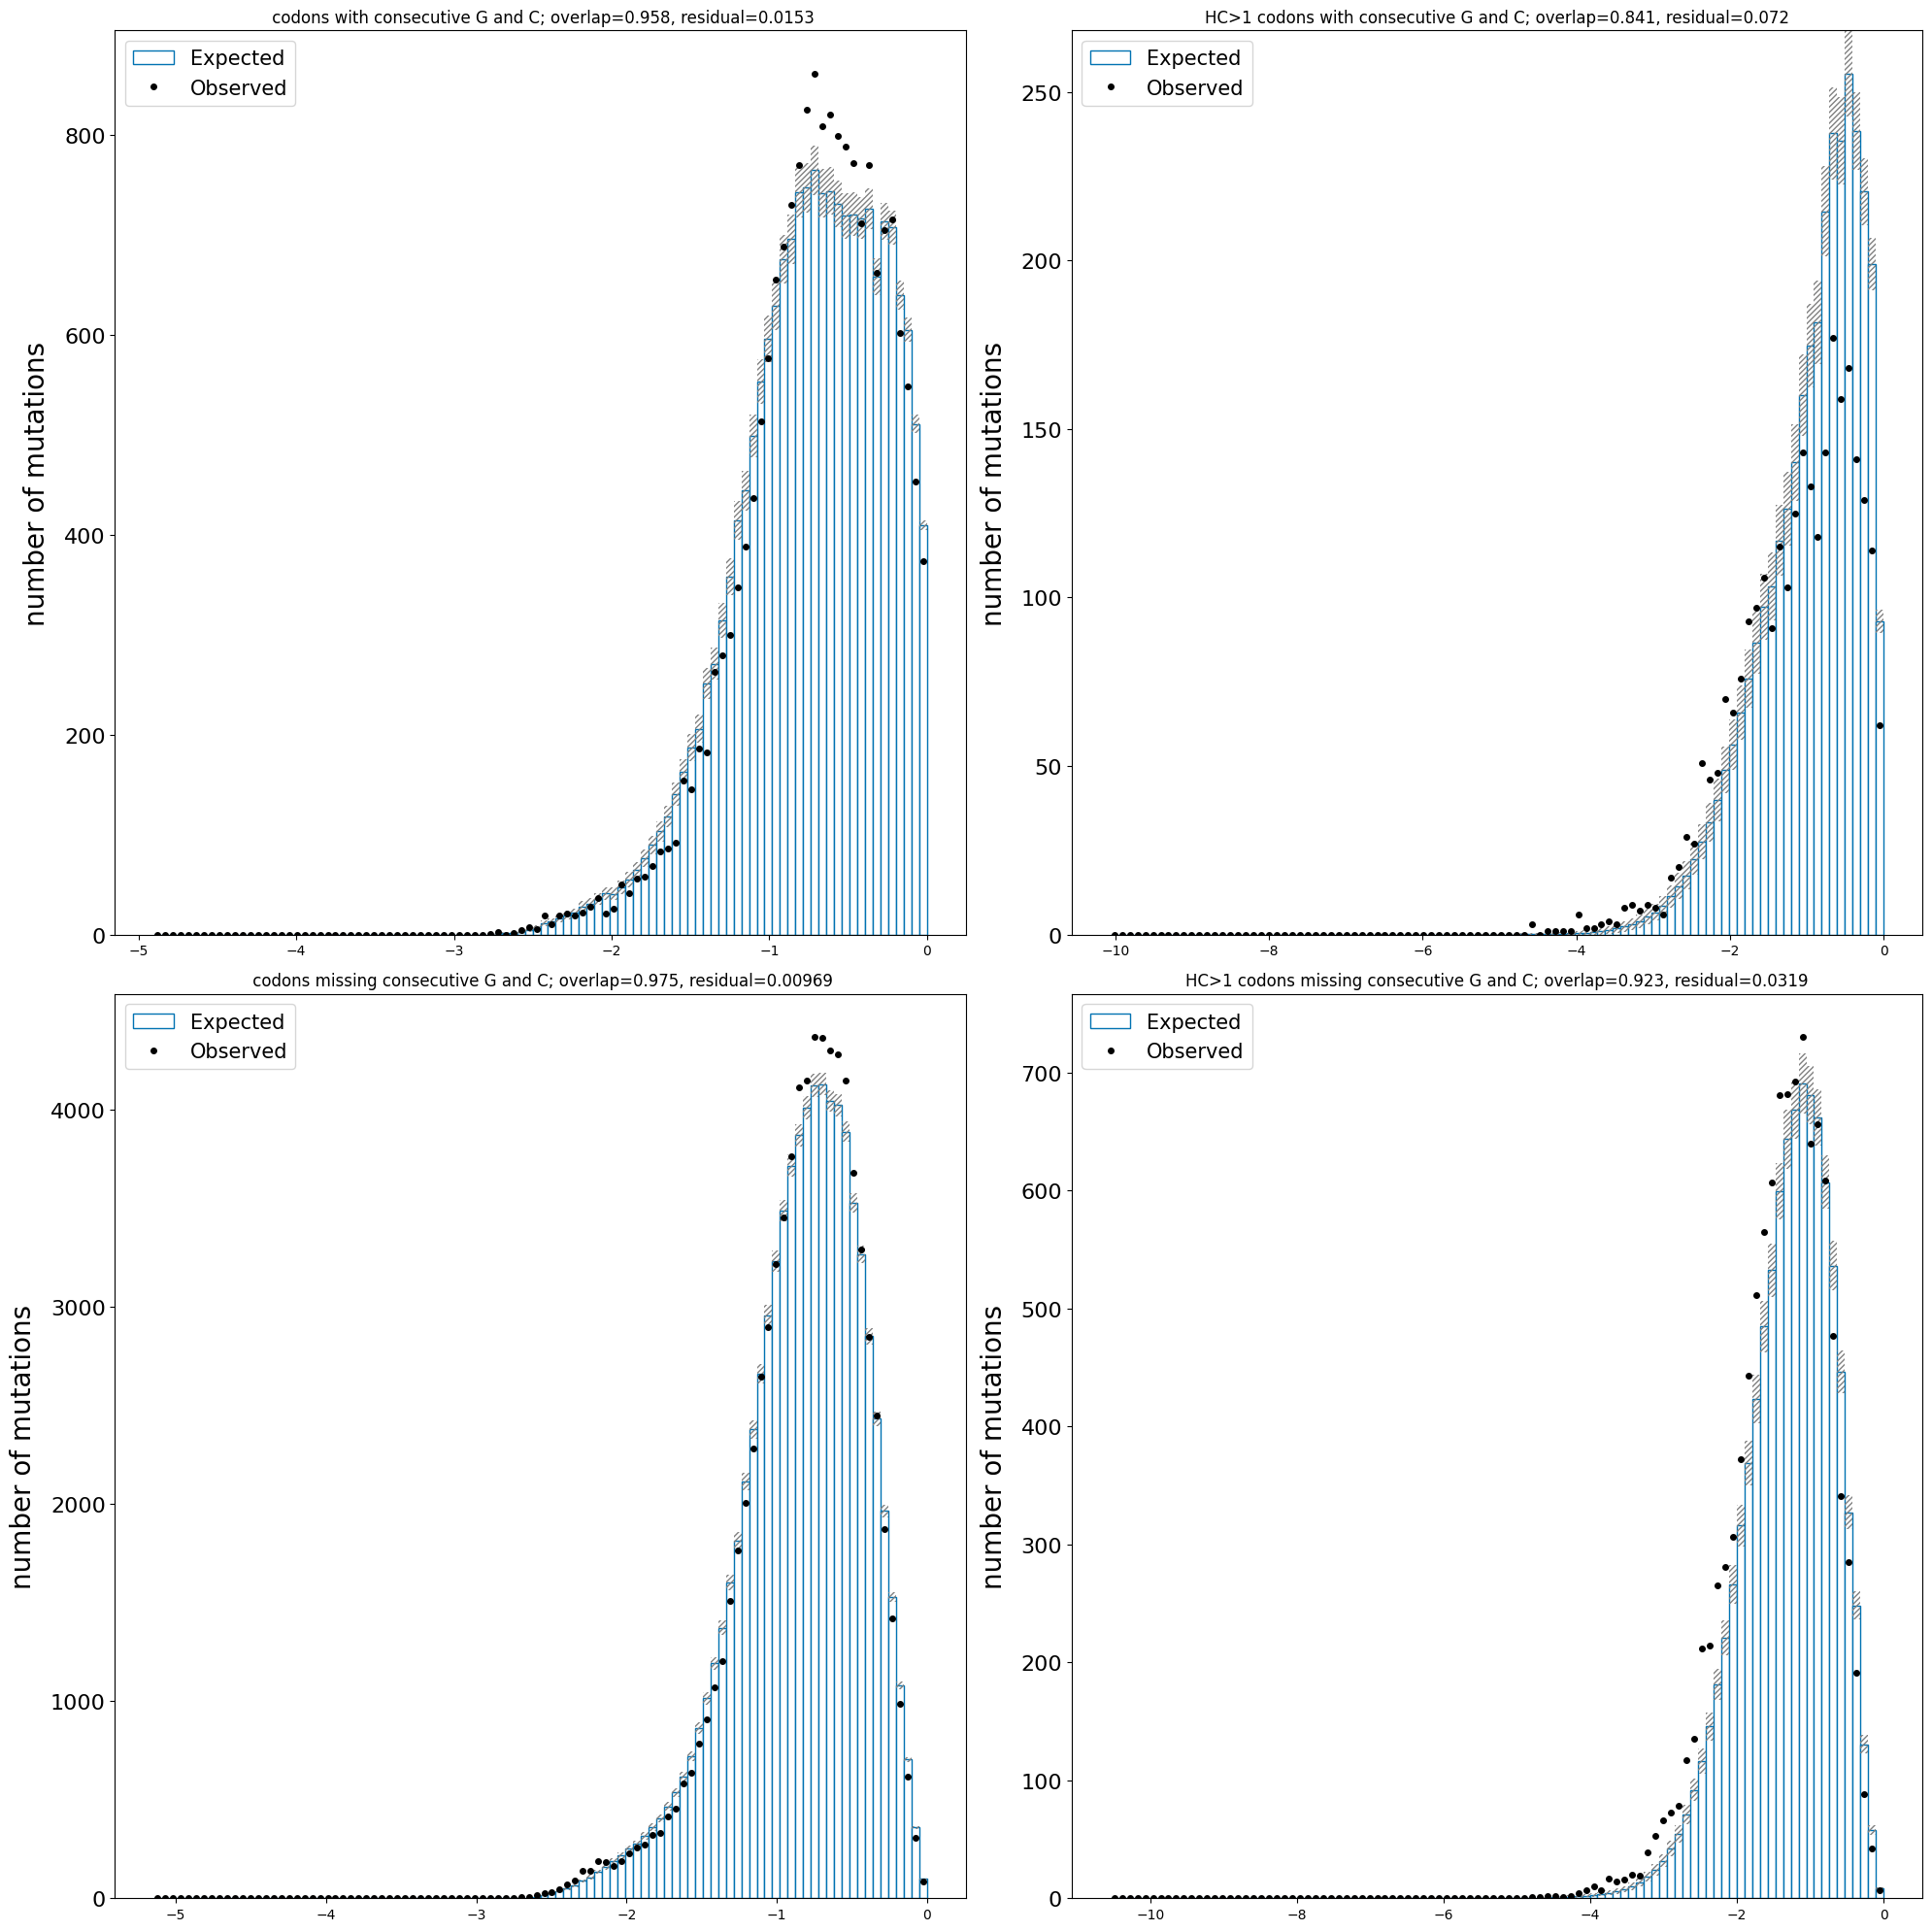

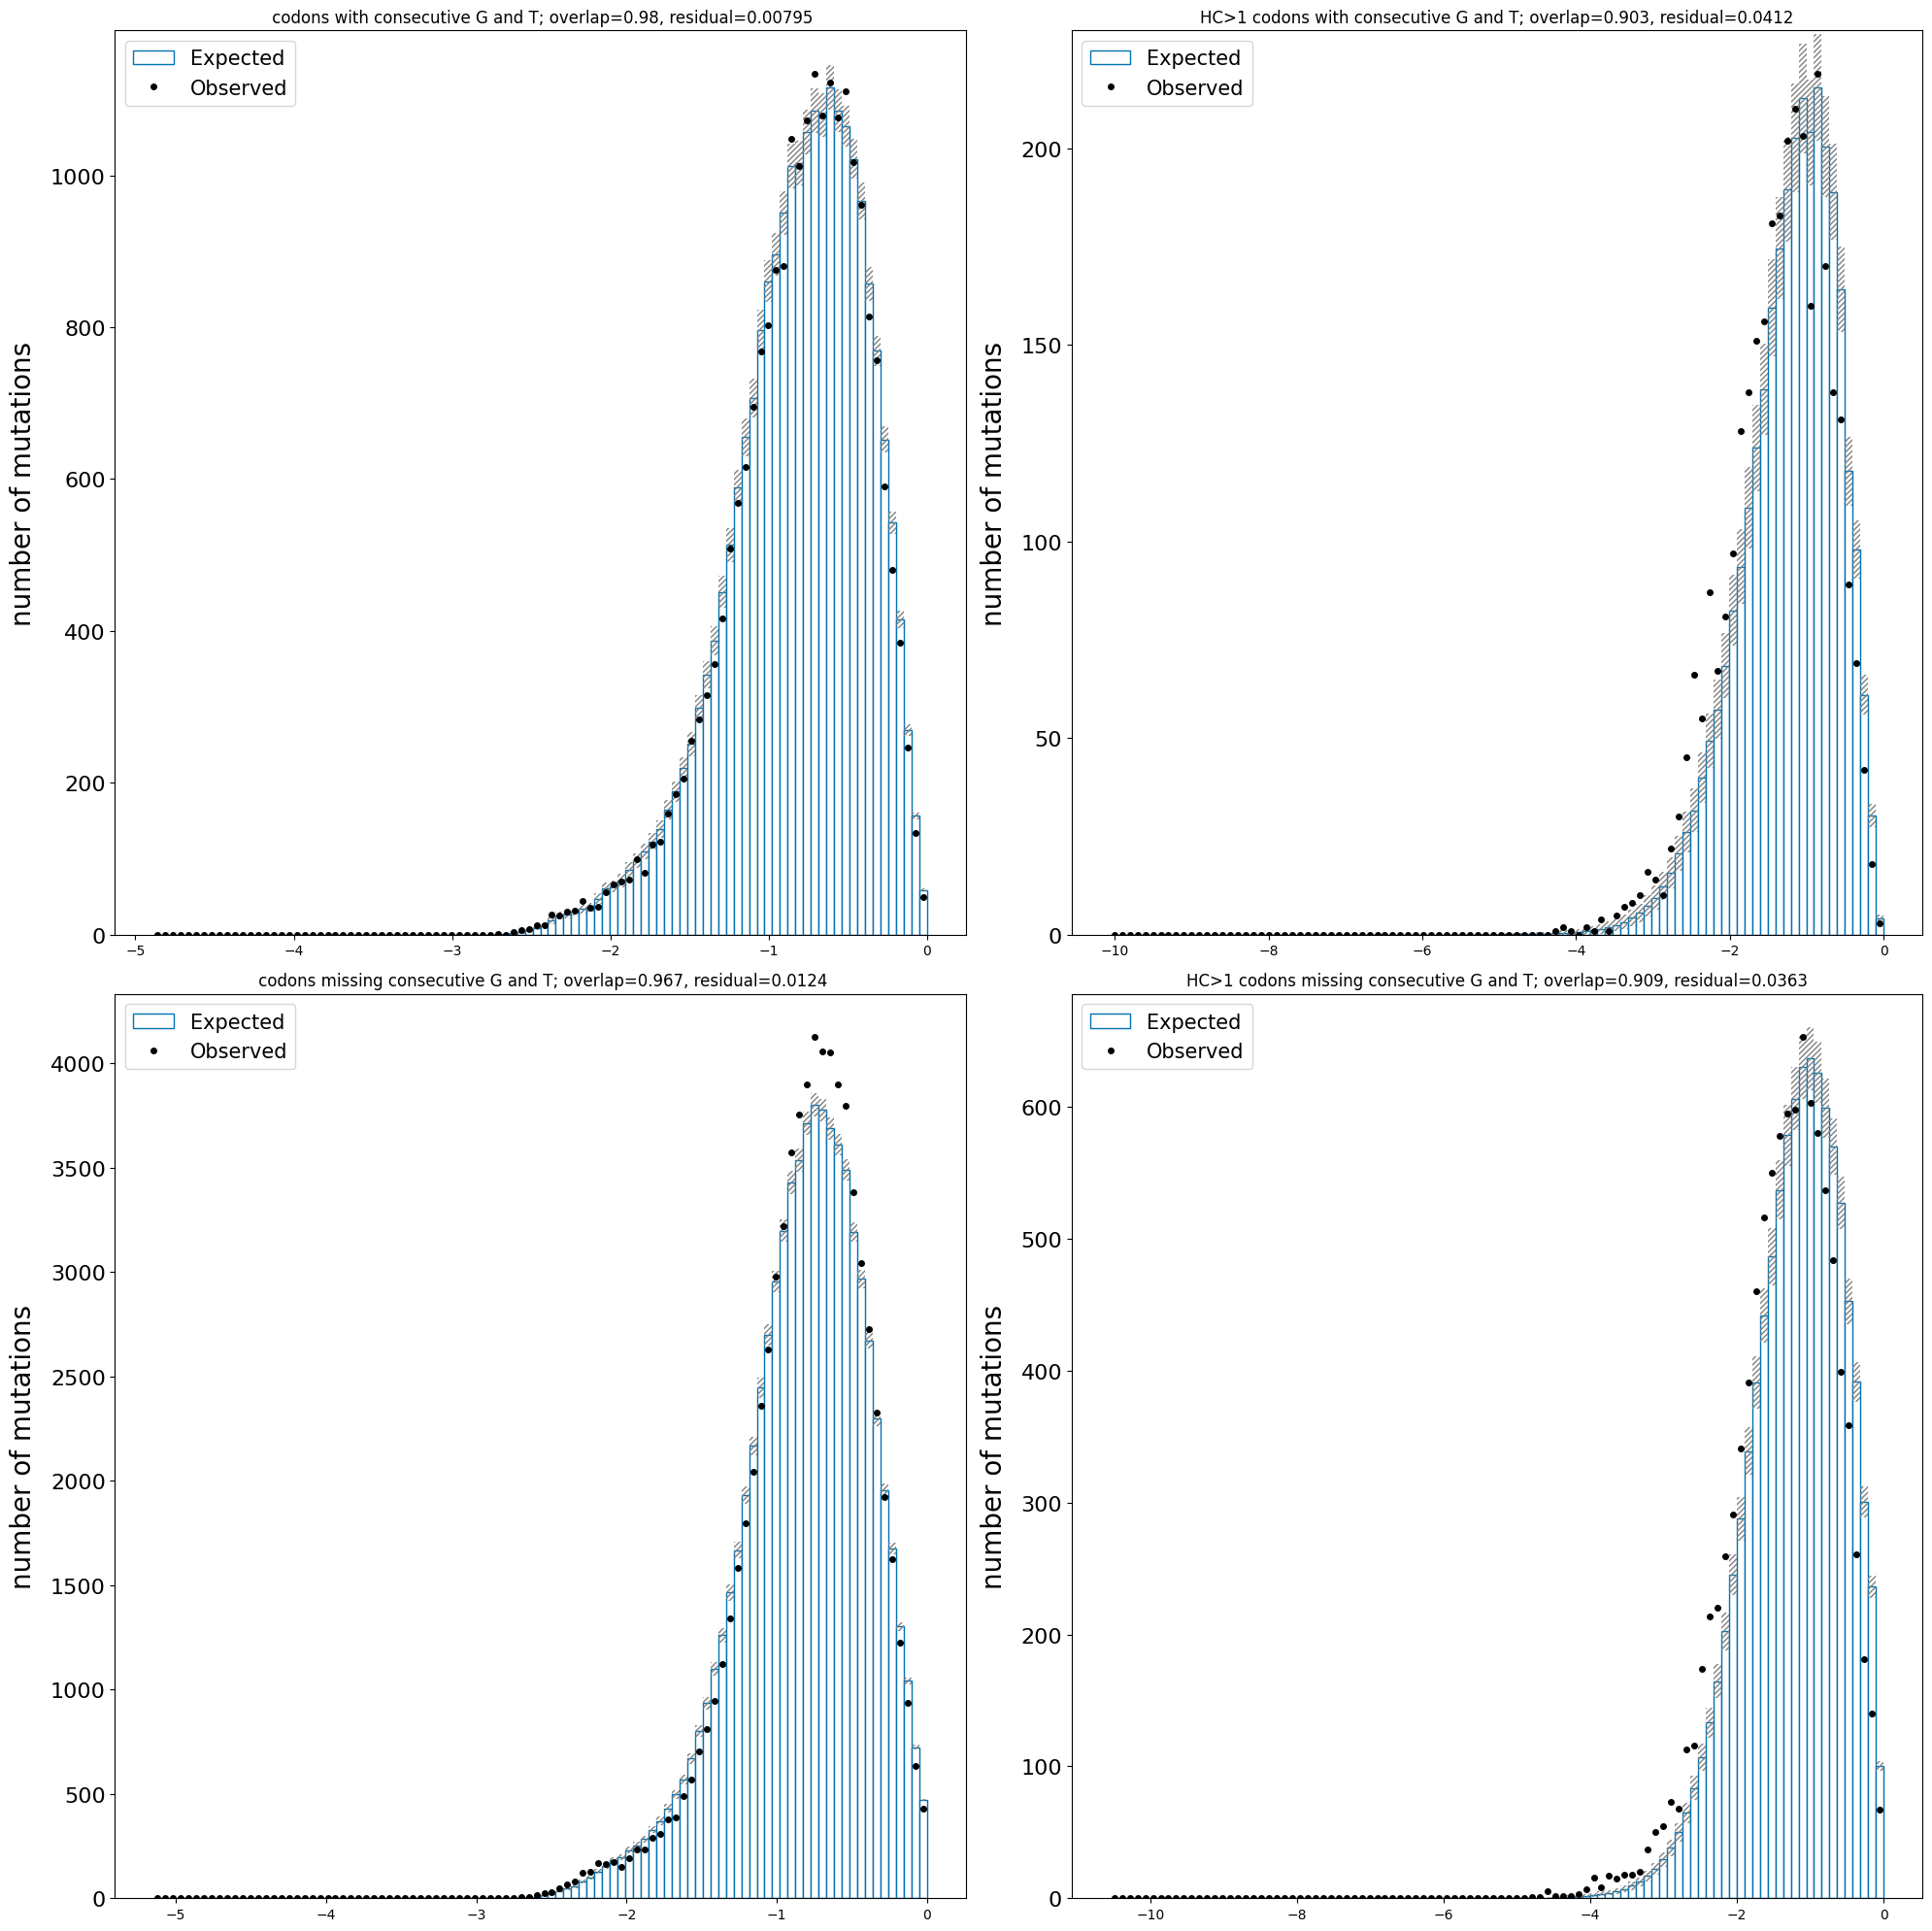

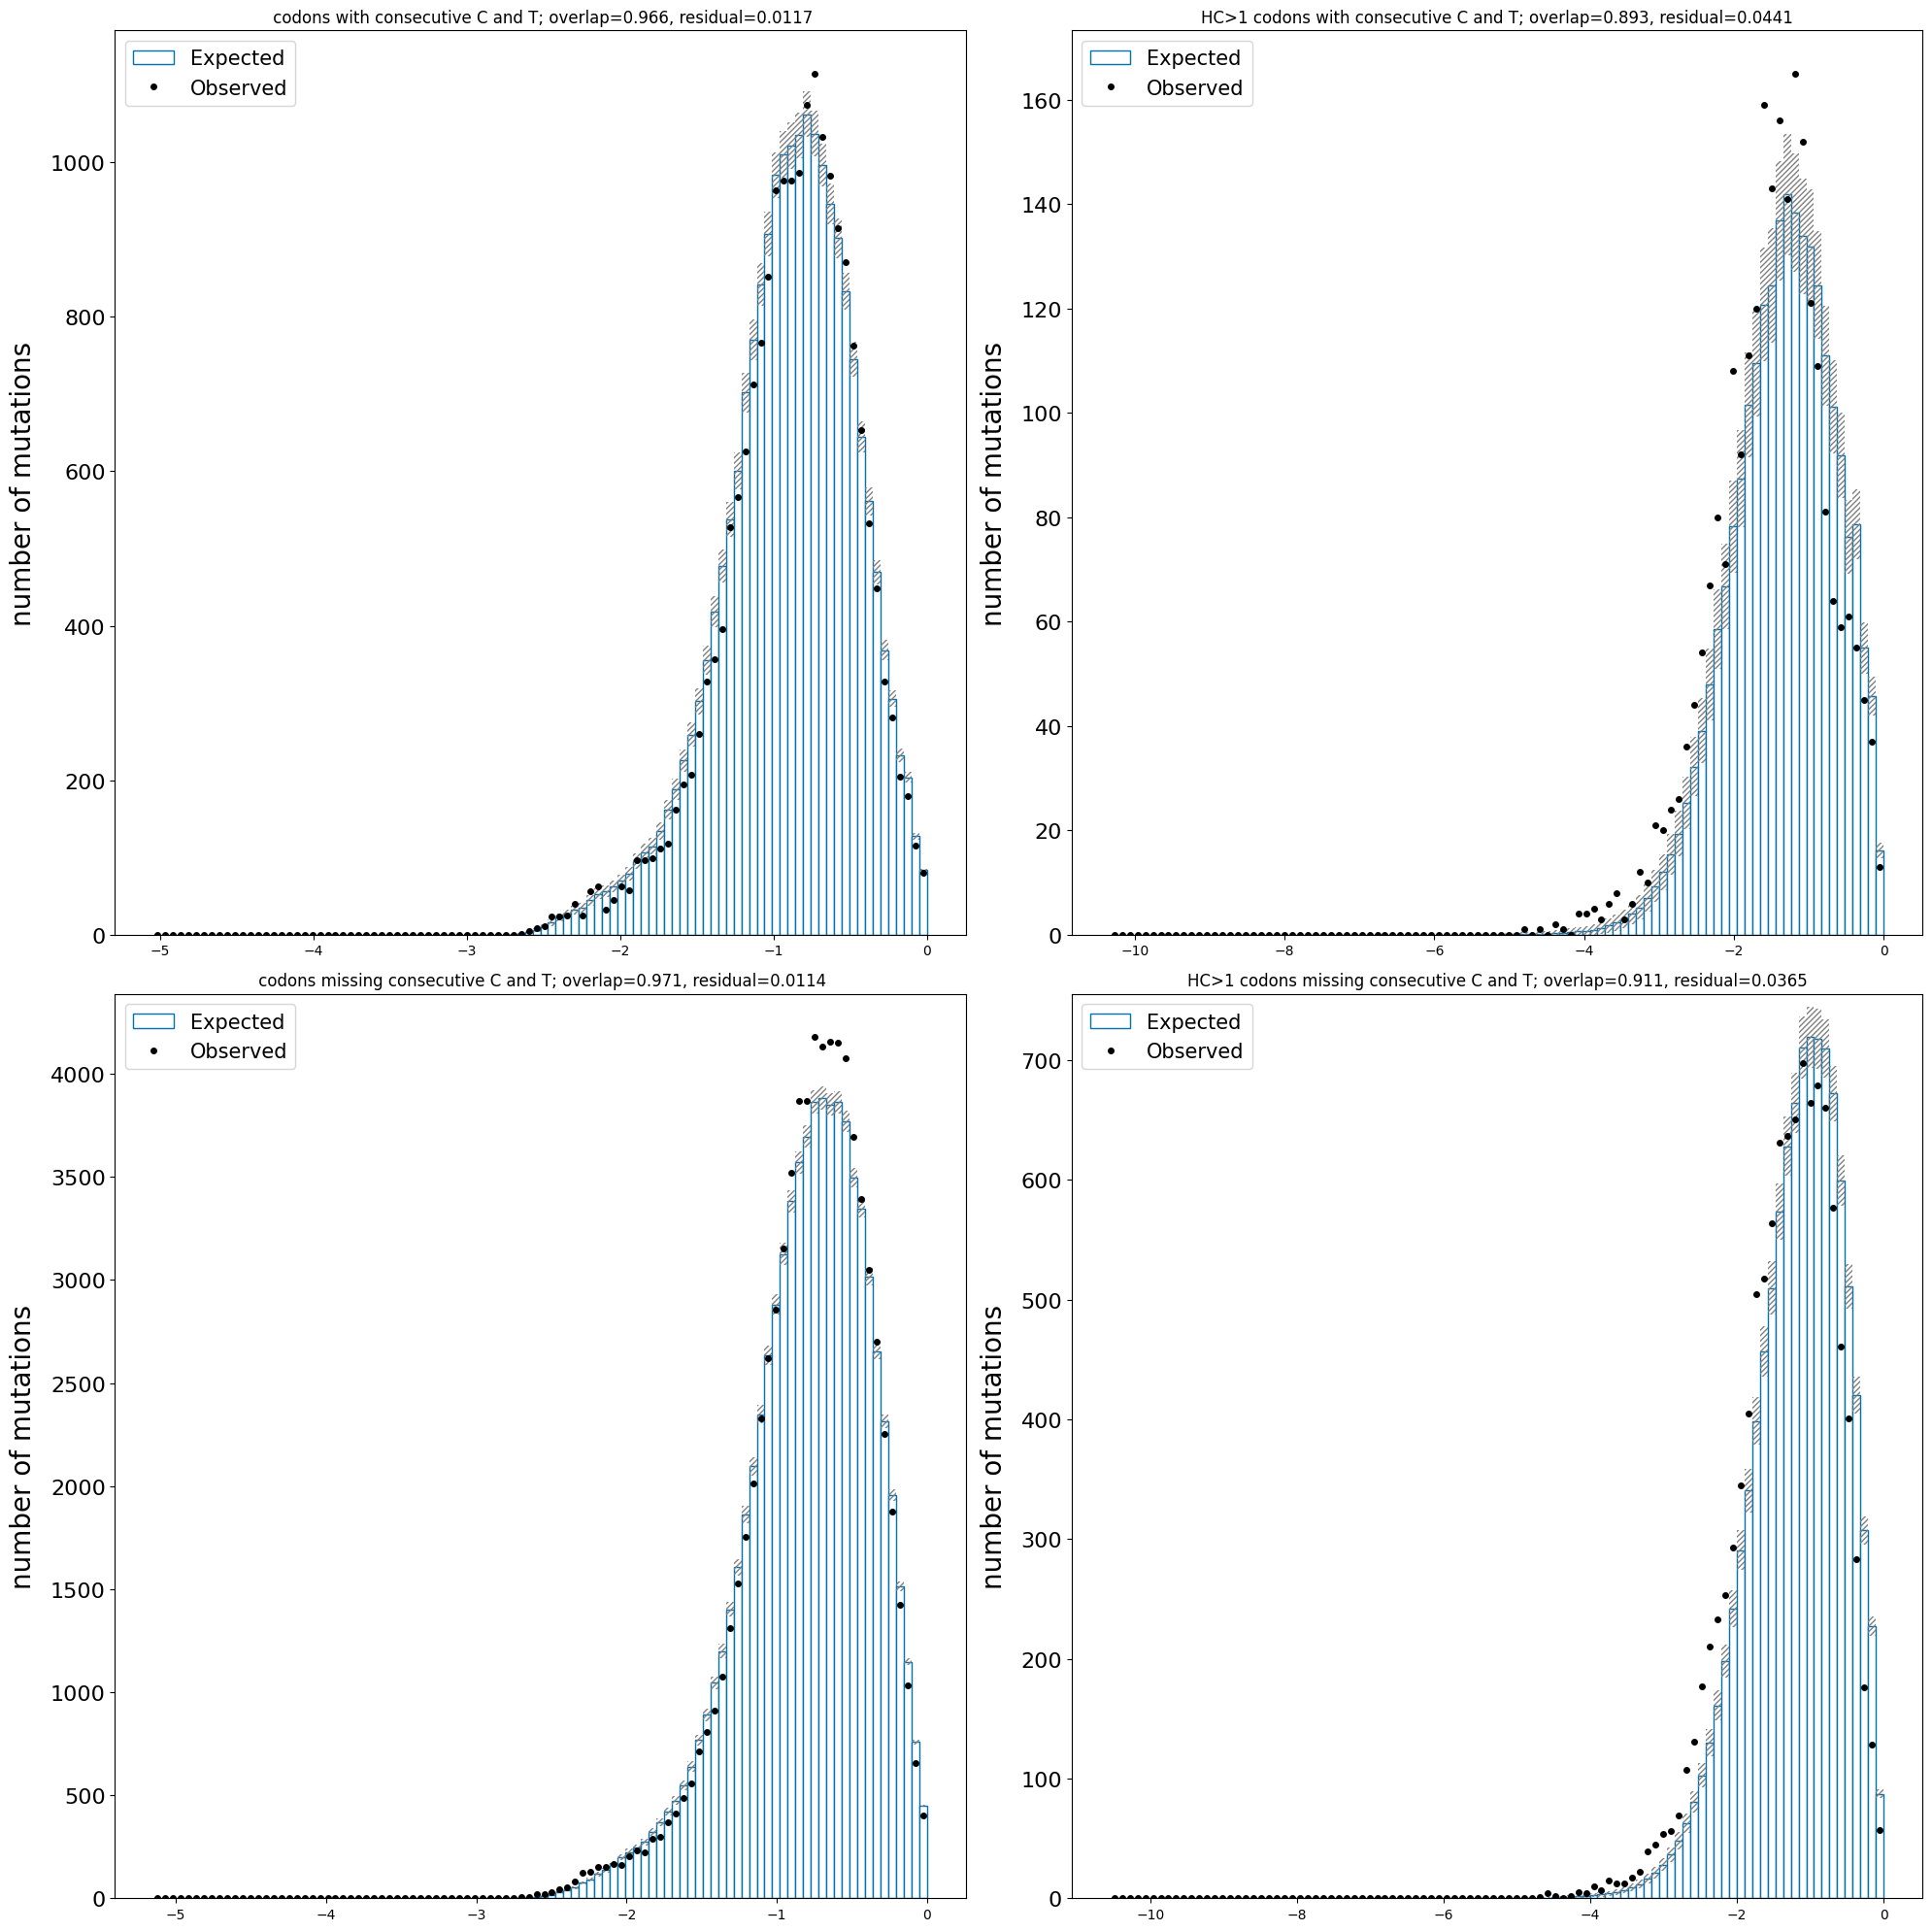

In [16]:

def oe_plot_of_adjacent_pairs(hc_site_df, nts):
    """Stratifies by whether parent codon contains both nts, and only looks at hit class 2+ codons.
    nts must contain two nucleotides as a string."""
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    nts = ''.join(nts)
    rev_nts = ''.join(reversed(nts))
    true_df = hc_site_df[hc_site_df["parent_codon"].str.contains(nts) | hc_site_df["parent_codon"].str.contains(rev_nts)]
    false_df = hc_site_df[~(hc_site_df["parent_codon"].str.contains(nts) | hc_site_df["parent_codon"].str.contains(rev_nts))]
    for cont_str, df, axpair in zip([f"with consecutive {' and '.join(nts)}", f"missing consecutive {' and '.join(nts)}"], [true_df, false_df], axs):
        for ax, hc_1p in zip(axpair, [False, True]):
            if hc_1p:
                plot_df = pd.DataFrame({
                    "mutation": df["hit_class"] > 1,
                    "prob": df[f"2_hc_prob"] + df[f"3_hc_prob"],
                })
            else:
                plot_df = pd.DataFrame({
                    "mutation": df["hit_class"] > 0,
                    "prob": 1 - df["0_hc_prob"],
                })
            
            result_dict = evaluation.plot_observed_vs_expected(plot_df, None, ax, None)
            ax.set_title(f"{'HC>1' if hc_1p else ''} codons {cont_str}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
    fig.tight_layout()
    return fig


figs = [oe_plot_of_adjacent_pairs(hc_site_df, nts) for nts in combinations("AGCT", 2)]

In [17]:

with PdfPages("base_consecutive_pair_plots.pdf") as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close(fig)

In [18]:

figs = [oe_plot_of_adjacent_pairs(hc_site_df, nts, hc_1p=False) for nts in combinations("AGCT", 2)]

TypeError: oe_plot_of_adjacent_pairs() got an unexpected keyword argument 'hc_1p'